In [2]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from scipy.spatial.distance import braycurtis, canberra, chebyshev, cityblock, correlation, cosine, euclidean, minkowski, sqeuclidean 
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

import nltk
import string
import re
from collections import Counter
from tqdm.notebook import tqdm

import Levenshtein
import distance

import time
from tqdm import tqdm

In [3]:
# !pip install distance

In [4]:
# Настройки
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### Загружаем данные

In [5]:
PATH_DATASET = "datasets/"
# PATH_MODELS = "models/"
# PATH_SUBMISSION = "submission/"

In [121]:
%%time
attributes_df = pd.read_parquet(PATH_DATASET + "attributes.parquet")
resnet_df = pd.read_parquet(PATH_DATASET + "resnet.parquet")
text_and_bert_df = pd.read_parquet(PATH_DATASET + "text_and_bert.parquet")
train_pairs_df = pd.read_parquet(PATH_DATASET + "train.parquet")

attributes_df.shape, resnet_df.shape, text_and_bert_df.shape, train_pairs_df.shape

CPU times: total: 9.81 s
Wall time: 17.6 s


#### Определяем транзитивные пары товаров, когда A=B B=C => A=C через Union-Find

In [12]:
# # Инициализация структур данных для Union-Find
# parent = {}
# rank = {}
# target_count = {}

# def find(node):
#     if parent[node] != node:
#         parent[node] = find(parent[node])
#     return parent[node]

# def union(node1, node2, target):
#     root1 = find(node1)
#     root2 = find(node2)
    
#     if root1 != root2:
#         # Слияние двух деревьев и обновление частоты значений target
#         if rank[root1] > rank[root2]:
#             parent[root2] = root1
#             for key in target_count[root2]:
#                 if key in target_count[root1]:
#                     target_count[root1][key] += target_count[root2][key]
#                 else:
#                     target_count[root1][key] = target_count[root2][key]
#         elif rank[root1] < rank[root2]:
#             parent[root1] = root2
#             for key in target_count[root1]:
#                 if key in target_count[root2]:
#                     target_count[root2][key] += target_count[root1][key]
#                 else:
#                     target_count[root2][key] = target_count[root1][key]
#         else:
#             parent[root2] = root1
#             rank[root1] += 1
#             for key in target_count[root2]:
#                 if key in target_count[root1]:
#                     target_count[root1][key] += target_count[root2][key]
#                 else:
#                     target_count[root1][key] = target_count[root2][key]
#     else:
#         # Обновление частоты target в случае, если элементы уже в одной компоненте
#         if target in target_count[root1]:
#             target_count[root1][target] += 1
#         else:
#             target_count[root1][target] = 1

# # Инициализация структур данных
# for idx, row in train_pairs_df.iterrows():
#     id1, id2, target = row['variantid1'], row['variantid2'], row['target']
    
#     if id1 not in parent:
#         parent[id1] = id1
#         rank[id1] = 0
#         target_count[id1] = {0: 0, 1: 0}

#     if id2 not in parent:
#         parent[id2] = id2
#         rank[id2] = 0
#         target_count[id2] = {0: 0, 1: 0}
    
#     # Увеличиваем счетчик target для id1 и id2
#     target_count[id1][target] += 1
#     target_count[id2][target] += 1
    
#     # Объединяем узлы
#     union(id1, id2, target)

# # Собираем компоненты связности
# components = {}
# for node in parent:
#     root = find(node)
#     if root not in components:
#         components[root] = set()
#     components[root].add(node)

# # Генерируем новый датафрейм с транзитивными связями и target
# new_edges = []
# for component in tqdm(components.values()):
#     if len(component) > 1:
#         sorted_nodes = sorted(component)
#         # Получаем наиболее часто встречающееся значение target для этой компоненты
#         most_common_target = max(target_count[find(sorted_nodes[0])], key=target_count[find(sorted_nodes[0])].get)
#         for i in range(len(sorted_nodes)):
#             for j in range(i + 1, len(sorted_nodes)):
                
#                 new_edges.append((sorted_nodes[i], sorted_nodes[j], most_common_target))

# # Создаем новый датафрейм с обнаруженными транзитивными связями
# new_train_df = pd.DataFrame(new_edges, columns=['variantid1', 'variantid2', 'target'])
# new_train_df.shape

In [13]:
# # Исключаем из транзитивных связей трейн связи и перевернутые трейн связи
# new_train_df = new_train_df.set_index(['variantid1', 'variantid2'])
# new_train_df = new_train_df[
#         (~new_train_df.index.isin(new_train_df.index.intersection(train_pairs_df.set_index(['variantid1', 'variantid2']).index)))&
#         (~new_train_df.index.isin(new_train_df.index.intersection(train_pairs_df.set_index(['variantid2', 'variantid1']).index)))]

# new_train_df = new_train_df.reset_index().drop(columns='index', errors='ignore')
# new_train_df.shape

In [14]:
# # Объединяем исходный трейн и транзитивные связи
# train_pairs_df = pd.concat([train_pairs_df, new_train_df])
# train_pairs_df = train_pairs_df.reset_index().drop(columns='index', errors='ignore')
# train_pairs_df.shape

In [15]:
%%time
# Объекдиняем данные о товарах по парам
def join_attrib_by_pare(pairs_df:pd.DataFrame):
    # Добавляем аттрибуты
    features_df = (
        pairs_df
        .merge(
            attributes_df
            .add_suffix('1'),
            on="variantid1"
        )
        .merge(
            attributes_df
            .add_suffix('2'),
            on="variantid2"
        )
    )
    # Добавляем текст 
    features_df = (
        features_df
        .merge(
            text_and_bert_df
            .add_suffix('1'),
            on="variantid1"
        )
        .merge(
            text_and_bert_df
            .add_suffix('2'),
            on="variantid2"
        )
    )
    # Добавляем картинки 
    features_df = (
        features_df
        .merge(
            resnet_df
            .add_suffix('1'),
            on="variantid1"
        )
        .merge(
            resnet_df
            .add_suffix('2'),
            on="variantid2"
        )
    )
    return features_df
    
train_features_df = join_attrib_by_pare(train_pairs_df)

train_features_df.shape

CPU times: total: 7.91 s
Wall time: 8.16 s


(1168516, 17)

In [16]:
union_features_df = pd.concat([train_features_df])
union_features_df.shape

(1168516, 17)

## Текст

In [58]:
#### Сравнение текстового описания
import re
def text_title_iou(name1, name2):
    words1 = set(name1.lower().split())
    words2 = set(name2.lower().split())
    if len(words1 | words2) == 0:
        iou = 0
    else:
        iou = len(words1 & words2)/ len(words1 | words2)
    return iou

def text_title_iou_filter(name1, name2, skip_rus=False):
    if skip_rus:
        # Допускаются русские буквы только если они идут внутри слова с цифрами или символами иначе убираем их
        pattern = r"[a-zA-Z]+|[\d]+"
    else:
        pattern = r"[a-zA-Z]+|[\d]+|[а-яА-Я]+"
    words1 = set(re.findall( pattern, name1.lower()))
    words2 = set(re.findall( pattern, name2.lower()))
    if len(words1 | words2) == 0:
        iou = 0
    else:
        iou = len(words1 & words2)/len(words1 | words2)
    return iou

In [18]:
%%time
union_features_df["iou_names"] = union_features_df.progress_apply(lambda x: text_title_iou(x["name1"], x["name2"]), axis=1)
union_features_df["iou_names2"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["name1"], x["name2"]), axis=1)
union_features_df["iou_names2_eng"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["name1"], x["name2"], skip_rus=True), axis=1)
union_features_df.shape

100%|██████████| 1168516/1168516 [00:15<00:00, 74455.48it/s]

CPU times: total: 47.7 s
Wall time: 48.4 s


(1168516, 20)

In [19]:
%%time
# N-gram
# Подсчитываем IoU 2-грамм и 3-грамм
# spec_chars = re.escape(string.punctuation)
def calc_iou_ngram(name1, name2, n_gram, skip_rus=False):
    # Убираем все спецсимволы 
#     name1 = re.sub('[^\w\d ]', '', name1.strip())
#     name2 = re.sub('[^\w\d ]', '', name2.strip())
    pattern = r"[a-zA-Z]+|[\d]+|[а-яА-Я]+"
    name1 = " ".join(sorted(re.findall(pattern, name1.lower())))
    name2 = " ".join(sorted(re.findall(pattern, name2.lower())))
    if skip_rus:
        # Допускаются русские буквы только если они идут внутри слова с цифрами или символами иначе убираем их
        words1 = re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name1)
        words2 = re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name2)
        name1 = " ".join(words1)
        name2 = " ".join(words2)
        
    token_name1 = re.findall('\w+', name1.lower())
    token_name2 = re.findall('\w+', name2.lower())
    
    if len(token_name1) < n_gram or len(token_name2) < n_gram:
        return 0
    bigrams_1 = list(nltk.ngrams(token_name1, n_gram))
    bigrams_2 = list(nltk.ngrams(token_name2, n_gram))
    union = set(bigrams_1) | set(bigrams_2)
    
    intersection_1 = set(bigrams_1) & set(bigrams_2)
    reverse_bigrams_2 = set([gram[::-1] for gram in bigrams_2]) - set(bigrams_2)
    intersection_2 = set(bigrams_1) & reverse_bigrams_2
    intersection = intersection_1 | intersection_2
    iou_n_gram = len(intersection)/len(union)
    return iou_n_gram

union_features_df["iou_1gram_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name1"], 1), axis=1)
union_features_df["iou_2gram_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 2), axis=1)
union_features_df["iou_3gram_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 3), axis=1)
union_features_df["iou_4gram_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 4), axis=1)
union_features_df["iou_5gram_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 5), axis=1)

union_features_df["iou_1gram_eng_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 1, skip_rus=True), axis=1)
union_features_df["iou_2gram_eng_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 2, skip_rus=True), axis=1)
union_features_df["iou_3gram_eng_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 3, skip_rus=True), axis=1)
union_features_df["iou_4gram_eng_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 4, skip_rus=True), axis=1)
union_features_df["iou_5gram_eng_name"] = union_features_df.apply(lambda x: calc_iou_ngram(x["name1"], x["name2"], 5, skip_rus=True), axis=1)

union_features_df.shape

CPU times: total: 5min 24s
Wall time: 5min 27s


(1168516, 30)

In [20]:
%%time
# Поиск анти-слов, которые говорят, что схожие товары все-таки разные (слова-пристаки Pro Max Plus и прочее)
anti_words = Counter()
def find_anti_words(anti_words, name1, name2):
    words1 = set(re.findall( r'([a-z]+)', name1.lower()))
    words2 = set(re.findall( r'([a-z]+)', name2.lower()))
    xor_words = words1.symmetric_difference(words2) 
    anti_words.update(xor_words)

union_features_df[union_features_df["target"]==0][["name1", "name2"]].progress_apply(lambda x: find_anti_words(anti_words, x["name1"], x["name2"]), axis=1)
anti_words.most_common(5)

100%|██████████| 606668/606668 [00:06<00:00, 99523.72it/s] 

CPU times: total: 6.38 s
Wall time: 6.46 s


[('x', 10607), ('a', 7529), ('s', 6999), ('c', 6323), ('m', 6097)]

In [21]:
import pickle
# Сохраняем anti_words
with open('anti_words.pkl', 'wb') as file:
    pickle.dump(anti_words, file)

In [22]:
# # Загружаем anti_words
# with open('anti_words.pkl', 'rb') as file:
#     anti_words = pickle.load(file)

In [23]:
%%time
N_TOP_ANTIWORD = 100
top_anti_words = set([w[0] for w in anti_words.most_common(N_TOP_ANTIWORD)])

def calc_anti_words_values(name1, name2):
    words1 = set(re.findall( r'([a-z]+)', name1.lower()))
    words2 = set(re.findall( r'([a-z]+)', name2.lower()))
    if len(words1 | words2) == 0:
        anti_words_val = 0
    else:
        xor_words = words1.symmetric_difference(words2)
        anti_words_val = len(xor_words & top_anti_words)/max(len(words1), len(words2))
    return anti_words_val
   
union_features_df["anti_words_values"] = union_features_df.apply(lambda x: calc_anti_words_values(x["name1"], x["name2"]), axis=1 )

CPU times: total: 11.8 s
Wall time: 11.8 s


In [59]:
# Дополнительный набор сранвнений текстов
def calc_additional_distance(name1, name2, skip_rus=False):
    # Убираем все спецсимволы 
    pattern = r"[a-zA-Z]+|[\d]+|[а-яА-Я]+"
    name1 = " ".join(sorted(re.findall(pattern, name1.lower())))
    name2 = " ".join(sorted(re.findall(pattern, name2.lower())))
    # name1 = re.sub('[^\w\d_ ]', '', name1.lower()).strip()
    # name2 = re.sub('[^\w\d_ ]', '', name2.lower()).strip()
    if skip_rus:
        # Допускаются русские буквы только если они идут внутри слова с цифрами или символами иначе убираем их
        words1 = re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name1)
        words2 = re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name2)
        name1 = " ".join(words1)
        name2 = " ".join(words2)
    else:
        words1 = re.findall('\w+', name1.lower())
        words2 = re.findall('\w+', name2.lower())        
    # Значения дистанций по умолчанию (где-то схожесть, где-то расстояние
    if name1 == "" and name2 == "":
        return 1, 0, 1, 0, -0.08

    lev_ratio = Levenshtein.ratio(name1, name2)    
    lev_hamming = Levenshtein.hamming(name1, name2)/max(1, len(name1), len(name2))
    lev_seqratio = Levenshtein.seqratio(words1, words2)
    dist_sorensen = distance.sorensen(name1, name2)
    dist_fast_comp = distance.fast_comp(name1, name2)/max(1, len(name1), len(name2))
    return lev_hamming, lev_ratio, dist_sorensen, lev_seqratio, dist_fast_comp


In [25]:
%%time
# Дополнительный набор сранвнений текстов
columns_text_distance = ["lev_hamming", "lev_ratio", "dist_sorensen", "lev_seqratio", "dist_fast_comp", ]
columns_text_distance_eng = ["lev_hamming_eng", "lev_ratio_eng", "dist_sorensen_eng", "lev_seqratio_eng", "dist_fast_comp_eng", ]
union_features_df[columns_text_distance] = union_features_df.progress_apply(lambda x: pd.Series(calc_additional_distance(x["name1"], x["name2"])), axis=1 )
union_features_df[columns_text_distance_eng] = union_features_df.progress_apply(lambda x: pd.Series(calc_additional_distance(x["name1"], x["name2"], skip_rus=True)), axis=1 )

100%|██████████| 1168516/1168516 [01:42<00:00, 11452.09it/s]

CPU times: total: 3min 44s
Wall time: 3min 44s


In [26]:
nan_cols = [i for i in union_features_df.columns if union_features_df[i].isnull().any()]
nan_cols

['description1',
 'description2',
 'pic_embeddings_resnet_v11',
 'pic_embeddings_resnet_v12']

## Изображения

In [27]:
#### Расчет расстяоний между эмбеддингами изображений
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int], metric='euclidean'):
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2, metric=metric 
        )

    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features

In [28]:
# Для случаев когда у продукта нет дополнительных изображений, то используем основное изображение как дополнительное.
union_features_df["pic_embeddings_resnet_v11"] = union_features_df.progress_apply(lambda x: x["main_pic_embeddings_resnet_v11"] if x["pic_embeddings_resnet_v11"] is None else x["pic_embeddings_resnet_v11"], axis=1)
union_features_df["pic_embeddings_resnet_v12"] = union_features_df.progress_apply(lambda x: x["main_pic_embeddings_resnet_v12"] if x["pic_embeddings_resnet_v12"] is None else x["pic_embeddings_resnet_v12"], axis=1)

100%|██████████| 1168516/1168516 [00:06<00:00, 172925.43it/s]


In [29]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50, 100],
    metric="euclidean"
)

In [30]:
%%time
# Сравнение схожести эмбеддингов дополнительных картинок берется несколько перценталей
for metric in ["cosine"]:
    print([f"pic_dist_0_perc_{metric}", f"pic_dist_25_perc_{metric}", f"pic_dist_50_perc_{metric}", f"pic_dist_100_perc_{metric}"])
    union_features_df[[f"pic_dist_0_perc_{metric}", f"pic_dist_25_perc_{metric}", f"pic_dist_50_perc_{metric}", f"pic_dist_100_perc_{metric}"]] = (
        union_features_df[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].progress_apply(
            lambda x: pd.Series(get_pic_features_func(*x, metric=metric)), axis=1
        )
    )

# Сравнение схожести эмбеддингов дополнительных картинок берется миниальное расстоние среди пар сравнения 
union_features_df[f"pic_dist_0_perc_sqeuclidean"] = (
    union_features_df[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)


# Сравнение схожести эмбеддингов главных картинок
union_features_df[f"main_pic_dist_sqeuclidean"] = (
    union_features_df[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)

['pic_dist_0_perc_cosine', 'pic_dist_25_perc_cosine', 'pic_dist_50_perc_cosine', 'pic_dist_100_perc_cosine']


100%|██████████| 1168516/1168516 [06:07<00:00, 3182.28it/s]

CPU times: total: 20min 41s
Wall time: 20min 36s


## Текст эмбеддинги

In [31]:
# Расчет расстяоний между эмбеддингами названий
def text_dense_distances(ozon_embedding, comp_embedding):
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
        return pair_features
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
        return pair_features

    ozon_embedding = np.array(ozon_embedding)
    comp_embedding = np.array(comp_embedding)
    if np.sum(ozon_embedding) == 0 and np.sum(comp_embedding) == 0:
        pair_features = [-1, -1]
    elif np.array_equal(ozon_embedding, comp_embedding):
        pair_features = [0, 0]
    else:
        euclidean_value = euclidean(ozon_embedding, comp_embedding)
        cosine_value = cosine(ozon_embedding, comp_embedding)
        pair_features = [euclidean_value, cosine_value]
        
    return pair_features


In [32]:
%%time
union_features_df[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    union_features_df[["name_bert_641", "name_bert_642"]].progress_apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

100%|██████████| 1168516/1168516 [01:42<00:00, 11405.39it/s]

CPU times: total: 1min 42s
Wall time: 1min 42s


### Кодирование категории цвет

In [33]:
# attributes_df
# categories
# json.loads()
# item_tmp = attributes_df[:1]['characteristic_attributes_mapping'].item()
# json.loads(item_tmp)['Цвет товара']
# # Цвет товара
# attributes_df
# attributes_df

In [97]:
# # Уникальные цвета в трейне и тесте
# colors = attr_df["color_parsed"]
# colors_set = set([])
# for color in colors:
#     if color is None:
#         continue
#     for c in color:
#         colors_set.add(c)
# # print(colors_set)
# print(f"Уникальных цветов в тренировочной и тестовой выборках: {len(colors_set)}")
# union_features_df.to_csv('pre_color.csv')

In [94]:
def color_parsed(x, attr_column_name):
    x_dict = json.loads(x[attr_column_name])
    if 'Цвет товара' in x_dict:
        return x_dict['Цвет товара']
    else:
        return None
union_features_df['color_parsed1'] = union_features_df.progress_apply(lambda x: color_parsed(x, 'characteristic_attributes_mapping1') , axis=1)
union_features_df['color_parsed2'] = union_features_df.progress_apply(lambda x: color_parsed(x, 'characteristic_attributes_mapping2') , axis=1)

100%|██████████| 1218136/1218136 [01:54<00:00, 10644.82it/s]


In [95]:
# словарь простых цветов (Строгий)
# colors_dict = {
#     'небесный':['голубой'], 'ярко-зеленый':['зеленый'], 'мята':['зеленый','голубой'], 'жемчужно-белый':['белый'], 'огненно-красный':['красный','оранжевый'], 'морковный':['оранжевый','желтый'], 'светло-серый':['серый'], 'светло-розовый':['розовый'], 'серовато-зеленый':['серый','зеленый'], 'тыква':['оранжевый','желтый'], 'brown':['коричневый'], 'темно-серый':['серый'], 'светло-зеленый':['зеленый'], 'темно-голубой':['голубой'], 'teal':['зеленый','голубой'], 'кирпично-красный':['красный','оранжевый','коричневый'], 'светло-пурпурный':['фиолетовый'], 'многоцветный':[], 'малахитовый':['зеленый','голубой'], 'ванильный':['желтый','коричневый'], 'нефритовый':['зеленый'], 'черно-синий':['черный','синий'], 'желтый':['желтый'], 'фиолетовый':['фиолетовый'], 'коричнево-красный':['красный','коричневый'], 'желто-розовый':['желтый','розовый'], 'сиреневый':['фиолетовый'], 'emerald':['зеленый'], 'желто-зеленый':['желтый','зеленый'], 'red':['красный'], 'navy':['синий'], 'красно-коричневый':['красный','коричневый'], 'серебристо-серый':['серый'], 'персиковый':['оранжевый','желтый'], 'перу':['оранжевый','коричневый'], 'gold':['желтый'], 'рыжий':['оранжевый','коричневый'], 'светло-коричневый':['желтый','коричневый'], 'песочный':['желтый','коричневый'], 'aquamarine':['зеленый'], 'янтарный':['оранжевый','желтый'], 'yellow':['желтый'], 'peru':['оранжевый','коричневый'], 'green':['зеленый'], 'бежевый':['коричневый'], 'индиго':['фиолетовый'], 'аква':['голубой'], 'бирюзовый':['зеленый','голубой'], 'оливковый':['зеленый'], 'бежево-серый':['серый','коричневый'], 'красно-оранжевый':['красный','оранжевый'], 'серебряный':['серый'], 'сепия':['коричневый'], 'silver':['серый'], 'голуб':['синий'], 'разноцветный':[], 'pear':['желтый','зеленый'], 'красновато-коричневый':['красный','коричневый'], 'черно-красный':['черный','красный'], 'purple':['фиолетовый'], 'темно-розовый':['розовый'], 'изумрудно-зеленый':['зеленый'], 'grey':['серый'], 'бирюзово-зеленый':['зеленый','голубой'], 'лаймовый':['зеленый'], 'зелено-серый':['серый','зеленый'], 'серо-бежевый':['серый'], 'абрикосовый':['оранжевый'], 'болотный':['зеленый'], 'цементный':['серый'], 'magenta':['фиолетовый'], 'бледно-розовый':['розовый'], 'темно-бирюзовый':['зеленый','голубой'], 'травяной':['желтый','зеленый'], 'cyan':['голубой'], 'бледно-желтый':['желтый'], 'коричневый':['коричневый'], 'баклажановый':['фиолетовый'], 'терракотовый':['оранжевый'], 'vanilla':['желтый','коричневый'], 'gray':['серый'], 'латунный':['зеленый'], 'темно-бежевый':['серый','коричневый'], 'sapphire':['белый'], 'зеленый':['зеленый'], 'khaki':['зеленый'], 'burgundy':['красный'], 'фисташковый':['зеленый'], 'молочный':['коричневый'], 'вишня':['красный'], 'гранитный':['черный','серый'], 'горчичный':['желтый'], 'золотой':['желтый'], 'бежево-розовый':['розовый'], 'аметистовый':['фиолетовый'], 'лайм':['желтый','зеленый'], 'темно-коричневый':['коричневый'], 'сер':['серый'], 'фуксия':['фиолетовый'], 'coral':['оранжевый'], 'глициния':['фиолетовый'], 'cream':['коричневый'], 'розовый':['розовый'], 'крас':['красный'], 'blue':['голубой'], 'грушевый':['желтый','зеленый'], 'amber':['желтый'], 'бурый':['коричневый'], 'lilac':['фиолетовый'], 'pink':['розовый'], 'красн':['красный'], 'aqua':['зеленый'], 'светло-голубой':['голубой'], 'зел':['зеленый'], 'ярко-розовый':['розовый'], 'пурпурно-фиолетовый':['фиолетовый'], 'серебристый':['серый'], 'красный':['красный'], 'ярко-синий':['синий'], 'brass':['зеленый'], 'васильковый':['голубой'], 'гусеница':['зеленый'], 'peach':['оранжевый','желтый'], 'мультиколор':[], 'канареечный':['желтый','зеленый'], 'салатовый':['зеленый'], 'фиолетово-синий':['синий','фиолетовый'], 'чер':['черный'], 'corn':['желтый'], 'linen':['коричневый'], 'лавандовый':['голубой','фиолетовый'], 'tan':['желтый'], 'космос':['черный'], 'фиалковый':['фиолетовый'], 'голубой':['голубой'], 'темно-оранжевый':['оранжевый'], 'серо-коричневый':['серый','коричневый'], 'white':['белый'], 'ivory':['желтый'], 'электрик':['серый'], 'бледно-пурпурный':['фиолетовый'], 'светло-синий':['синий'], 'серый':['серый'], 'изумрудный':['зеленый'], 'светло-бирюзовый':['зеленый','голубой'], 'blond':['желтый'], 'светло-фиолетовый':['фиолетовый'], 'copper':['оранжевый'], 'лаванда':['голубой','фиолетовый'], 'охра':['оранжевый'], 'snow':['белый'], 'сине-зеленый':['зеленый','синий'], 'темно-оливковый':['зеленый'], 'изумруд':['зеленый'], 'орхидея':['фиолетовый'], 'черный':['черный'], 'коричнево-бежевый':['коричневый'], 'розово-фиолетовый':['фиолетовый','розовый'], 'светло-бежевый':['коричневый'], 'мятный':['зеленый','голубой'], 'циан':['голубой'], 'марсала':['красный','коричневый'], 'сапфировый':['синий'], 'томатный':['красный','оранжевый'], 'olive':['зеленый'], 'tomato':['красный','оранжевый'], 'orange':['оранжевый'], 'denim':['синий'], 'камуфляжный':['зеленый','коричневый'], 'chocolate':['коричневый'], 'beige':['коричневый'], 'тыквенный':['оранжевый'], 'светло-золотистый':['желтый'], 'кремовый':['коричневый'], 'оранжево-розовый':['оранжевый','розовый'], 'малиново-красный':['красный'], 'orchid':['фиолетовый'], 'amethyst':['фиолетовый'], 'cobalt':['синий'], 'темно-синий':['синий'], 'малиновый':['красный'], 'бело-зеленый':['белый'], 'коралловый':['красный','оранжевый'], 'фиол':['фиолетовый'], 'мятно-зеленый':['зеленый','голубой'], 'черно-серый':['черный','серый'], 'светло-желтый':['желтый'], 'антрацитовый':['серый'], 'терракота':['оранжевый'], 'flax':['коричневый'], 'темно-зеленый':['зеленый'], 'темно-фиолетовый':['фиолетовый'], 'бордовый':['красный'], 'turquoise':['зеленый','голубой'], 'lemon':['желтый'], 'кофейный':['коричневый'], 'indigo':['синий'], 'гранатовый':['красный'], 'син':['синий'], 'бронзовый':['желтый'], 'azure':['голубой'], 'белоснежный':['белый'], 'синий':['синий'], 'вишневый':['красный'], 'черно-зеленый':['черный','зеленый'], 'black':['черный'], 'тиффани':['зеленый','голубой'], 'фиолет':['фиолетовый'], 'золотистый':['желтый'], 'fuchsia':['фиолетовый'], 'серо-голубой':['серый','голубой'], 'льняной':['коричневый'], 'розово-золотой':['желтый','розовый'], 'экрю':['желтый','зеленый'], 'кварцевый':['коричневый'], 'лиловый':['фиолетовый','розовый'], 'кобальтовый':['синий'], 'кораллово-красный':['красный','оранжевый'], 'оранжевый':['оранжевый'], 'шоколадный':['коричневый'], 'хаки':['зеленый'], 'lavender':['голубой','фиолетовый'], 'пурпурный':['фиолетовый'], 'бел':['белый'], 'кирпичный':['оранжевый'], 'белый':['белый'], 'lime':['желтый','зеленый'], 'лазурный':['голубой'], 'ярко-желтый':['желтый'], 'violet':['фиолетовый'], 'серо-зеленый':['серый','зеленый'], 'bronze':['желтый'], 'jade':['зеленый'], 'бордо':['красный'], 'аквамариновый':['зеленый'], 'темно-красный':['красный'], 'buff':['желтый'], 'желт':['желтый'], 'сливовый':['красный'], 'алый':['красный'], 'графит':['серый'], 'лимонный':['желтый'], 'черн':['черный'], 'wine':['красный'], 'кардинал':['красный'], 'ultramarine':['синий'], 'медный':['оранжевый'], 'прозрачный': ['прозрачный'], 'хром': ['серый'], 'серый металлик': ['серый'],
#     'абрикосовый крайола': ['розовый'],  'авокадо': ['зеленый'],  'агатовый серый': ['серый'],  'айвори': ['розовый'],  'акулья кожа': ['голубой', 'серый'],  'алоэ': ['зеленый'],  'амарантово-розовый': ['розовый'],  'амарантовый': ['красный'],  'античная бронза': ['оранжевый', 'коричневый'],  'античное золото': ['коричневый'],  'античный белый': ['белый'],  'античный розовый': ['розовый'],  'антрацитово-серый': ['серый'],  'апельсин': ['оранжевый'],  'атласное серебро': ['серый'],  'бабл гам': ['розовый'],  'банановый': ['желтый'],  'бежевый глянец': ['коричневый'],  'бежевый лайт': ['коричневый'],  'бежевый меланж': ['коричневый'],  'бежевый нейтральный': ['коричневый'],  'бежевый прозрачный': ['коричневый', 'прозрачный'],  'бело-розовый': ['розовый'],  'бело-серый': ['серый'],  'бело-синий': ['синий'],  'бело-терракотовый': ['белый'],  'белый бриллиант': ['белый'],  'белый глянец': ['белый'],  'белый иней': ['белый'],  'белый матовый': ['белый'],  'белый мрамор': ['белый'],  'белый муар': ['белый'],  'белый песок': ['белый'],  'белый текстурный': ['белый'],  'белый шоколад': ['белый'],  'бирюзовый иней': ['голубой'],  'бледно-бордовый': ['красный'],  'бледно-голубой': ['голубой'],  'бледно-зеленый': ['зеленый'],  'бледно-коричневый': ['коричневый'],  'бледно-лиловый': ['фиолетовый'],  'бледно-синий': ['синий'],  'блестящий пурпурный': ['фиолетовый'],  'бордово-фиолетовый': ['фиолетовый'],  'бордовый меланж': ['красный'],  'брезентово-серый': ['зеленый', 'серый'],  'бриллиантово-синий': ['синий'],  'бронза': ['коричневый'],  'бронзово-оливковый': ['коричневый'],  'брусничный': ['красный'],  'бургунди': ['красный'],  'бэби-голубой': ['голубой'],  'бэби-розовый': ['розовый'],  'ванильно-бежевый': ['коричневый'],  'васаби': ['зеленый'],  'вери пери': ['фиолетовый', 'голубой'],  'винно-красный': ['красный'],  'винный': ['красный'],  'вишнево-красный': ['красный'],  'галопогосский зеленый': ['зеленый'],  'глубокий зеленый': ['зеленый'],  'глубокий коричневый': ['коричневый'],  'глубокий красный': ['красный'],  'глубокий пурпурно-розовый': ['розовый'],  'глубокий пурпурный': ['фиолетовый'],  'глубокий сине-зеленый': ['зеленый'],  'глубокий фиолетовый': ['фиолетовый'],  'глубокий черный': ['черный'],  'голубая ель': ['голубой'],  'голубино-синий': ['синий'],  'голубой берилл': ['голубой'],  'голубой лед': ['голубой'],  'голубой меланж': ['голубой'],  'голубой тиффани': ['голубой'],  'голубой туман': ['голубой'],  'голубые джинсы': ['голубой'],  'горький шоколад': ['коричневый'],  'грязно-голубой': ['голубой'],  'джинс': ['голубой'],  'джинсовый меланж': ['голубой'],  'дымчатый': ['серый'],  'дымчатый синий': ['синий'],  'ежевичный': ['фиолетовый'],  'еловый лес': ['зеленый'],  'желто-зеленый светлый': ['желтый', 'зеленый'],  'желто-коричневый': ['желтый','коричневый'],  'желто-красный': ['желтый', 'красный'],  'желто-оранжевый': ['желтый', 'оранжевый'],  'желтый бархат': ['желтый'],  'желтый крайола': ['желтый'],  'желтый матовый': ['желтый'],  'желтый меланж': ['желтый'],  'желтый тюльпан': ['желтый'],  'жемчужный': ['белый'],  'жемчужный серый': ['серый'],  'защитный хаки': ['зеленый', 'коричневый'],  'зеленая груша': ['зеленый'],  'зеленая мята': ['зеленый'],  'зеленая оливка': ['зеленый'],  'зеленка': ['зеленый'],  'зеленовато-бежевый': ['зеленый'],  'зеленовато-серый': ['серый'],  'зеленовато-синий': ['синий'],  'зеленое море': ['зеленый'],  'зеленое стекло': ['зеленый'],  'зеленый бархат': ['зеленый'],  'зеленый дым': ['зеленый'],  'зеленый лист': ['зеленый'],  'зеленый лишайник': ['зеленый'],  'зеленый меланж': ['зеленый'],  'зеленый мох': ['зеленый'],  'зеленый неон': ['зеленый'],  'зелёный блеск': ['зеленый'],  'зеркальный': ['прозрачный'],  'зернистый бордовый': ['красный'],  'зернистый светло-бежевый': ['белый', 'коричневый'],  'зернистый светло-серый': ['серый'],  'зернистый серо-голубой': ['голубой'],  'зернистый серый': ['серый'],  'зернистый темно-зеленый': ['зеленый'],  'зернистый темно-серый': ['серый'],  'зернистый черный': ['черный'],  'золотисто-бежевый': ['оранжевый', 'коричневый'],  'золотисто-коричневый': ['коричневый'],  'изумрудный меланж': ['зеленый'],  'инжирный': ['фиолетовый'],  'ирисовый': ['фиолетовый'],  'иссиня-черный': ['черный'],  'какао': ['коричневый'],  'камуфляж': ['коричневый', 'зеленый'],  'капучино': ['коричневый'],  'карамельный': ['коричневый'],  'карбон': ['черный'],  'кармин': ['красный'],  'кобальт': ['синий'],  'коньячный': ['коричневый'],  'коралловый темный': ['красный'],  'корица': ['коричневый'],  'коричневато-розовый': ['розовый'],  'коричневая горчица': ['коричневый'],  'коричнево-серый': ['серый'],  'коричневый крайола': ['коричневый'],  'коричневый меланж': ['коричневый'],  'коричневый мрамор': ['коричневый'],  'коричневый перламутровый': ['коричневый'],  'коричневый ротанг': ['коричневый'],  'королевский розовый': ['розовый'],  'королевский синий': ['синий'],  'кофе': ['черный', 'коричневый'],  'кофе с молоком': ['коричневый'],  'кофейная роза': ['коричневый', 'желтый'],  'кофейный десерт': ['коричневый', 'желтый'],  'краплак красный': ['красный'],  'красная слива': ['красный'],  'красно-пурпурный': ['красный', 'фиолетовый'],  'красно-розовый меланж': ['розовый'],  'красно-сиреневый': ['красный'],  'красновато-бордовый': ['красный'],  'красный бархат': ['красный'],  'красный виноград': ['красный'],  'красный каркаде': ['красный'],  'красный матовый': ['красный'],  'красный песок': ['красный'],  'крафт': ['коричневый'],  'кремово-белый': ['белый'],  'лавандово-розовый': ['розовый'],  'лазурно-серый': ['серый'],  'латте': ['коричневый'],  'латунь': ['коричневый'],  'лен': ['коричневый', 'желтый'],  'леопардовый': ['коричневый', 'желтый'],  'лимонно-желтый': ['желтый'],  'лимонно-зеленый': ['зеленый'],  'лимонный крем': ['желтый'],  'лососевый': ['розовый'],  'маджента': ['розовый'],  'малиново-розовый': ['розовый'],  'мандариновый': ['оранжевый'],  'матовое золото': ['оранжевый'],  'медно-коричневый': ['коричневый'],  'медово-бежевый': ['оранжевый'],  'медь': ['оранжевый', 'коричневый'],  'ментол': ['зеленый'],  'металл': ['серый'],  'мокрый асфальт': ['черный'],  'молочно-голубой': ['голубой'],  'молочный шоколад': ['коричневый', 'белый'],  'морская волна': ['голубой', 'зеленый'],  'морской': ['голубой', 'зеленый'],  'мохито': ['зеленый'],  'мышино-серый': ['серый'],  'мягкий белый': ['белый'],  'мягкий розовый': ['розовый'],  'мятно-бирюзовый': ['зеленый'],  'мятно-серый': ['серый'],  'насыщенный желтый': ['желтый'],  'насыщенный коричневый': ['коричневый'],  'натуральный зеленый': ['зеленый'],  'натуральный кремовый': ['коричневый'],  'натуральный серый': ['серый'],  'небесно-голубой': ['голубой'],  'нежно-голубой': ['голубой'],  'незрелый желтый': ['желтый'],  'ночной синий': ['синий'],  'облепиха': ['оранжевый'],  'оливково-зеленый': ['зеленый'],  'оливково-серый': ['серый'],  'оранжево-желтый': ['желтый'],  'оранжево-красный': ['красный'],  'оранжевый витамин': ['оранжевый'],  
#     'оранжевый неон': ['оранжевый'],  'охотничий зеленый': ['зеленый'],  'охра желтая': ['желтый'],  'палисандр': ['коричневый'],  'пастельно-бирюзовый': ['голубой', 'зеленый'],  'пастельно-голубой': ['голубой'],  'пастельно-коричневый': ['коричневый'],  'пастельно-мятный': ['зеленый'],  'пастельно-песочный': ['желтый'],  'пастельно-розовый': ['розовый'],  'пастельно-салатовый': ['зеленый'],  'пастельно-серый': ['серый'],  'пастельно-фиолетовый': ['фиолетовый'],  'пепел': ['серый'],  'пепельно-коричневый': ['коричневый'],  'перламутрово-зелёный': ['зеленый'],  'перламутровый': ['фиолетовый'],  'перламутровый голубой': ['голубой'],  'персидский красный': ['красный'],  'персиково-розовый': ['розовый'],  'песочно-желтый': ['желтый'],  'пломбир': ['белый'],  'полынь': ['зеленый'],  'приглушенно-белый': ['белый'],  'прозрачный кристалл': ['прозрачный'],  'пудровый': ['розовый'],  'пурпур': ['фиолетовый'],  'пурпурно-красный': ['красный'],  'пурпурно-розовый': ['розовый'],  'пурпурно-синий': ['синий'],  'пшеничный': ['желтый'],  'пыльная сирень': ['фиолетовый'],  'пыльно-оливковый': ['зеленый'],  'пыльный бежевый': ['белый'],  'пыльный голубой': ['голубой'],  'резедово-зеленый': ['зеленый'],  'рождественский зеленый': ['зеленый'],  'розовато-серый': ['серый'],  'розовая гвоздика': ['розовый'],  'розовая долина': ['розовый'],  'розовая платина': ['розовый'],  'розовая пудра': ['розовый'],  'розовая фуксия': ['розовый'],  'розово-коралловый': ['розовый'],  'розово-коричневый': ['коричневый'],  'розово-лавандовый': ['розовый'],  'розово-пурпурный': ['розовый'],  'розовое золото': ['розовый'],  'розовое облако': ['розовый'],  'розовый антик': ['розовый'],  'розовый гранат': ['розовый'],  'розовый грейфрут': ['розовый'],  'розовый дым': ['розовый'],  'розовый жемчуг': ['розовый'],  'розовый кварц': ['розовый'],  'розовый лимонад': ['розовый'],  'розовый меланж': ['розовый'],  'розовый нектар': ['розовый'],  'розовый неон': ['розовый'],  'розовый нюд прозрачный': ['розовый', 'прозрачный'],  'розовый персик': ['розовый'],  'розовый тауп': ['розовый'],  'розовый фарфор': ['розовый'],  'рубиновый': ['красный'],  'рыжевато-коричневый': ['коричневый'],  'сапфирово-синий': ['синий'],  'сатиновое золото': ['желтый'],  'свежий мятный': ['зеленый'],  'светлая фиалка': ['фиолетовый'],  'светло серо-зеленый': ['зеленый'],  'светло-оливковый': ['зеленый'],  'светло-оранжевый': ['оранжевый'],  'светло-персиковый': ['розовый'],  'светло-песочный': ['желтый'],  'светло-салатовый': ['зеленый'],  'светло-серый меланж': ['серый'],  'светло-сиреневый': ['фиолетовый'],  'светлое дерево': ['коричневый'],  'светлый опаловый': ['голубой', 'зеленый'],  'светлый хаки': ['зеленый', 'коричневый'],  'сгоревший желтый': ['желтый'],  'серебристо-белый': ['серый', 'белый'],  'серебристый меланж': ['серый'],  'серебристый пион': ['серый'],  'серебристый туман': ['серый'],  'серебро': ['серый'],  'серо-бежевый светлый': ['серый'],  'серо-голубой светлый': ['серый', 'голубой'],  'серо-зеленый джинсовый': ['серый', 'зеленый'],  'серо-синий': ['серый', 'синий'],  'серо-фиолетовый': ['серый', 'фиолетовый'],  'серо-черный': ['серый', 'черный'],  'серовато-красный': ['серый', 'красный'],  'серовато-розовый': ['серый', 'розовый'],  'серый гранит': ['серый'],  'серый графит': ['серый'],  'серый лист': ['серый'],  'серый меланж': ['серый'],  'серый шелк': ['серый'],  'сигнальный серый': ['серый'],  'сине-бирюзовый': ['голубой', 'зеленый'],  'сине-морской': ['голубой', 'зеленый'],  'сине-серый': ['серый'],  'синевато-зеленый': ['зеленый'],  'синий бархат': ['синий'],  'синий кобальт': ['синий'],  'синий космос': ['синий'],  'синий лист': ['синий'],  'синий лён': ['синий'],  'синий меланж': ['синий'],  'синий неон': ['синий'],  'синий персидский': ['синий'],  'синий петроль': ['синий'],  'синяя волна': ['синий'],  'синяя лазурь': ['синий'],  'сиреневый меланж': ['фиолетовый'],  'сливочный': ['белый'],  'слоновая кость': ['белый'],  'солнечно-желтый': ['желтый'],  'сочный гранат': ['красный'],  'средне-серый': ['серый'],  'средне-серый меланж': ['серый'],  'сталь': ['серый'],  'сумеречный': ['зеленый', 'серый'],  'сумрачно-белый': ['белый'],  'супер белый': ['белый'],  'табачный': ['коричневый'],  'тауп': ['коричневый'],  'телесный': ['коричневый'],  'темная вишня': ['красный'],  'темная мята': ['зеленый'],  'темная слива': ['фиолетовый'],  'темно-алый': ['зеленый'],  'темно-бордовый': ['красный'],  'темно-бурый': ['коричневый'],  'темно-горчичный': ['желтый'],  'темно-желтый': ['желтый'],  'темно-каштановый': ['коричневый'],  'темно-лазурный': ['голубой'],  'темно-персиковый': ['розовый'],  'темно-серый меланж': ['черный'],  'темно-синий графитовый': ['синий'],  'темно-синий джинсовый': ['синий'],  'темный горький шоколад': ['черный', 'коричневый'],  'темный синий меланж': ['синий'],  'темный хаки': ['зеленый', 'коричневый'],  'теплый бежевый': ['белый'],  'теплый белый': ['белый'],  'теплый серый': ['серый'],  'терракот меланж': ['оранжевый'],  'терракотовый меланж': ['оранжевый'],  'топаз': ['голубой'],  'травяной зеленый': ['зеленый'],  'тускло-сиреневый': ['фиолетовый'],  'ультрамариновый': ['синий'],  'умеренно зеленый': ['зеленый'],  'умеренный красный': ['красный'],  'умеренный розовый': ['розовый'],  'фиолетово-баклажанный': ['фиолетовый'],  'фиолетовый меланж': ['фиолетовый'],  'французский синий': ['синий'],  'холодный белый': ['белый'],  'холодный зеленый': ['зеленый'],  'чайная роза': ['желтый', 'коричневый'],  'чернильный': ['черный'],  'черничный': ['синий'],  'черно-коричневый': ['черный', 'коричневый'],  'черный графит': ['черный'],  'черный каменный': ['черный'],  'черный кварц': ['черный'],  'черный кристалл': ['черный'],  'черный лакированный никел': ['черный'],  'черный матовый': ['черный'],  'черный меланж': ['черный'],  'черный муар': ['черный'],  'черный нюд': ['черный'],  'черный сапфир': ['черный'],  'черный сахара': ['черный'],  'шампань': ['желтый'],  'шафрановый': ['желтый'],  'шоколадно-коричневый': ['коричневый'],  'ягодный': ['красный'],  'яркий оранжевый': ['оранжевый'],  'ярко-голубой': ['голубой'],  'ярко-красный': ['красный'],  'ярко-салатовый': ['зеленый'],
#     '': ['серый'],
# }
colors_dict = {'небесный': ['голубой'],  'ярко-зеленый': ['зеленый'],  'мята': ['зеленый', 'голубой'],  'жемчужно-белый': ['белый'],  'огненно-красный': ['красный', 'оранжевый'],  'морковный': ['оранжевый', 'желтый'],  'светло-серый': ['серый'],  'светло-розовый': ['розовый'],  'серовато-зеленый': ['серый', 'зеленый'],  'тыква': ['оранжевый', 'желтый'],  'brown': ['коричневый'],  'темно-серый': ['серый'],  'светло-зеленый': ['зеленый'],  'темно-голубой': ['голубой'],  'teal': ['зеленый', 'голубой'],  'кирпично-красный': ['красный', 'оранжевый', 'коричневый'],  'светло-пурпурный': ['фиолетовый'],  'многоцветный': [],  'малахитовый': ['зеленый', 'голубой'],  'ванильный': ['желтый', 'коричневый'],  'нефритовый': ['зеленый'],  'черно-синий': ['черный', 'синий'],  'желтый': ['желтый'],  'фиолетовый': ['фиолетовый'],  'коричнево-красный': ['красный', 'коричневый'],  'желто-розовый': ['желтый', 'розовый'],  'сиреневый': ['фиолетовый'],  'emerald': ['зеленый'],  'желто-зеленый': ['желтый', 'зеленый'],  'red': ['красный'],  'navy': ['синий'],  'красно-коричневый': ['красный', 'коричневый'],  'серебристо-серый': ['серый'],  'персиковый': ['оранжевый', 'желтый'],  'перу': ['оранжевый', 'коричневый'],  'gold': ['желтый'],  'рыжий': ['оранжевый', 'коричневый'],  'светло-коричневый': ['желтый', 'коричневый'],  'песочный': ['желтый', 'коричневый'],  'aquamarine': ['голубой', 'зеленый'],  'янтарный': ['оранжевый', 'желтый'],  'yellow': ['желтый'],  'peru': ['оранжевый', 'коричневый'],  'green': ['зеленый'],  'бежевый': ['коричневый'],  'индиго': ['фиолетовый'],  'аква': ['голубой'],  'бирюзовый': ['зеленый', 'голубой'],  'оливковый': ['зеленый'],  'бежево-серый': ['серый', 'коричневый'],  'красно-оранжевый': ['красный', 'оранжевый'],  'серебряный': ['серый'],  'сепия': ['коричневый'],  'silver': ['серый'],  'голуб': ['синий'],  'разноцветный': [],  'pear': ['желтый', 'зеленый'],  'красновато-коричневый': ['красный', 'коричневый'],  'черно-красный': ['черный', 'красный'],  'purple': ['фиолетовый'],  'темно-розовый': ['розовый'],  'изумрудно-зеленый': ['зеленый'],  'grey': ['серый'],  'бирюзово-зеленый': ['зеленый', 'голубой'],  'лаймовый': ['зеленый'],  'зелено-серый': ['серый', 'зеленый'],  'серо-бежевый': ['серый'],  'абрикосовый': ['оранжевый'],  'болотный': ['зеленый'],  'цементный': ['серый'],  'magenta': ['фиолетовый'],  'бледно-розовый': ['розовый'],  'темно-бирюзовый': ['зеленый', 'голубой'],  'травяной': ['желтый', 'зеленый'],  'cyan': ['голубой'],  'бледно-желтый': ['желтый'],  'коричневый': ['коричневый'],  'баклажановый': ['фиолетовый'],  'терракотовый': ['оранжевый'],  'vanilla': ['желтый', 'коричневый'],  'gray': ['серый'],  'латунный': ['зеленый'],  'темно-бежевый': ['серый', 'коричневый'],  'sapphire': ['синий'],  'зеленый': ['зеленый'],  'khaki': ['зеленый'],  'burgundy': ['красный'],  'фисташковый': ['зеленый'],  'молочный': ['коричневый'],  'вишня': ['красный'],  'гранитный': ['черный', 'серый'],  'горчичный': ['желтый'],  'золотой': ['желтый'],  'бежево-розовый': ['розовый'],  'аметистовый': ['фиолетовый'],  'лайм': ['желтый', 'зеленый'],  'темно-коричневый': ['коричневый'],  'сер': ['серый'],  'фуксия': ['фиолетовый'],  'coral': ['оранжевый'],  'глициния': ['фиолетовый'],  'cream': ['коричневый'],  'розовый': ['розовый'],  'крас': ['красный'],  'blue': ['голубой', 'синий'],  'грушевый': ['желтый', 'зеленый'],  'amber': ['желтый'],  'бурый': ['коричневый'],  'lilac': ['фиолетовый'],  'pink': ['розовый'],  'красн': ['красный'],  'aqua': ['голубой'],  'светло-голубой': ['голубой'],  'зел': ['зеленый'],  'ярко-розовый': ['розовый'],  'пурпурно-фиолетовый': ['фиолетовый'],  'серебристый': ['серый'],  'красный': ['красный'],  'ярко-синий': ['синий'],  'brass': ['зеленый'],  'васильковый': ['голубой'],  'гусеница': ['зеленый'],  'peach': ['оранжевый', 'желтый'],  'мультиколор': [],  'канареечный': ['желтый', 'зеленый'],  'салатовый': ['зеленый'],  'фиолетово-синий': ['синий', 'фиолетовый'],  'чер': ['черный'],  'corn': ['желтый'],  'linen': ['коричневый'],  'лавандовый': ['голубой', 'фиолетовый'],  'tan': ['коричневый'],  'космос': ['черный'],  'фиалковый': ['фиолетовый'],  'голубой': ['голубой'],  'темно-оранжевый': ['оранжевый'],  'серо-коричневый': ['серый', 'коричневый'],  'white': ['белый'],  'ivory': ['желтый'],  'электрик': ['серый'],  'бледно-пурпурный': ['фиолетовый'],  'светло-синий': ['синий'],  'серый': ['серый'],  'изумрудный': ['зеленый'],  'светло-бирюзовый': ['зеленый', 'голубой'],  'blond': ['желтый'],  'светло-фиолетовый': ['фиолетовый'],  'copper': ['оранжевый'],  'лаванда': ['голубой', 'фиолетовый'],  'охра': ['оранжевый'],  'snow': ['белый'],  'сине-зеленый': ['зеленый', 'синий'],  'темно-оливковый': ['зеленый'],  'изумруд': ['зеленый'],  'орхидея': ['фиолетовый'],  'черный': ['черный'],  'коричнево-бежевый': ['коричневый'],  'розово-фиолетовый': ['фиолетовый', 'розовый'],  'светло-бежевый': ['коричневый'],  'мятный': ['зеленый', 'голубой'],  'циан': ['голубой'],  'марсала': ['красный', 'коричневый'],  'сапфировый': ['синий'],  'томатный': ['красный', 'оранжевый'],  'olive': ['зеленый'],  'tomato': ['красный', 'оранжевый'],  'orange': ['оранжевый'],  'denim': ['синий'],  'камуфляжный': ['зеленый', 'коричневый'],  'chocolate': ['коричневый'],  'beige': ['коричневый'],  'тыквенный': ['оранжевый'],  'светло-золотистый': ['желтый'],  'кремовый': ['коричневый'],  'оранжево-розовый': ['оранжевый', 'розовый'],  'малиново-красный': ['красный'],  'orchid': ['фиолетовый'],  'amethyst': ['фиолетовый'],  'cobalt': ['синий'],  'темно-синий': ['синий'],  'малиновый': ['красный'],  'бело-зеленый': ['белый'],  'коралловый': ['красный', 'оранжевый'],  'фиол': ['фиолетовый'],  'мятно-зеленый': ['зеленый', 'голубой'],  'черно-серый': ['черный', 'серый'],  'светло-желтый': ['желтый'],  'антрацитовый': ['серый'],  'терракота': ['оранжевый'],  'flax': ['коричневый'],  'темно-зеленый': ['зеленый'],  'темно-фиолетовый': ['фиолетовый'],  'бордовый': ['красный'],  'turquoise': ['зеленый', 'голубой'],  'lemon': ['желтый'],  'кофейный': ['коричневый'],  'indigo': ['синий'],  'гранатовый': ['красный'],  'син': ['синий'],  'бронзовый': ['желтый'],  'azure': ['голубой'],  'белоснежный': ['белый'],  'синий': ['синий'],  'вишневый': ['красный'],  'черно-зеленый': ['черный', 'зеленый'],  'black': ['черный'],  'тиффани': ['зеленый', 'голубой'],  'фиолет': ['фиолетовый'],  'золотистый': ['желтый'],  'fuchsia': ['фиолетовый'],  'серо-голубой': ['серый', 'голубой'],  'льняной': ['коричневый'],  'розово-золотой': ['желтый', 'розовый'],  'экрю': ['желтый', 'зеленый'],  'кварцевый': ['коричневый'],  'лиловый': ['фиолетовый', 'розовый'],  'кобальтовый': ['синий'],  'кораллово-красный': ['красный', 'оранжевый'],  'оранжевый': ['оранжевый'],  'шоколадный': ['коричневый'],  'хаки': ['зеленый'],  'lavender': ['фиолетовый'],  'пурпурный': ['фиолетовый'],  'бел': ['белый'],  'кирпичный': ['оранжевый'],  'белый': ['белый'],  'lime': ['желтый', 'зеленый'],  'лазурный': ['голубой'],  'ярко-желтый': ['желтый'],  'violet': ['фиолетовый'],  'серо-зеленый': ['серый', 'зеленый'],  'bronze': ['желтый'],  'jade': ['зеленый'],  'бордо': ['красный'],  'аквамариновый': ['зеленый'],  'темно-красный': ['красный'],  'buff': ['желтый'],  'желт': ['желтый'],  'сливовый': ['красный'],  'алый': ['красный'],  'графит': ['серый'],  'лимонный': ['желтый'],  'черн': ['черный'],  'wine': ['красный'],  'кардинал': ['красный'],  'ultramarine': ['синий'],  'медный': ['оранжевый'],  'прозрачный': ['прозрачный'],  'хром': ['серый'],  'серый металлик': ['серый'],  'абрикосовый крайола': ['розовый'],  'авокадо': ['зеленый'],  'агатовый серый': ['серый'],  'айвори': ['розовый'],  'акулья кожа': ['голубой', 'серый'],  'алоэ': ['зеленый'],  'амарантово-розовый': ['розовый'],  'амарантовый': ['красный'],  'античная бронза': ['оранжевый', 'коричневый'],  'античное золото': ['коричневый'],  'античный белый': ['белый'],  'античный розовый': ['розовый'],  'антрацитово-серый': ['серый'],  'апельсин': ['оранжевый'],  'атласное серебро': ['серый'],  'бабл гам': ['розовый'],  'банановый': ['желтый'],  'бежевый глянец': ['коричневый'],  'бежевый лайт': ['коричневый'],  'бежевый меланж': ['коричневый'],  'бежевый нейтральный': ['коричневый'],  'бежевый прозрачный': ['коричневый', 'прозрачный'],  'бело-розовый': ['розовый'],  'бело-серый': ['серый'],  'бело-синий': ['синий'],  'бело-терракотовый': ['белый'],  'белый бриллиант': ['белый'],  'белый глянец': ['белый'],  'белый иней': ['белый'],  'белый матовый': ['белый'],  'белый мрамор': ['белый'],  'белый муар': ['белый'],  'белый песок': ['белый'],  'белый текстурный': ['белый'],  'белый шоколад': ['белый'],  'бирюзовый иней': ['голубой'],  'бледно-бордовый': ['красный'],  'бледно-голубой': ['голубой'],  'бледно-зеленый': ['зеленый'],  'бледно-коричневый': ['коричневый'],  'бледно-лиловый': ['фиолетовый'],  'бледно-синий': ['синий'],  'блестящий пурпурный': ['фиолетовый'],  'бордово-фиолетовый': ['фиолетовый'],  'бордовый меланж': ['красный'],  'брезентово-серый': ['зеленый', 'серый'],  'бриллиантово-синий': ['синий'],  'бронза': ['коричневый'],  'бронзово-оливковый': ['коричневый'],  'брусничный': ['красный'],  'бургунди': ['красный'],  'бэби-голубой': ['голубой'],  'бэби-розовый': ['розовый'],  'ванильно-бежевый': ['коричневый'],  'васаби': ['зеленый'],  'вери пери': ['фиолетовый', 'голубой'],  'винно-красный': ['красный'],  'винный': ['красный'],  'вишнево-красный': ['красный'],  'галопогосский зеленый': ['зеленый'],  'глубокий зеленый': ['зеленый'],  'глубокий коричневый': ['коричневый'],  'глубокий красный': ['красный'],  'глубокий пурпурно-розовый': ['розовый'],  'глубокий пурпурный': ['фиолетовый'],  'глубокий сине-зеленый': ['зеленый'],  'глубокий фиолетовый': ['фиолетовый'],  'глубокий черный': ['черный'],  'голубая ель': ['голубой'],  'голубино-синий': ['синий'],  'голубой берилл': ['голубой'],  'голубой лед': ['голубой'],  'голубой меланж': ['голубой'],  'голубой тиффани': ['голубой'],  'голубой туман': ['голубой'],  'голубые джинсы': ['голубой'],  'горький шоколад': ['коричневый'],  'грязно-голубой': ['голубой'],  'джинс': ['голубой'],  'джинсовый меланж': ['голубой'],  'дымчатый': ['серый'],  'дымчатый синий': ['синий'],  'ежевичный': ['фиолетовый'],  'еловый лес': ['зеленый'],  'желто-зеленый светлый': ['желтый', 'зеленый'],  'желто-коричневый': ['желтый', 'коричневый'],  'желто-красный': ['желтый', 'красный'],  'желто-оранжевый': ['желтый', 'оранжевый'],  'желтый бархат': ['желтый'],  'желтый крайола': ['желтый'],  'желтый матовый': ['желтый'],  'желтый меланж': ['желтый'],  'желтый тюльпан': ['желтый'],  'жемчужный': ['белый'],  'жемчужный серый': ['серый'],  'защитный хаки': ['зеленый', 'коричневый'],  'зеленая груша': ['зеленый'],  'зеленая мята': ['зеленый'],  'зеленая оливка': ['зеленый'],  'зеленка': ['зеленый'],  'зеленовато-бежевый': ['зеленый'],  'зеленовато-серый': ['серый'],  'зеленовато-синий': ['синий'],  'зеленое море': ['зеленый'],  'зеленое стекло': ['зеленый'],  'зеленый бархат': ['зеленый'],  'зеленый дым': ['зеленый'],  'зеленый лист': ['зеленый'],  'зеленый лишайник': ['зеленый'],  'зеленый меланж': ['зеленый'],  'зеленый мох': ['зеленый'],  'зеленый неон': ['зеленый'],  'зелёный блеск': ['зеленый'],  'зеркальный': ['прозрачный'],  'зернистый бордовый': ['красный'],  'зернистый светло-бежевый': ['белый', 'коричневый'],  'зернистый светло-серый': ['серый'],  'зернистый серо-голубой': ['голубой'],  'зернистый серый': ['серый'],  'зернистый темно-зеленый': ['зеленый'],  'зернистый темно-серый': ['серый'],  'зернистый черный': ['черный'],  'золотисто-бежевый': ['оранжевый', 'коричневый'],  'золотисто-коричневый': ['коричневый'],  'изумрудный меланж': ['зеленый'],  'инжирный': ['фиолетовый'],  'ирисовый': ['фиолетовый'],  'иссиня-черный': ['черный'],  'какао': ['коричневый'],  'камуфляж': ['коричневый', 'зеленый'],  'капучино': ['коричневый'],  'карамельный': ['коричневый'],  'карбон': ['черный'],  'кармин': ['красный'],  'кобальт': ['синий'],  'коньячный': ['коричневый'],  'коралловый темный': ['красный'],  'корица': ['коричневый'],  'коричневато-розовый': ['розовый'],  'коричневая горчица': ['коричневый'],  'коричнево-серый': ['серый'],  'коричневый крайола': ['коричневый'],  'коричневый меланж': ['коричневый'],  'коричневый мрамор': ['коричневый'],  'коричневый перламутровый': ['коричневый'],  'коричневый ротанг': ['коричневый'],  'королевский розовый': ['розовый'],  'королевский синий': ['синий'],  'кофе': ['черный', 'коричневый'],  'кофе с молоком': ['коричневый'],  'кофейная роза': ['коричневый', 'желтый'],  'кофейный десерт': ['коричневый', 'желтый'],  'краплак красный': ['красный'],  'красная слива': ['красный'],  'красно-пурпурный': ['красный', 'фиолетовый'],  'красно-розовый меланж': ['розовый'],  'красно-сиреневый': ['красный'],  'красновато-бордовый': ['красный'],  'красный бархат': ['красный'],  'красный виноград': ['красный'],  'красный каркаде': ['красный'],  'красный матовый': ['красный'],  'красный песок': ['красный'],  'крафт': ['коричневый'],  'кремово-белый': ['белый'],  'лавандово-розовый': ['розовый'],  'лазурно-серый': ['серый'],  'латте': ['коричневый'],  'латунь': ['коричневый'],  'лен': ['коричневый', 'желтый'],  'леопардовый': ['коричневый', 'желтый'],  'лимонно-желтый': ['желтый'],  'лимонно-зеленый': ['зеленый'],  'лимонный крем': ['желтый'],  'лососевый': ['розовый'],  'маджента': ['розовый'],  'малиново-розовый': ['розовый'],  'мандариновый': ['оранжевый'],  'матовое золото': ['оранжевый'],  'медно-коричневый': ['коричневый'],  'медово-бежевый': ['оранжевый'],  'медь': ['оранжевый', 'коричневый'],  'ментол': ['зеленый'],  'металл': ['серый'],  'мокрый асфальт': ['черный'],  'молочно-голубой': ['голубой'],  'молочный шоколад': ['коричневый', 'белый'],  'морская волна': ['голубой', 'зеленый'],  'морской': ['голубой', 'зеленый'],  'мохито': ['зеленый'],  'мышино-серый': ['серый'],  'мягкий белый': ['белый'],  'мягкий розовый': ['розовый'],  'мятно-бирюзовый': ['зеленый'],  'мятно-серый': ['серый'],  'насыщенный желтый': ['желтый'],  'насыщенный коричневый': ['коричневый'],  'натуральный зеленый': ['зеленый'],  'натуральный кремовый': ['коричневый'],  'натуральный серый': ['серый'],  'небесно-голубой': ['голубой'],  'нежно-голубой': ['голубой'],  'незрелый желтый': ['желтый'],  'ночной синий': ['синий'],  'облепиха': ['оранжевый'],  'оливково-зеленый': ['зеленый'],  'оливково-серый': ['серый'],  'оранжево-желтый': ['желтый'],  'оранжево-красный': ['красный'],  'оранжевый витамин': ['оранжевый'],  'оранжевый неон': ['оранжевый'],  'охотничий зеленый': ['зеленый'],  'охра желтая': ['желтый'],  'палисандр': ['коричневый'],  'пастельно-бирюзовый': ['голубой', 'зеленый'],  'пастельно-голубой': ['голубой'],  'пастельно-коричневый': ['коричневый'],  'пастельно-мятный': ['зеленый'],  'пастельно-песочный': ['желтый'],  'пастельно-розовый': ['розовый'],  'пастельно-салатовый': ['зеленый'],  'пастельно-серый': ['серый'],  'пастельно-фиолетовый': ['фиолетовый'],  'пепел': ['серый'],  'пепельно-коричневый': ['коричневый'],  'перламутрово-зелёный': ['зеленый'],  'перламутровый': ['фиолетовый'],  'перламутровый голубой': ['голубой'],  'персидский красный': ['красный'],  'персиково-розовый': ['розовый'],  'песочно-желтый': ['желтый'],  'пломбир': ['белый'],  'полынь': ['зеленый'],  'приглушенно-белый': ['белый'],  'прозрачный кристалл': ['прозрачный'],  'пудровый': ['розовый'],  'пурпур': ['фиолетовый'],  'пурпурно-красный': ['красный'],  'пурпурно-розовый': ['розовый'],  'пурпурно-синий': ['синий'],  'пшеничный': ['желтый'],  'пыльная сирень': ['фиолетовый'],  'пыльно-оливковый': ['зеленый'],  'пыльный бежевый': ['белый'],  'пыльный голубой': ['голубой'],  'резедово-зеленый': ['зеленый'],  'рождественский зеленый': ['зеленый'],  'розовато-серый': ['серый'],  'розовая гвоздика': ['розовый'],  'розовая долина': ['розовый'],  'розовая платина': ['розовый'],  'розовая пудра': ['розовый'],  'розовая фуксия': ['розовый'],  'розово-коралловый': ['розовый'],  'розово-коричневый': ['коричневый'],  'розово-лавандовый': ['розовый'],  'розово-пурпурный': ['розовый'],  'розовое золото': ['розовый'],  'розовое облако': ['розовый'],  'розовый антик': ['розовый'],  'розовый гранат': ['розовый'],  'розовый грейфрут': ['розовый'],  'розовый дым': ['розовый'],  'розовый жемчуг': ['розовый'],  'розовый кварц': ['розовый'],  'розовый лимонад': ['розовый'],  'розовый меланж': ['розовый'],  'розовый нектар': ['розовый'],  'розовый неон': ['розовый'],  'розовый нюд прозрачный': ['розовый', 'прозрачный'],  'розовый персик': ['розовый'],  'розовый тауп': ['розовый'],  'розовый фарфор': ['розовый'],  'рубиновый': ['красный'],  'рыжевато-коричневый': ['коричневый'],  'сапфирово-синий': ['синий'],  'сатиновое золото': ['желтый'],  'свежий мятный': ['зеленый'],  'светлая фиалка': ['фиолетовый'],  'светло серо-зеленый': ['зеленый'],  'светло-оливковый': ['зеленый'],  'светло-оранжевый': ['оранжевый'],  'светло-персиковый': ['розовый'],  'светло-песочный': ['желтый'],  'светло-салатовый': ['зеленый'],  'светло-серый меланж': ['серый'],  'светло-сиреневый': ['фиолетовый'],  'светлое дерево': ['коричневый'],  'светлый опаловый': ['голубой', 'зеленый'],  'светлый хаки': ['зеленый', 'коричневый'],  'сгоревший желтый': ['желтый'],  'серебристо-белый': ['серый', 'белый'],  'серебристый меланж': ['серый'],  'серебристый пион': ['серый'],  'серебристый туман': ['серый'],  'серебро': ['серый'],  'серо-бежевый светлый': ['серый'],  'серо-голубой светлый': ['серый', 'голубой'],  'серо-зеленый джинсовый': ['серый', 'зеленый'],  'серо-синий': ['серый', 'синий'],  'серо-фиолетовый': ['серый', 'фиолетовый'],  'серо-черный': ['серый', 'черный'],  'серовато-красный': ['серый', 'красный'],  'серовато-розовый': ['серый', 'розовый'],  'серый гранит': ['серый'],  'серый графит': ['серый'],  'серый лист': ['серый'],  'серый меланж': ['серый'],  'серый шелк': ['серый'],  'сигнальный серый': ['серый'],  'сине-бирюзовый': ['голубой', 'зеленый'],  'сине-морской': ['голубой', 'зеленый'],  'сине-серый': ['серый'],  'синевато-зеленый': ['зеленый'],  'синий бархат': ['синий'],  'синий кобальт': ['синий'],  'синий космос': ['синий'],  'синий лист': ['синий'],  'синий лён': ['синий'],  'синий меланж': ['синий'],  'синий неон': ['синий'],  'синий персидский': ['синий'],  'синий петроль': ['синий'],  'синяя волна': ['синий'],  'синяя лазурь': ['синий'],  'сиреневый меланж': ['фиолетовый'],  'сливочный': ['белый'],  'слоновая кость': ['белый'],  'солнечно-желтый': ['желтый'],  'сочный гранат': ['красный'],  'средне-серый': ['серый'],  'средне-серый меланж': ['серый'],  'сталь': ['серый'],  'сумеречный': ['зеленый', 'серый'],  'сумрачно-белый': ['белый'],  'супер белый': ['белый'],  'табачный': ['коричневый'],  'тауп': ['коричневый'],  'телесный': ['коричневый'],  'темная вишня': ['красный'],  'темная мята': ['зеленый'],  'темная слива': ['фиолетовый'],  'темно-алый': ['зеленый'],  'темно-бордовый': ['красный'],  'темно-бурый': ['коричневый'],  'темно-горчичный': ['желтый'],  'темно-желтый': ['желтый'],  'темно-каштановый': ['коричневый'],  'темно-лазурный': ['голубой'],  'темно-персиковый': ['розовый'],  'темно-серый меланж': ['черный'],  'темно-синий графитовый': ['синий'],  'темно-синий джинсовый': ['синий'],  'темный горький шоколад': ['черный', 'коричневый'],  'темный синий меланж': ['синий'],  'темный хаки': ['зеленый', 'коричневый'],  'теплый бежевый': ['белый'],  'теплый белый': ['белый'],  'теплый серый': ['серый'],  'терракот меланж': ['оранжевый'],  'терракотовый меланж': ['оранжевый'],  'топаз': ['голубой'],  'травяной зеленый': ['зеленый'],  'тускло-сиреневый': ['фиолетовый'],  'ультрамариновый': ['синий'],  'умеренно зеленый': ['зеленый'],  'умеренный красный': ['красный'],  'умеренный розовый': ['розовый'],  'фиолетово-баклажанный': ['фиолетовый'],  'фиолетовый меланж': ['фиолетовый'],  'французский синий': ['синий'],  'холодный белый': ['белый'],  'холодный зеленый': ['зеленый'],  'чайная роза': ['желтый', 'коричневый'],  'чернильный': ['черный'],  'черничный': ['синий'],  'черно-коричневый': ['черный', 'коричневый'],  'черный графит': ['черный'],  'черный каменный': ['черный'],  'черный кварц': ['черный'],  'черный кристалл': ['черный'],  'черный лакированный никел': ['черный'],  'черный матовый': ['черный'],  'черный меланж': ['черный'],  'черный муар': ['черный'],  'черный нюд': ['черный'],  'черный сапфир': ['черный'],  'черный сахара': ['черный'],  'шампань': ['желтый'],  'шафрановый': ['желтый'],  'шоколадно-коричневый': ['коричневый'],  'ягодный': ['красный'],  'яркий оранжевый': ['оранжевый'],  'ярко-голубой': ['голубой'],  'ярко-красный': ['красный'],  'ярко-салатовый': ['зеленый'], '': ['серый'],} 


In [96]:
import pickle
# Сохраняем colors_dict
with open('colors_dict.pkl', 'wb') as file:
    pickle.dump(colors_dict, file)
# # Загружаем colors_dict
# with open('colors_dict.pkl', 'rb') as file:
#     colors_dict = pickle.load(file)

In [98]:
colors_category = sorted(list(set([c for colors in colors_dict.values() for c in colors])))
colors_columns_name_1 = [f"color1_{i+1}" for i in range(len(colors_category))]
colors_columns_name_2 = [f"color2_{i+1}" for i in range(len(colors_category))]
colors_columns_name = [f"color_eq_{i+1}" for i in range(len(colors_category))]

In [99]:
%%time
# Заполняем NaN в цвете товара
def find_color(name, charact):
    colors = []
    for c in list(colors_dict.keys()):
        if c in name.lower():
            colors.append(c)
    if len(colors) > 0:
        return colors
    return None
union_features_df["color_parsed1"] = union_features_df.progress_apply(lambda x: 
                                                    find_color(x["name1"], x["characteristic_attributes_mapping1"]) if x["color_parsed1"] is None else x["color_parsed1"], axis=1)
union_features_df["color_parsed2"] = union_features_df.progress_apply(lambda x: 
                                                    find_color(x["name2"], x["characteristic_attributes_mapping2"]) if x["color_parsed2"] is None else x["color_parsed2"], axis=1)



100%|██████████| 1218136/1218136 [02:35<00:00, 7841.63it/s] 

CPU times: total: 5min 13s
Wall time: 5min 27s


In [103]:
def flatten(xss):
    return [x for xs in xss if xs is not None for x in xs]

In [101]:
%%time
def get_codes_by_colors(color_parsed):
    color_codes = np.zeros(len(colors_category))
    if color_parsed is None:
        return color_codes
    for src_color in color_parsed:
        if src_color in colors_dict: 
            colors = colors_dict[src_color]
        else:
            colors = ['серый']
        for c in colors:
            if c in colors_category:
                color_codes[colors_category.index(c)] = 1
    return color_codes
union_features_df[colors_columns_name_1] = union_features_df["color_parsed1"].progress_apply(lambda x:  pd.Series(get_codes_by_colors(x)))
union_features_df[colors_columns_name_2] = union_features_df["color_parsed2"].progress_apply(lambda x:  pd.Series(get_codes_by_colors(x)))

100%|██████████| 1218136/1218136 [00:46<00:00, 26260.13it/s]

CPU times: total: 1min 36s
Wall time: 1min 40s


In [102]:
%%time
def color_dist(color_parsed1, color_parsed2):
    color_vec1 = get_codes_by_colors(color_parsed1)
    color_vec2 = get_codes_by_colors(color_parsed2)
    euclidean_value = euclidean(color_vec1, color_vec2)
    cosine_value = cosine(color_vec1, color_vec2)
    binary_compare = np.array([1 if (color_vec1[i] == 1) and (color_vec1[i] == color_vec2[i]) else 0 for i in range(len(color_vec1)) ])
    intersection = sum(binary_compare)
    union = sum(color_vec2) + sum(color_vec1) - intersection
    if union == 0:
        iou_color = 0
    else:
        iou_color = intersection/union
    return tuple([euclidean_value, (1-cosine_value), iou_color] + list(binary_compare))

union_features_df[["color_dist_euclidean", "color_sim_cosine", "iou_color"] + colors_columns_name] = union_features_df.progress_apply(lambda x: pd.Series(color_dist(x["color_parsed1"], x["color_parsed2"])), axis=1)

  0%|          | 2/1218136 [00:44<6309:50:31, 18.65s/it] D:\ProgramData\anaconda3\Lib\site-packages\scipy\spatial\distance.py:622: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
100%|██████████| 1218136/1218136 [04:47<00:00, 4232.08it/s]

CPU times: total: 4min 30s
Wall time: 4min 48s


## Категории товаров
##### Сравнеине схожести категорий для одинаковых товаров

In [37]:
def split_cat_product(json_data):
    categories = json.loads(json_data)
    res = [categories[i] for i in categories]
    return res

In [44]:
%%time
union_features_df[["cat_level_1_1", "cat_level_2_1", "cat_level_3_1", "cat_level_4_1"]] = union_features_df["categories1"].progress_apply(lambda x: pd.Series(split_cat_product(x)))
union_features_df[["cat_level_1_2", "cat_level_2_2", "cat_level_3_2", "cat_level_4_2"]] = union_features_df["categories2"].progress_apply(lambda x: pd.Series(split_cat_product(x)))

100%|██████████| 1168516/1168516 [00:51<00:00, 22575.97it/s]

CPU times: total: 1min 40s
Wall time: 1min 40s


In [45]:
%%time
# Признак совпадения категорий
union_features_df["is_equal_cat_1"] = union_features_df.progress_apply(lambda x: 1 if x["cat_level_1_1"] == x["cat_level_1_2"] else 0, axis=1)
union_features_df["is_equal_cat_2"] = union_features_df.progress_apply(lambda x: 1 if x["cat_level_2_1"] == x["cat_level_2_2"] else 0, axis=1)
union_features_df["is_equal_cat_3"] = union_features_df.progress_apply(lambda x: 1 if x["cat_level_3_1"] == x["cat_level_3_2"] else 0, axis=1)
union_features_df["is_equal_cat_4"] = union_features_df.progress_apply(lambda x: 1 if x["cat_level_4_1"] == x["cat_level_4_2"] else 0, axis=1)

100%|██████████| 1168516/1168516 [00:08<00:00, 130136.92it/s]

CPU times: total: 35.8 s
Wall time: 35.8 s


In [122]:
%%time
attributes_df[["cat_level_1", "cat_level_2", "cat_level_3", "cat_level_4"]] = attributes_df["categories"].progress_apply(lambda x: pd.Series(split_cat_product(x)))

100%|██████████| 2252569/2252569 [01:56<00:00, 19307.65it/s]


CPU times: total: 1min 53s
Wall time: 1min 56s


In [47]:
print(f"Кол-во уникальных категориий всего в товарах (тест+трайн):")
print(f"В категории 1: {len(attributes_df['cat_level_1'].unique())}")
print(f"В категории 2: {len(attributes_df['cat_level_2'].unique())}")
print(f"В категории 3: {len(attributes_df['cat_level_3'].unique())}")
print(f"В категории 4: {len(attributes_df['cat_level_4'].unique())}")

Кол-во уникальных категориий всего в товарах (тест+трайн):
В категории 1: 3
В категории 2: 24
В категории 3: 583
В категории 4: 3686


In [48]:
print(f"Кол-во уникальных категориий в парах товар1-товар2:")
print(f"В категории 1: {len(union_features_df['cat_level_1_1'].unique())}")
print(f"В категории 2: {len(union_features_df['cat_level_2_1'].unique())}")
print(f"В категории 3: {len(union_features_df['cat_level_3_1'].unique())}")
print(f"В категории 4: {len(union_features_df['cat_level_4_1'].unique())}")

Кол-во уникальных категориий в парах товар1-товар2:
В категории 1: 3
В категории 2: 24
В категории 3: 575
В категории 4: 3573


#### Разбивка товаров по третьей категории, для метрики

In [49]:
attributes_df[["cat_level_1", "cat_level_2", "cat_level_3", "cat_level_4"]] = attributes_df["categories"].progress_apply(lambda x: pd.Series(split_cat_product(x)))

100%|██████████| 2252569/2252569 [01:39<00:00, 22612.00it/s]


In [105]:
# NEW 30_08_2024
# Распредлеение товаров по второй категории
cat2_counts = attributes_df["cat_level_2"].value_counts().to_dict()
fix_cat2 = ["rest"]
for cat2 in cat2_counts:
    if cat2_counts[cat2] >= 100:
        fix_cat2.append(cat2)
fix_cat2 = list(set(fix_cat2))

In [106]:
# NEW 30_08_2024
import pickle
# Сохраняем fix_cat2
with open('fix_cat2.pkl', 'wb') as file:
    pickle.dump(fix_cat2, file)
# # Загружаем fix_cat2
# with open('fix_cat2.pkl', 'rb') as file:
#     fix_cat2 = pickle.load(file)

In [107]:
union_features_df["cat2_grouped"] = union_features_df["cat_level_2_1"].apply(lambda x: x if x in fix_cat2 else "rest")
# CatBoost ругается на русские навзвания в категориях поэтому переводим в индекс
union_features_df["cat2_grouped_id"] = union_features_df["cat2_grouped"].apply(lambda x: fix_cat2.index(x))

In [108]:
# Распредлеение товаров по третьей категории
cat3_counts = attributes_df["cat_level_3"].value_counts().to_dict()
# Распредлеение товаров по четвертой категории
# cat4_counts = attr_df["cat_level_4"].value_counts().to_dict()
len(cat3_counts)

583

In [109]:
# fix_cat3_for_model - Крупные категории для которых будет создана собственная моедль
cntr = 0
# fix_cat3 = set(["rest"])
fix_cat3 = ["rest"]
fix_cat3_for_model = ["rest"]
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
    else:
        fix_cat3.append(cat3)
        
    if cat3_counts[cat3] > 1_500:
        fix_cat3_for_model.append(cat3)

fix_cat3 = list(set(fix_cat3))
fix_cat3_for_model = list(set(fix_cat3_for_model))
cntr, len(fix_cat3), len(fix_cat3_for_model)

(90527, 243, 193)

In [135]:
import pickle
# Сохраняем fix_cat3
with open('fix_cat3.pkl', 'wb') as file:
    pickle.dump((fix_cat3, fix_cat3_for_model), file)
# # Загружаем fix_cat3
# with open('fix_cat3.pkl', 'rb') as file:
#     fix_cat3, fix_cat3_for_model = pickle.load(file)

In [123]:
union_features_df["cat3_grouped"] = union_features_df["cat_level_3_1"].apply(lambda x: x if x in fix_cat3 else "rest")
union_features_df["cat3_grouped_id"] = union_features_df["cat3_grouped"].apply(lambda x: fix_cat3.index(x))
union_features_df["cat3_grouped_model"] = union_features_df["cat_level_3_1"].apply(lambda x: x if x in fix_cat3_for_model else "rest")
# Объединненый файл с данными также бьем на группы
attributes_df["cat3_grouped_model"] = attributes_df["cat_level_3"].apply(lambda x: x if x in fix_cat3_for_model else "rest")

len(union_features_df["cat3_grouped"].unique()), len(union_features_df["cat3_grouped_model"].unique())

(243, 193)

In [111]:
cat4_counts = attributes_df["cat_level_4"].value_counts().to_dict()
# fix_cat4 = set(["rest"])
fix_cat4 = ["rest"]
for cat4 in cat4_counts:
    if cat4_counts[cat4] >= 100:
        fix_cat4.append(cat4)
fix_cat4 = list(set(fix_cat4))

In [112]:
import pickle
# Сохраняем fix_cat4
with open('fix_cat4.pkl', 'wb') as file:
    pickle.dump(fix_cat4, file)
# # Загружаем fix_cat4
# with open('fix_cat4.pkl', 'rb') as file:
#     fix_cat4 = pickle.load(file)

In [59]:
union_features_df["cat4_grouped"] = union_features_df["cat_level_4_1"].apply(lambda x: x if x in fix_cat4 else "rest")
# CatBoost ругается на русские навзвания в категориях поэтому переводим в индекс
union_features_df["cat4_grouped_id"] = union_features_df["cat4_grouped"].apply(lambda x: fix_cat4.index(x))

#### Баланс классов по категориям¶

In [60]:
balance_cat = {"cat_name": [], "1":[], "0":[]}
# Баланс классов по категориям
for group_cat in fix_cat3_for_model:
#     print(group_cat)
    class_counts = union_features_df[union_features_df["cat3_grouped_model"]==group_cat]["target"].value_counts()
    balance_cat["cat_name"].append(group_cat)
    balance_cat["0"].append(class_counts[0])
    balance_cat["1"].append(class_counts[1])
pd.DataFrame(balance_cat)

cat_name     1     0
0                         Санфаянс и ванны   513  1621
1                             Электродрели  1045   439
2                       Спортивное питание   395  1330
3                             Краска, клей   948  1336
4                     Кабели и переходники  1262  2235
..                                     ...   ...   ...
188  Водоснабжение и инженерная сантехника   419  1327
189                             Смарт-часы   742   733
190                     Хранение продуктов   602   924
191                  Товары для велоспорта  1459  1826
192                 Щетки стеклоочистителя   375   772

[193 rows x 3 columns]

## Характеристика товаров

In [61]:
%%time
def split_attributes(attr_1, attr_2):
    if attr_1 is None or attr_2 is None:
        return (0,0,0,0)
    categories_1 = json.loads(attr_1)
    categories_2 = json.loads(attr_2)
    
    intersection = 0
    weight_intersection = 0
    # Общее кол-во аттрибутов
    # union = len(set(categories_1.keys()).union(set(categories_2.keys())) )
    union = 0
    for key in categories_1:
        if key in categories_2:
            # union считается как все общие характеристики из расчета что если у товара 2 
            # не указана характеристика товра 1, то это не значит что они разные
            union += 1 
            if categories_1[key] == categories_2[key]:
                intersection += 1
            weight_intersection += text_title_iou_filter(categories_1[key][0], categories_2[key][0])

    if union == 0:
        iou_attr = 0
        iou_attr_weight = 0
    else:
        iou_attr = intersection/union
        iou_attr_weight = weight_intersection/union
    # IoU для списка категорий, т.е. насколько перечени характеристик 
    intersection_dict = len(set(categories_1).intersection(set(categories_2)))
    union_dict = len(set(categories_1).union(set(categories_2)))
    iou_dict = intersection_dict/union_dict
    
    return iou_attr, iou_attr_weight, iou_dict, iou_attr*iou_dict, 

union_features_df[["iou_attr", "iou_attr_weight", "iou_dict", "iou_attr_mat_dict"]] = union_features_df[["characteristic_attributes_mapping1","characteristic_attributes_mapping2"]].progress_apply(lambda x: pd.Series(split_attributes(*x)), axis=1)

100%|██████████| 1168516/1168516 [02:29<00:00, 7808.21it/s]

CPU times: total: 2min 29s
Wall time: 2min 29s



<timed exec>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

In [117]:
# Формируем топ-список аттрибутов для каждой категории
pop_characts = {}
TOP_N_characts_for_cat = 100

for cat_name in tqdm(fix_cat3):
    cat_characts = Counter()
    json_characts = attributes_df[attributes_df["cat_level_3"] == cat_name]["characteristic_attributes_mapping"].values
    for json_ch in json_characts:
        if json_ch is not None:
            json_ch = json.loads(json_ch)
            cat_characts.update(json_ch.keys())
    select_cats = [cat_name[0] for cat_name in cat_characts.most_common(TOP_N_characts_for_cat)]
    pop_characts[cat_name] = select_cats

100%|██████████| 243/243 [01:02<00:00,  3.87it/s]


### Товарный  DF IDF  = ( DFkey * IDFvalue) (аля TF IDF)
Идея TF IDF  изменая под задачу товаров будет произведение частоту справочника (key DF - Document Frequency) на обратную частоту значнения спровчника (value IDF - Inverse Document Frequency): (DF key * value IDF):
Если сама характеристика (название "длина кабеля". "типа вилки") встречается у большинства товаров значит это важная характеристика которая может разделить множество товаров , Но! при этом если значение у характеристики у большинства товаров одинаковое (например почти у всех товаров "типа вилки" будет "евровилка"  ) то это менее значимая характеристика.
Таким образом мы сможем из набора характеристик вытащить только важные - это один из способов, есть другие. Я пока этот попробую сделать

Частота справочника (DF key) = Count_Dict/Items  
Обратная частота значения справочника (IDF value) = log(Count_Dict/Count_Sim_Value)

In [118]:
union_features_df[union_features_df["cat3_grouped_model"] == "Одежда"]["cat_level_4_1"].value_counts()

cat_level_4_1
Футболка                    10106
Толстовка, худи, свитшот     5615
Комплект одежды              4526
Платье                       4371
Куртка                       3311
                            ...  
Трико для борьбы                5
Носки спортивные                4
Подвязки                        3
Рукава                          3
Майка боксерская                2
Name: count, Length: 102, dtype: int64

In [124]:
%%time
# Сбор статистики по категориям товаров: кол-во видов характеристик и варианты значений
kv_idf_by_models = {}
for group_cat in fix_cat3_for_model:
    sub_group_df = attributes_df[attributes_df["cat3_grouped_model"] == group_cat]
#     sub_group_df = sub_group_df[sub_group_df["cat_level_4"] == "Системный блок"]
    
    series_charactes = sub_group_df["characteristic_attributes_mapping"]
    keys_idf = Counter()
    values_idf = {}
    for row in series_charactes.values:
        if row is None:
            continue
        row = json.loads(row)
        for k in row:
            keys_idf[k] += 1
            if k not in values_idf:
                values_idf[k] = Counter()
            for value in row[k]:
                values_idf[k][value] += 1
    kv_idf_by_models[group_cat] = (keys_idf, values_idf, len(series_charactes.values))
# kv_idf_by_models

CPU times: total: 1min 1s
Wall time: 1min 1s


In [131]:
# len(fix_cat3_for_model)
# attributes_df['cat_level_1'].unique()
# kv_idf_by_models["Одежда"][1]

#### Расчет важности характеристики товара на основе DF-IDF

In [132]:
# Расчет важности характеристики товара на основе DF-IDF
pop_characts_df_idf = {}
for group_cat in fix_cat3_for_model:
    characters = kv_idf_by_models[group_cat][0]
    items_in_group = kv_idf_by_models[group_cat][2]        
    characters_list = []
    for k in characters:
        counts_k = kv_idf_by_models[group_cat][0][k]
        key_df = counts_k/items_in_group
        counts_v = len(kv_idf_by_models[group_cat][1][k].keys())
        value_idf = np.log(counts_k/counts_v)
        df_idf = key_df * value_idf
        characters_list.append((df_idf, k))
    pop_characts_df_idf[group_cat] = sorted(characters_list, reverse=True)

pop_characts_df_idf["Одежда"][:10]

[(10.355911988651746, 'Пол'),
 (8.610849830963033, 'Коллекция'),
 (8.450976006235324, 'Сезон'),
 (7.459570645517122, 'Тип упаковки одежды'),
 (6.287963227417209, 'Цвет товара'),
 (6.284382388109207, 'Стиль'),
 (6.039233782143307, 'Тип'),
 (5.771243682137398, 'Страна-изготовитель'),
 (5.7220746532057705, 'Российский размер'),
 (4.793530303478208, 'Длина рукава')]

In [ ]:
# pop_characts_df_idf

In [133]:
import pickle
# Сохраняем pop_characts_df_idf
with open('pop_characts_df_idf.pkl', 'wb') as file:
    pickle.dump(pop_characts_df_idf, file)
# # Загружаем pop_characts_df_idf
# with open('pop_characts_df_idf.pkl', 'rb') as file:
#     pop_characts_df_idf = pickle.load(file)

In [113]:
TOP_N_characts = 85

In [114]:
%%time
TOP_N_characts = 85
def code_top_df_idf_characteristics(attr_1, attr_2, group_cat, cat_level_3_1, cat_level_3_2):
    top_pop_characts = [i[1] for i in pop_characts_df_idf[group_cat][:TOP_N_characts]]
    vec_attr = np.zeros(TOP_N_characts + 4 + 5)
    if attr_1 is None or attr_2 is None:
        return vec_attr
    attr_1 = json.loads(attr_1)
    attr_2 = json.loads(attr_2)
    
    if cat_level_3_1 != cat_level_3_2:
        return vec_attr
    
    for i, cat_name in enumerate(top_pop_characts):
        if cat_name in attr_1 and cat_name in attr_2:
            if attr_1[cat_name] == attr_2[cat_name]:
                vec_attr[i] = 1
            else:
                vec_attr[i] = text_title_iou_filter(" ".join(sorted(attr_1[cat_name])), " ".join(sorted(attr_2[cat_name][0])))
#     print("Расчет биграм и триграм")
    # Расчет биграм и триграм, испоьлзуем все характеристики отосортированные по популярности
    all_pop_characts = [i[1] for i in pop_characts_df_idf[group_cat]]
    char_text_1 = []
    char_text_2 = []
    for i, cat_name in enumerate(all_pop_characts):
        if cat_name in attr_1:
            char_text_1.append(" ".join(sorted(attr_1[cat_name])))
        if cat_name in attr_2:
            char_text_2.append(" ".join(sorted(attr_2[cat_name])))
    char_text_1 = " ".join(sorted(char_text_1))
    char_text_2 = " ".join(sorted(char_text_2))
    gram_2 = calc_iou_ngram(char_text_1, char_text_2, 2)
    gram_3 = calc_iou_ngram(char_text_1, char_text_2, 3)
    gram_4 = calc_iou_ngram(char_text_1, char_text_2, 4)
    gram_5 = calc_iou_ngram(char_text_1, char_text_2, 5)
    vec_attr[TOP_N_characts ] = gram_2
    vec_attr[TOP_N_characts + 1] = gram_3
    vec_attr[TOP_N_characts + 2] = gram_4
    vec_attr[TOP_N_characts + 3] = gram_5
    

    attr_lev_hamming, attr_lev_ratio, attr_dist_sorensen, attr_lev_seqratio, attr_dist_fast_comp = calc_additional_distance(char_text_1, char_text_2)
    
    vec_attr[TOP_N_characts + 4] = attr_lev_hamming
    vec_attr[TOP_N_characts + 5] = attr_lev_ratio
    vec_attr[TOP_N_characts + 6] = attr_dist_sorensen
    vec_attr[TOP_N_characts + 7] = attr_lev_seqratio
    vec_attr[TOP_N_characts + 8] = attr_dist_fast_comp
    
    
    return vec_attr

first_top_chars_columns = [f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]
first_columns_attr_distance = ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram", "attr_lev_hamming", "attr_lev_ratio", "attr_dist_sorensen", "attr_lev_seqratio", "attr_dist_fast_comp", ]
# train_features[[f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]] = train_features.apply(lambda x: pd.Series(code_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
# print(train_features[train_features["cat3_grouped_model"]=="Компьютер"].iloc[40:50]["target"])
# train_features[train_features["cat3_grouped_model"]=="Компьютер"].iloc[40:50].apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

union_features_df[first_top_chars_columns + first_columns_attr_distance] = union_features_df.progress_apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)

  0%|          | 1/1218136 [01:58<40154:39:27, 118.67s/it]


NameError: name 'pop_characts_df_idf' is not defined

#### Опредлеение типа полей характеристик

In [71]:
# def str_to_digital(num_str):
#     if isinstance(num_str, int) or isinstance(num_str, float):
#         return num_str
#     num_str = num_str.replace(',', '.')
#     digits = re.findall("[+-]?\d*\.?\d+", num_str)
#     if len(digits) == 0:
#         return 0
#     digits = float(digits[0])
#     return digits

# n = list(kv_idf_by_models["Одежда"][1]["Пол"].keys())

# list(map(str_to_digital, n))

In [72]:
# %%time
# # Определяем какие криетрии из ТОПа для каждой категории являются числовыми, а какие категориальными
# from sklearn.preprocessing import StandardScaler
# N_characts_vector = 50
# types_TOP_characts_columns = {}
# for group_name in fix_cat3_for_model:
# #     print(group_name)
#     top_pop_characts = [i[1] for i in pop_characts_df_idf[group_name][:N_characts_vector]]
#     char_categorical_columns = []
#     char_digital_columns = []
#     char_digital_columns_scalers = []

#     for i in range(N_characts_vector):
#         if i >= len(top_pop_characts):
#             char_digital_columns.append(i)
#             continue
#         key = top_pop_characts[i]
#     #     print(f"key: {key}")
#         # Определяем характеристика хранить катгориальный признак или нет
#         # Общее число встречаемости характеристики во всех товарах
#         count_char_key = kv_idf_by_models[group_name][0][key]
#         # Кол-во уникальное значений в характеристике 
#         unqiue_val_char = len(kv_idf_by_models[group_name][1][key].keys())
#         unqiue_val_char/count_char_key
#         list_values = list(kv_idf_by_models[group_name][1][key].keys())
#         digit_list_values =  list(map(str_to_digital, list_values))
#         if len(set(digit_list_values)) >= len(list_values)*0.8:
#     #         print("Числовой")
#             char_digital_columns.append(i)
#             scaler = StandardScaler()
#             scaler.fit(np.array(digit_list_values).reshape(-1,1))
#             char_digital_columns_scalers.append(scaler)
#         else:
#     #         print("Категориальный")
#             char_categorical_columns.append(i)
#     #         char_categorical_columns
#     types_TOP_characts_columns[group_name] = (char_categorical_columns, char_digital_columns, char_digital_columns_scalers)
# # types_TOP_characts_columns


In [73]:
# %%time
# union_features_df.to_parquet('union_features_df_27_08_2024.parquet')

In [74]:
# %%time
# union_features_df = pd.read_parquet('union_features_df_27_08_2024.parquet')
# union_features_df.shape

In [75]:
# %%time
# union_features_df.to_parquet('union_features_df_03_09_2024.parquet')
# union_features_df.shape

# Дополнительные фичи
NEW от 01_09_2024

In [76]:
def clean_text(text):
    if pd.isna(text):
        return ''
    # оставляем только слова и цифры
    pattern = r"[a-zA-Z]+|[\d]+|[а-яА-Я]+"  
    text = " ".join(re.findall(pattern, text.lower()))
#     # Удаляем HTML-теги
#     text = re.sub(r'<.*?>', '', text)
#     # Заменяем переносы строк и возвраты каретки на пробелы
#     text = re.sub(r'[\r\n]+', ' ', text)   
#     # Убираем лишние пробелы
#     text = re.sub(r'\s+', ' ', text).strip()
#     # Удаляем все символы, кроме букв, цифр, пробелов и знаков препинания
#     text = re.sub(r'[^\w\d\s\n.,!?;:(){}\'"-]', '', text)
#     # # Удаляем все символы, кроме букв, цифр и пробелов
#     # text = re.sub(r'[^\w\d ]', '', text)
    return text

In [77]:
# union_features_df["iou_names"] = union_features_df.progress_apply(lambda x: text_title_iou(x["name1"], x["name2"]), axis=1)
# union_features_df["iou_names2"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["name1"], x["name2"]), axis=1)
# union_features_df["iou_names2_eng"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["name1"], x["name2"], skip_rus=True), axis=1)


In [78]:
%%time
union_features_df['description1'] = union_features_df['description1'].fillna('None description')
union_features_df['description2'] = union_features_df['description2'].fillna('None description')
union_features_df['clear_description1'] = union_features_df['description1'].progress_apply(lambda x: clean_text(x)[:1000])
union_features_df['clear_description2'] = union_features_df['description2'].progress_apply(lambda x: clean_text(x)[:1000])
# attributes_df['description'] = attributes_df['description'].fillna('None description')

In [79]:
%%time
union_features_df["iou_description"] = union_features_df.progress_apply(lambda x: text_title_iou(x["description1"], x["description2"]), axis=1)
union_features_df["iou_description_2"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["description1"], x["description2"]), axis=1)
union_features_df["iou_description_2_eng"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["description1"], x["description2"], skip_rus=True), axis=1)

union_features_df["iou_clear_description"] = union_features_df.progress_apply(lambda x: text_title_iou(x["clear_description1"], x["clear_description2"]), axis=1)
union_features_df["iou_clear_description_2"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["clear_description1"], x["clear_description2"]), axis=1)
union_features_df["iou_clear_description_2_eng"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["clear_description1"], x["clear_description2"], skip_rus=True), axis=1)


In [80]:
# Объединяем характеристики в текст
def join_characteristic(x):
    return re.sub('[^\w\d:, ]', '', x.strip().replace('\\n', ', '))
union_features_df['join_characteristic1'] = union_features_df['characteristic_attributes_mapping1'].progress_apply(lambda x: join_characteristic(x))
union_features_df['join_characteristic2'] = union_features_df['characteristic_attributes_mapping2'].progress_apply(lambda x: join_characteristic(x))
union_features_df.shape

In [81]:
%%time
union_features_df['clear_join_characteristic1'] = union_features_df['join_characteristic1'].progress_apply(lambda x: clean_text(x)[:500])
union_features_df['clear_join_characteristic2'] = union_features_df['join_characteristic2'].progress_apply(lambda x: clean_text(x)[:500])

In [82]:
# union_features_df['clear_join_characteristic1']

In [83]:
# union_features_df["clear_join_characteristic1"]

In [84]:
union_features_df["iou_join_characteristic"] = union_features_df.progress_apply(lambda x: text_title_iou(x["clear_join_characteristic1"], x["clear_join_characteristic2"]), axis=1)
union_features_df["iou_join_characteristic_2"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["clear_join_characteristic1"], x["clear_join_characteristic2"]), axis=1)
union_features_df["iou_join_characteristic_2_eng"] = union_features_df.progress_apply(lambda x: text_title_iou_filter(x["clear_join_characteristic1"], x["clear_join_characteristic2"], skip_rus=True), axis=1)


### Длина строк

In [85]:
eps = 1e-6
eps

In [86]:
%%time
union_features_df['diff_len_name'] = abs(union_features_df['name1'].str.len() - union_features_df['name2'].str.len())
union_features_df['rel_diff_len_name'] = union_features_df['diff_len_name']/(union_features_df['name1'].str.len() + eps)
union_features_df['diff_len_characteristic'] = abs(union_features_df['clear_join_characteristic1'].str.len() - union_features_df['clear_join_characteristic2'].str.len())
union_features_df['rel_diff_len_characteristic'] = union_features_df['diff_len_characteristic']/(union_features_df['clear_join_characteristic1'].str.len() + eps)
union_features_df['diff_len_description'] = abs(union_features_df['description1'].str.len() - union_features_df['description2'].str.len())
union_features_df['rel_diff_len_description'] = union_features_df['diff_len_description']/(union_features_df['description1'].str.len() + eps)

### Кол-во изображений

In [87]:
# Кол-во изображений NEW 01_09_2024
union_features_df['cnt_img_1'] = union_features_df['pic_embeddings_resnet_v11'].apply(lambda x: len(x))
union_features_df['cnt_img_2'] = union_features_df['pic_embeddings_resnet_v12'].apply(lambda x: len(x))
union_features_df['diff_cnt_img'] = abs(union_features_df['cnt_img_1'] - union_features_df['cnt_img_2'])
union_features_df['rel_diff_cnt_img'] = union_features_df['diff_cnt_img']/(union_features_df['cnt_img_1'] + eps)

In [88]:
%%time
# Добаляем в доп изображения также главное  NEW 30_08_2024
union_features_df['pic_embeddings_resnet_v11'] = union_features_df.apply(lambda x: np.concatenate([x['main_pic_embeddings_resnet_v11'], x['pic_embeddings_resnet_v11']]), axis=1)
union_features_df['pic_embeddings_resnet_v12'] = union_features_df.apply(lambda x: np.concatenate([x['main_pic_embeddings_resnet_v12'], x['pic_embeddings_resnet_v12']]), axis=1)

In [89]:
%%time
# Пересчитываем расстояние для изображений потому что добавили главное изображение в список дополнительных
# Сравнение схожести эмбеддингов дополнительных картинок берется несколько перценталей
for metric in ["cosine"]:
    print([f"pic_dist_0_perc_{metric}", f"pic_dist_25_perc_{metric}", f"pic_dist_50_perc_{metric}", f"pic_dist_100_perc_{metric}"])
    union_features_df[[f"pic_dist_0_perc_{metric}", f"pic_dist_25_perc_{metric}", f"pic_dist_50_perc_{metric}", f"pic_dist_100_perc_{metric}"]] = (
        union_features_df[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].progress_apply(
            lambda x: pd.Series(get_pic_features_func(*x, metric=metric)), axis=1
        )
    )

# Сравнение схожести эмбеддингов дополнительных картинок берется миниальное расстоние среди пар сравнения 
union_features_df[f"pic_dist_0_perc_sqeuclidean"] = (
    union_features_df[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)


# Сравнение схожести эмбеддингов главных картинок
union_features_df[f"main_pic_dist_sqeuclidean"] = (
    union_features_df[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)

In [90]:
# Сравнение схожести эмбеддингов главных картинок
union_features_df['main_pic_dist_cityblock'] = (
    union_features_df[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="cityblock")), axis=1
    )
)

In [91]:
# Сравнение схожести эмбеддингов главных картинок
union_features_df['main_pic_dist_cosine'] = (
    union_features_df[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="cosine")), axis=1
    )
)

#### Схожесть характеристик

In [92]:
# Функция для расчета фич схожести
def calculate_similarity_features(row):
    # Загружаем JSON в словари
    features_1 = json.loads(row['characteristic_attributes_mapping1'])
    features_2 = json.loads(row['characteristic_attributes_mapping2'])
    
    # Определяем пересечение и разницу ключей
    keys_1 = set(features_1.keys())
    keys_2 = set(features_2.keys())
    common_keys = keys_1 & keys_2
    all_keys = keys_1 | keys_2

    # Фичи схожести
    common_keys_count = len(common_keys)
    prc_equal_keys_count = len(common_keys)/len(all_keys)
    equal_values_count = sum(1 for key in common_keys if features_1[key] == features_2[key])
    if common_keys_count == 0:
        prc_equal_values_count = 0
    else:
        prc_equal_values_count = equal_values_count/common_keys_count
    
    # Возвращаем фичи как словарь
    return pd.Series({
        'common_keys_count': common_keys_count,
        'prc_equal_keys_count': prc_equal_keys_count,
        'equal_values_count': equal_values_count,
        'prc_equal_values_count': prc_equal_values_count
    })


In [93]:
%%time
# расчет схожести характеристик товаров
union_features_df[['common_keys_count', 'prc_equal_keys_count', 'equal_values_count', 'prc_equal_values_count']] = union_features_df.progress_apply(calculate_similarity_features, axis=1)

### Признак совпадения 2х, 3х, 4х категорий 

In [94]:
%%time
# NEW 01_09_2024
# Признак совпадения 2х, 3х, 4х категорий 
union_features_df['cat_level_1_2__1'] = union_features_df['cat_level_1_1'] + ' ' + union_features_df['cat_level_2_1']
union_features_df['cat_level_1_2__2'] = union_features_df['cat_level_1_2'] + ' ' + union_features_df['cat_level_2_2']
union_features_df['cat_level_1_3__1'] = union_features_df['cat_level_1_1'] + ' ' + union_features_df['cat_level_2_1'] + ' ' + union_features_df['cat_level_3_1']
union_features_df['cat_level_1_3__2'] = union_features_df['cat_level_1_2'] + ' ' + union_features_df['cat_level_2_2'] + ' ' + union_features_df['cat_level_3_2']
union_features_df['cat_level_1_4__1'] = union_features_df['cat_level_1_1'] + ' ' + union_features_df['cat_level_2_1'] + ' ' + union_features_df['cat_level_3_1'] + ' ' + union_features_df['cat_level_4_1']
union_features_df['cat_level_1_4__2'] = union_features_df['cat_level_1_2'] + ' ' + union_features_df['cat_level_2_2'] + ' ' + union_features_df['cat_level_3_2'] + ' ' + union_features_df['cat_level_4_1']

union_features_df["is_equal_cat_1_2"] = union_features_df.progress_apply(lambda x: 1 if x["cat_level_1_2__1"] == x["cat_level_1_2__2"] else 0, axis=1)
union_features_df["is_equal_cat_1_3"] = union_features_df.progress_apply(lambda x: 1 if x["cat_level_1_3__1"] == x["cat_level_1_3__2"] else 0, axis=1)
union_features_df["is_equal_cat_1_4"] = union_features_df.progress_apply(lambda x: 1 if x["cat_level_1_4__1"] == x["cat_level_1_4__2"] else 0, axis=1)

### Фичи Артикулы+ISBN 

In [95]:
%%time
attributes_df['attributes_dict'] = attributes_df[['variantid', 'characteristic_attributes_mapping']].progress_apply(lambda row: {row['variantid']: eval(row['characteristic_attributes_mapping'])}, axis=1)
attributes_df['characteristic_attributes_mapping_2']  = attributes_df['characteristic_attributes_mapping'].progress_apply(lambda row: eval(row))
all_keys = [key for d in attributes_df['characteristic_attributes_mapping_2'] for key in d.keys()]
key_counts = Counter(all_keys)
top_100_keys = [key for key, count in key_counts.most_common(100)]


In [96]:
%%time
# Фичи Артикулы+ISBN 
attributes_df['top_100_keys'] = attributes_df['characteristic_attributes_mapping_2'].progress_apply(lambda x: {k: v for k, v in x.items() if k in top_100_keys})
attributes_df['attributes_dict'] = attributes_df[['variantid', 'top_100_keys']].progress_apply(lambda row: {row['variantid']: row['top_100_keys']}, axis=1)
result = {}
for d in tqdm(attributes_df['attributes_dict']):
    result.update(d)
df = pd.DataFrame(result)
df = df.transpose()

# Функция для преобразования списка в строку или оставления NaN
def unpack_or_leave(x):
    if isinstance(x, list):  # Если значение - список
        return ', '.join(map(str, x)) if x else np.nan  # Преобразуем в строку, если не пустой, иначе оставляем NaN
    return x  # Возвращаем исходное значение (включая NaN)

# Применение функции к DataFrame
df = df.progress_apply(unpack_or_leave)
df = df.progress_apply(lambda x: x.lower() if isinstance(x, str) else x)
attributes_df = attributes_df.merge(df, left_on='variantid', right_index=True)[['variantid','categories', 'Артикул','ISBN','Партномер (артикул производителя)']]
del df

In [97]:
%%time
union_features_df = (union_features_df
.merge(
    attributes_df[['variantid', 'Артикул','ISBN','Партномер (артикул производителя)']]
    .add_suffix('1'),
    on="variantid1"
)
.merge(
    attributes_df[['variantid', 'Артикул','ISBN','Партномер (артикул производителя)']]
    .add_suffix('2'),
    on="variantid2"
)
)

In [98]:
# del attributes_df
# del df
# del result
import gc
gc.collect()

In [99]:
# union_features_df['is_equal_article'] = union_features_df['Артикул1'] == union_features_df['Артикул2']
# union_features_df['is_equal_ISBN'] = union_features_df['ISBN1'] == union_features_df['ISBN2']
# union_features_df['is_equal_article2'] = union_features_df['Партномер (артикул производителя)1'] == union_features_df['Партномер (артикул производителя)2']
union_features_df['is_equal_article'] = np.where(union_features_df['Артикул1'] == union_features_df['Артикул2'] , 1, 0)
union_features_df['is_equal_ISBN'] = np.where(union_features_df['ISBN1'] == union_features_df['ISBN2'] , 1, 0)
union_features_df['is_equal_article2'] = np.where(union_features_df['Партномер (артикул производителя)1'] == union_features_df['Партномер (артикул производителя)2'] , 1, 0)
union_features_df.shape

####  BM25

In [100]:
# union_features_df['text_attributes1'] = union_features_df['characteristic_attributes_mapping1'].progress_apply(lambda x: '\n'.join([f'{k}: {clean_text(", ".join(v))}' for k, v in eval(x).items()]))
# union_features_df['text_attributes2'] = union_features_df['characteristic_attributes_mapping2'].progress_apply(lambda x: '\n'.join([f'{k}: {clean_text(", ".join(v))}' for k, v in eval(x).items()]))
# # Применение функции к столбцам и создание нового столбца
# union_features_df['name_description1'] = union_features_df.progress_apply(
#     lambda row: re.sub(r'[\r\n\s]+', ' ', f"Наименование: {clean_text(row['name1'])} \n Характеристики: {clean_text(row['text_attributes1'])[:200]} \n Описание: {clean_text(row['description1'])}"),
#     axis=1
# )

# union_features_df['name_description2'] = union_features_df.progress_apply(
#     lambda row: re.sub(r'[\r\n\s]+', ' ', f"Наименование: {clean_text(row['name2'])} \n Характеристики: {clean_text(row['text_attributes2'])[:200]} \n Описание: {clean_text(row['description2'])}"),
#     axis=1
# )


In [101]:
# from rank_bm25 import BM25Okapi
# # версия 2
# def clean_text(text):
#     text = re.sub(r'[^\w\d ]', '', text)
#     text = re.sub(r'\s+', ' ', text).strip()
#     return text.lower()

# def compute_bm25_scores(df):
#     bm25_scores = [] 
#     for x, y in tqdm(df.values):
#         bm25 = BM25Okapi(clean_text(x).lower().split())
#         bm25_scor = bm25.get_scores(clean_text(y).lower().split())
#         bm25_scores.append(bm25_scor[0])
#     return bm25_scores



# union_features_df['bm25_name'] = compute_bm25_scores(union_features_df[['name1','name2']])
# union_features_df['bm25_text_attributes'] = compute_bm25_scores(union_features_df[['text_attributes1','text_attributes2']])
# ## union_features_df['bm25_name_description'] = compute_bm25_scores(union_features_df[['name_description1','name_description2']])

In [102]:
# union_features_df = union_features_df.drop(columns=['text_attributes1', 'text_attributes2', 'name_description1', 'name_description2'], errors='ignore')
# union_features_df.info()

In [103]:
# %%time
# union_features_df.to_parquet('union_features_df_03_09_2024_v1_2.parquet')
# union_features_df.shape

# Важные характеристики внутри категории первого уровня

In [40]:
fix_cat1 = union_features_df["cat_level_1_1"].unique()
fix_cat1

array(['Одежда и обувь', 'EPG', 'Книги и цифровые книги'], dtype=object)

In [105]:
# Распредлеение товаров по второй категории
# cat1_counts = attributes_df["cat_level_1"].value_counts().to_dict()
# fix_cat1 = []
# for cat1 in cat1_counts:
#     if cat1_counts[cat1] >= 100:
#         fix_cat1.append(cat1)
# fix_cat1 = list(set(fix_cat1))

In [106]:
# # fix_cat1_for_model - Крупные категории для которых будет создана собственная моедль
# cntr = 0
# # fix_cat1 = set(["rest"])
# fix_cat1 = []
# fix_cat1_for_model = []
# for cat1 in cat1_counts:
#     if cat1_counts[cat1] < 1_000:
#         cntr += cat1_counts[cat1]
#     else:
#         fix_cat1.append(cat1)
        
#     if cat1_counts[cat1] > 1_500:
#         fix_cat1_for_model.append(cat1)

# fix_cat1 = list(set(fix_cat1))
# fix_cat1_for_model = list(set(fix_cat1_for_model))
# cntr, len(fix_cat1), len(fix_cat1_for_model)

In [107]:
# import pickle
# # Сохраняем fix_cat3
# with open('fix_cat1.pkl', 'wb') as file:
#     pickle.dump((fix_cat1, fix_cat1_for_model), file)
# # # Загружаем fix_cat1
# # with open('fix_cat1.pkl', 'rb') as file:
# #     fix_cat1, fix_cat1_for_model = pickle.load(file)

In [108]:
# %%time
# union_features_df["cat1_grouped"] = union_features_df["cat_level_1_1"].apply(lambda x: x if x in fix_cat1 else "rest")
# union_features_df["cat1_grouped_id"] = union_features_df["cat1_grouped"].apply(lambda x: fix_cat1.index(x))
# # union_features_df["cat1_grouped_model"] = union_features_df["cat_level_1_1"].apply(lambda x: x if x in fix_cat1_for_model else "rest")
# # Объединненый файл с данными также бьем на группы
# # attributes_df["cat1_grouped_model"] = attributes_df["cat_level_1"].apply(lambda x: x if x in fix_cat1_for_model else "rest")

# # len(union_features_df["cat1_grouped"].unique()), len(union_features_df["cat1_grouped_model"].unique())
# len(union_features_df["cat1_grouped"].unique())

In [27]:
%%time
# del attributes_df
attributes_df = pd.read_parquet(PATH_DATASET + "attributes.parquet")
attributes_df.shape

CPU times: total: 8.97 s
Wall time: 16.8 s


(2252569, 3)

In [38]:
%%time
attributes_df[["cat_level_1", "cat_level_2", "cat_level_3", "cat_level_4"]] = attributes_df["categories"].progress_apply(lambda x: pd.Series(split_cat_product(x)))

100%|██████████| 2252569/2252569 [01:41<00:00, 22171.44it/s]


CPU times: total: 1min 41s
Wall time: 1min 41s


In [39]:
# fix_cat1

In [41]:
%%time
# Сбор статистики по категориям товаров: кол-во видов характеристик и варианты значений
kv_idf_by_models_c1 = {}
for group_cat in fix_cat1:
    sub_group_df = attributes_df[attributes_df["cat_level_1"] == group_cat]
    series_charactes = sub_group_df["characteristic_attributes_mapping"]
    keys_idf = Counter()
    values_idf = {}
    for row_text in series_charactes.values:
        if row_text is None:
            continue
        row = json.loads(row_text)
        for k in row:
            keys_idf[k] += 1
            if k not in values_idf:
                values_idf[k] = Counter()
            for value in row[k]:
                values_idf[k][value] += 1
#             print(f'keys_idf: {keys_idf}')
#             print(f'values_idf: {values_idf}')
#             assert False
    kv_idf_by_models_c1[group_cat] = (keys_idf, values_idf, len(series_charactes.values))
# kv_idf_by_models_c1

CPU times: total: 37.4 s
Wall time: 37.4 s


In [42]:
сс = list(kv_idf_by_models_c1.keys())[0]
print(сс)
# Характеристики Одежда и обувь
kv_idf_by_models_c1[сс][0]

Одежда и обувь


Counter({'Страна бренда': 112323,
         'Материал подошвы обуви': 151682,
         'Страна-изготовитель': 328757,
         'Вид каблука': 97834,
         'Материал стельки': 132782,
         'Российский размер (обуви)': 198668,
         'Пол': 396001,
         'Полнота': 79922,
         'Целевая аудитория': 167155,
         'Вид застёжки': 148375,
         'Сезон': 347256,
         'Цвет товара': 398207,
         'Материал': 311275,
         'Особенности модели': 112001,
         'Внутренний материал': 149642,
         'Посадка': 109911,
         'Спортивное назначение': 141341,
         'Материал верха': 174899,
         'Коллекция': 397928,
         'Размер производителя': 341943,
         'Бренд в одежде и обуви': 399505,
         'Информация о размерах': 70626,
         'Название цвета': 240785,
         'Высота подошвы, см': 62079,
         'Серия в одежде и обуви': 104796,
         'Тип': 222666,
         'Российский размер': 200424,
         'Рост': 55272,
         'Тип упако

In [43]:
cat = list(kv_idf_by_models_c1.keys())[1]
print(len(attributes_df[attributes_df["cat_level_1"] == cat]))
keys_idf = kv_idf_by_models_c1[cat][0]
# sorted(keys_idf, key=keys_idf.get, reverse=True)
pd.DataFrame.from_dict(keys_idf, orient='index').reset_index().sort_values(by=0, ascending=False)[:100]

1746039


index        0
2                                            Бренд  1746037
3                                              Тип  1708446
4                              Страна-изготовитель  1419895
0                                      Цвет товара   982912
38                                    Комплектация   801042
30                                         Артикул   558638
9                                    Вес товара, г   521555
21                                  Название цвета   491263
8                                         Материал   458390
60                           Единиц в одном товаре   455277
63                                Гарантийный срок   349847
25                              Вид выпуска товара   314712
52                                        Упаковка   271003
111                                            Пол   242584
51                                          Состав   229163
18                                      Ширина, см   225444
225                                     Высота, см   210766
17                                     Размеры, мм   204527
114                                      Длина, см   170124
26                               Целевая аудитория   169026
419              Партномер (артикул производителя)   166499
68                                   Образец цвета   162178
90                            Срок годности в днях   149662
39                                       Объем, мл   134627
11                       Количество в упаковке, шт   114035
1                                      Пол ребенка   108487
373                                       Гарантия   105882
286                                        Комната   102266
146                               Условия хранения   101975
191                                      Коллекция   101336
253                                    Глубина, см   101187
435                                      OEM-номер   100407
7                      Минимальный возраст ребенка    99630
204                               Материал корпуса    93445
429                                    Вид техники    90698
139                                    Особенности    82281
56   Размер упаковки (Длина х Ширина х Высота), см    82031
367                                      Длина, мм    76722
295                       Максимальная температура    76260
50                                       Партномер    75863
296                        Минимальная температура    75845
202                                     Вид принта    71754
34                            Материал наполнителя    70021
137                              Предназначено для    67308
471                                 Форма поставки    65852
511                                  Стиль дизайна    65321
368                                     Ширина, мм    63047
366                                     Высота, мм    58570
665                         Назначение (помещение)    57625
46                                     Вид питания    56465
10                    Максимальный возраст ребенка    54730
20                                        Длина, м    53577
173                                Оптическая сила    50547
93                                      Назначение    50506
650                               Количество, штук    50479
112                          Назначение товара 18+    49839
369                                 Степень защиты    47726
41                                      Тип цоколя    47098
33                                  Материал чехла    45804
42                                        Вид ламп    45241
43                             Количество ламп, шт    44729
666                                     Исполнение    43634
164                                         Вес, г    43026
176                          Количество в упаковке    42912
44                         Макс. мощность ламп, Вт    42530
432                 Альтернативные артикулы товара    42425
372                      

In [44]:
# TOP_N_cats = 100
# for cat_name in sorted(keys_idf, key=keys_idf.get, reverse=True)[:TOP_N_cats]:
#     print(cat_name, keys_idf[cat_name])
#     break

In [45]:
# kv_idf_by_models_c1.keys()


In [46]:
%%time
# Определяем самые популярные характертистики
for cat in kv_idf_by_models_c1:
    print(cat)
    kv_idf_by_models_c1[cat] = (kv_idf_by_models_c1[cat][0], sorted(kv_idf_by_models_c1[cat][0], key=kv_idf_by_models_c1[cat][0].get, reverse=True))
len(kv_idf_by_models_c1[cat])

Одежда и обувь
EPG
Книги и цифровые книги
CPU times: total: 93.8 ms
Wall time: 105 ms


2

In [47]:
# ct1 = list(kv_idf_by_models_c1.keys())[0]
# ct3 = list(kv_idf_by_models_c1.keys())[2]
# # ct1, ct3
# kv_idf_by_models_c1[ct1][3], kv_idf_by_models_c1[ct3][3]

In [48]:
import pickle
# Сохраняем kv_idf_by_models_c1
with open('kv_idf_by_models_c1.pkl', 'wb') as file:
    pickle.dump(kv_idf_by_models_c1, file)
# # Загружаем kv_idf_by_models_c1
# with open('kv_idf_by_models_c1.pkl', 'rb') as file:
#     kv_idf_by_models_c1 = pickle.load(file)

In [49]:
# # ['77RP008_MASTER KIT'],   attr_2[cat_name]: ['MASTERKIT_77RP008']
# # text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name]))
# text_title_iou_filter(" ".join(['77RP008_MASTER KIT']), " ".join(['MASTERKIT_77RP008']))
# words1 = set(" ".join(['77RP008_MASTER KIT']).lower().split())
# words2 = set(" ".join(['MASTERKIT_77RP008']).lower().split())
# words1, words2
# # if len(words1 | words2) == 0:
# #     iou = 0
# # else:
# #     iou = len(words1 & words2)/ len(words1 | words2)

# ['77RP008_MASTER KIT'],   attr_2[cat_name]: ['MASTERKIT_77RP008']
# text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name]))
# text_title_iou_filter(" ".join(['77RP008_MASTER KIT']), " ".join(['MASTERKIT_77RP008']))
# words1 = set(" ".join(['77RP008_MASTER KIT']).lower().split())
# words2 = set(" ".join(['MASTERKIT_77RP008']).lower().split())
# words1, words2
# if len(words1 | words2) == 0:
#     iou = 0
# else:
#     iou = len(words1 & words2)/ len(words1 | words2)

# # Убираем все спецсимволы 
# name1 = " ".join(['77RP008_MASTER KIT'])
# name2 = " ".join(['MASTERKIT_77RP008'])
# print(name1)
# name1 = re.sub(r'[^\w\d _]', ' ', name1.strip())
# name2 = re.sub(r'[^\w\d _]', ' ', name2.strip())
# print(name1)
# name1 = re.sub(r'[^\w]|[_,:]', ' ', '7,7R:P008_MASTER KIT'.strip())
# print(name1)
# # if skip_rus:
# #     # Допускаются русские буквы только если они идут внутри слова с цифрами или символами иначе убираем их
#     words1 = set(re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name1.lower()))
#     words2 = set(re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name2.lower()))
# else:
#     words1 = set(re.findall( r'([\d\w]+)', name1.lower()))
#     words2 = set(re.findall( r'([\d\w]+)', name2.lower()))
# if len(words1 | words2) == 0:
#     iou = 0
# else:
#     iou = len(words1 & words2)/len(words1 | words2)
# return iou

In [50]:
# def text_title_iou_filter(name1, name2, skip_rus=False):
#     # Убираем все спецсимволы 
#     name1 = re.sub(r'[^\w]|[_,:]', ' ', name1.strip())
#     name2 = re.sub(r'[^\w]|[_,:]', ' ', name2.strip())
#     if skip_rus:
#         # Допускаются русские буквы только если они идут внутри слова с цифрами или символами иначе убираем их
#         words1 = set(re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name1.lower()))
#         words2 = set(re.findall( r'(\b[^\s]*[a-zA-Z0-9][^\s]*\b)', name2.lower()))
#     else:
#         words1 = set(re.findall( r'([\d\w]+)', name1.lower()))
#         words2 = set(re.findall( r'([\d\w]+)', name2.lower()))
#     if len(words1 | words2) == 0:
#         iou = 0
#     else:
#         iou = len(words1 & words2)/len(words1 | words2)
#     return iou

In [51]:
# import polars as pl
# import numpy as np
# import json

# TOP_N_cats = 50

# def compare_top_characteristics(attr_1, attr_2, cat_level_1_1, cat_level_1_2):
#     vec_attr = np.zeros(TOP_N_cats + 2)
#     if cat_level_1_1 != cat_level_1_2 or attr_1 is None or attr_2 is None:
#         return vec_attr
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
#     count_union_charts = 0
#     count_equal_charts = 0
#     for i, cat_name in enumerate(kv_idf_by_models_c1[cat][3][:TOP_N_cats]):
#         if cat_name in attr_1 and cat_name in attr_2:
#             count_union_charts += 1
#             if attr_1[cat_name] == attr_2[cat_name]:
#                 vec_attr[i] = 1
#                 count_equal_charts += 1
#             elif len(set(attr_1[cat_name]) & set(attr_2[cat_name])) > 0:
#                 vec_attr[i] = 1
#                 count_equal_charts += 1
#             else:
#                 vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name]))
    
#     if count_union_charts == 0:
#         prc_equal_charts = 0
#         prc_equal_charts_2 = 0
#     else:
#         prc_equal_charts = count_equal_charts / count_union_charts
#         prc_equal_charts_2 = count_equal_charts / vec_attr.sum()
#     vec_attr[TOP_N_cats] = prc_equal_charts
#     vec_attr[TOP_N_cats + 1] = prc_equal_charts_2
        
#     return vec_attr

# top_chars_columns = [f"TOP_comp_ch_{i+1}" for i in range(TOP_N_cats)]
# ext_chars_columns = ["prc_equal_charts", "prc_equal_charts_2"]

# def apply_compare_top_characteristics(df):
#     return pl.DataFrame(
#         df.select(
#             pl.struct([
#                 "characteristic_attributes_mapping1",
#                 "characteristic_attributes_mapping2",
#                 "cat_level_1_1",
#                 "cat_level_1_2"
#             ]).apply(
#                 lambda x: compare_top_characteristics(
#                     x["characteristic_attributes_mapping1"],
#                     x["characteristic_attributes_mapping2"],
#                     x["cat_level_1_1"],
#                     x["cat_level_1_2"]
#                 )
#             )
#         ).to_numpy().tolist(),
#         schema=top_chars_columns + ext_chars_columns
#     )

# # Применяем функцию к DataFrame
# result_df = union_features_df.lazy().with_columns(
#     apply_compare_top_characteristics(pl.all()).alias("top_characteristics")
# )

# # Разворачиваем структуру в отдельные колонки
# for col in top_chars_columns + ext_chars_columns:
#     result_df = result_df.with_columns(
#         pl.col("top_characteristics").struct.field(col).alias(col)
#     )

# # Удаляем временную колонку
# result_df = result_df.drop("top_characteristics")

# # Выполняем lazy-вычисления
# union_features_df = result_df.collect()

In [52]:
# import re
# # def text_title_iou_filter
# # text_title_iou_filter(union_features_df[2:3]['description1'].item())
# # name1 = union_features_df[2:3]['description1'].item()
# name1 = "sadыАваыЯфваываfa234sdf:sadfsdfasdf_asdfasdf-sadfs-df"
# print(name1)
# # re.sub(r"[^a-zA-Zа-яА-Я0-9\s]", ' ', name1.strip())
# pattern = r"[a-zA-Z]+|[\d]+|[а-яА-Я]+"
# result = re.findall(pattern, name1)

# print(result)
# # re.sub(r'[^\w]|[_,:]', ' ', name1.strip())

In [53]:
# TOP_N_characts
# union_features_df.shape

In [54]:
# %%time
# TOP_N_cats = 100
# value_TOP_N = 30
# union_features_df = union_features_df.drop(columns=list([f"TOP_comp_ch_{i+1}" for i in range(TOP_N_cats)] + ["prc_equal_charts", "prc_equal_charts_2"] + [f"TOP_cat_2_ch_vec_attr_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_lev_hamming_{i+1}" for i in range(value_TOP_N)] +  [f"TOP_cat_2_ch_vec_attr_lev_ratio_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_dist_sorensen_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_lev_seqratio_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_dist_fast_comp_{i+1}" for i in range(value_TOP_N)]                      + ['prc_equal_by_chart_1_cat_level_2', 'prc_equal_by_chart_2_cat_level_2', 'prc_equal_by_charts_cat_level_2', 'prc_equal_charts_cat_level_2', 'prc_equal_charts_2_cat_level_2', ]), errors='ignore')
# union_features_df.shape

In [55]:
# TOP_N_cats = 100
# value_TOP_N = 30
# TOP_N_cats = 100

In [56]:
# TOP_N_cats = 100
# def compare_top_characteristics(attr_1, attr_2, cat_level_1_1, cat_level_1_2):
#     vec_attr = np.zeros(TOP_N_cats + 2)
#     if cat_level_1_1 != cat_level_1_2 or attr_1 is None or attr_2 is None:
#         return vec_attr
#     attr_1 = json.loads(attr_1)
#     attr_2 = json.loads(attr_2)
#     count_union_charts = 0
#     count_equal_charts = 0
#     for i, cat_name in enumerate(kv_idf_by_models_c1[cat_level_1_1][1][:TOP_N_cats]):
#         if cat_name in attr_1 and cat_name in attr_2:
#             count_union_charts += 1
#             if attr_1[cat_name] == attr_2[cat_name]:
#                 vec_attr[i] = 1
#                 count_equal_charts += 1
#             elif len(set(attr_1[cat_name])&set(attr_2[cat_name])) > 0:
#                 vec_attr[i] = 1
#                 count_equal_charts += 1
#             else:
#                 vec_attr[i] = text_title_iou_filter(" ".join(attr_1[cat_name]), " ".join(attr_2[cat_name]))
#         elif cat_name in attr_1 or cat_name in attr_2:
#             vec_attr[i] = -1
#         elif cat_name not in attr_1 and cat_name not in attr_2:
#             vec_attr[i] = -2
    
#     if count_union_charts == 0:
#         prc_equal_charts = 0
#         prc_equal_charts_2 = 0
#     else:
#         prc_equal_charts = count_equal_charts / count_union_charts
#         # только положительные считаем сумму
#         prc_equal_charts_2 = count_equal_charts / np.clip(vec_attr, a_min=0, a_max=None).sum()
#     vec_attr[TOP_N_cats ] = prc_equal_charts
#     vec_attr[TOP_N_cats + 1] = prc_equal_charts_2
        
#     return vec_attr

# top_chars_columns = [f"TOP_comp_ch_{i+1}" for i in range(TOP_N_cats)]
# ext_chars_columns = ["prc_equal_charts", "prc_equal_charts_2"]
# # train_features[[f"TOP_ch_{i+1}" for i in range(TOP_N_cats)]] = train_features.apply(lambda x: pd.Series(code_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
# # print(train_features[train_features["cat3_grouped_model"]=="Компьютер"].iloc[40:50]["target"])
# # train_features[train_features["cat3_grouped_model"]=="Компьютер"].iloc[40:50].apply(lambda x: pd.Series(code_top_df_idf_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat3_grouped_model"], x["cat_level_3_1"],x["cat_level_3_2"])), axis=1)
# union_features_df[top_chars_columns + ext_chars_columns] = union_features_df.progress_apply(lambda x: pd.Series(compare_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_1_1"],x["cat_level_1_2"])), axis=1)

In [60]:
%%time
value_TOP_N_cat_1 = 40
def value_compare_top_characteristics_cat_1(attr_1, attr_2, cat_level_1_1, cat_level_1_2):
    attr_1 = json.loads(attr_1)
    attr_2 = json.loads(attr_2)
    
    vec_attr = np.zeros(value_TOP_N_cat_1)
    vec_attr_lev_hamming = np.ones(value_TOP_N_cat_1)
    vec_attr_lev_ratio = np.zeros(value_TOP_N_cat_1)
    vec_attr_dist_sorensen = np.ones(value_TOP_N_cat_1)
    vec_attr_lev_seqratio = np.zeros(value_TOP_N_cat_1)
    vec_attr_dist_fast_comp = np.ones(value_TOP_N_cat_1) * -1
    
    count_union_charts = 0
    count_equal_charts = 0
    count_1_charts = 0
    count_2_charts = 0
    for i, cat_name in enumerate(kv_idf_by_models_c1[cat_level_1_1][1][:value_TOP_N_cat_1]):
        if cat_name in attr_1 and cat_name in attr_2:
            count_union_charts += 1 
            if attr_1[cat_name] == attr_2[cat_name]:
                count_equal_charts += 1 
                vec_attr[i] = 1
                vec_attr_lev_hamming[i] = 0
                vec_attr_lev_ratio[i] = 1
                vec_attr_dist_sorensen[i] = 0
                vec_attr_lev_seqratio[i] = 1
                vec_attr_dist_fast_comp[i] = 0
            else:
                
                text_attr_1 = " ".join(attr_1[cat_name])
                text_attr_2 = " ".join(attr_2[cat_name])

                vec_attr[i] = text_title_iou_filter(text_attr_1, text_attr_2)
                
                attr_lev_hamming, attr_lev_ratio, attr_dist_sorensen, attr_lev_seqratio, attr_dist_fast_comp = calc_additional_distance(text_attr_1, text_attr_2)
                vec_attr_lev_hamming[i] = attr_lev_hamming
                vec_attr_lev_ratio[i] = attr_lev_ratio
                vec_attr_dist_sorensen[i] = attr_dist_sorensen
                vec_attr_lev_seqratio[i] = attr_lev_seqratio
                vec_attr_dist_fast_comp[i] = attr_dist_fast_comp
            
        elif cat_name in attr_1 or cat_name in attr_2:
            vec_attr[i] = -1
            vec_attr_lev_hamming[i] = -1
            vec_attr_lev_ratio[i] = -1
            vec_attr_dist_sorensen[i] = -1
            vec_attr_lev_seqratio[i] = -1
            vec_attr_dist_fast_comp[i] = -1
            if cat_name in attr_1:
                count_1_charts += 1
            else:
                count_2_charts += 1
        elif cat_name not in attr_1 and cat_name not in attr_2:
            vec_attr[i] = -2
            vec_attr_lev_hamming[i] = -2
            vec_attr_lev_ratio[i] = -2
            vec_attr_dist_sorensen[i] = -2
            vec_attr_lev_seqratio[i] = -2
            vec_attr_dist_fast_comp[i] = -2
    if count_1_charts == 0 or count_2_charts == 0:
        prc_equal_by_chart_1 = 0
        prc_equal_by_chart_2 = 0
        prc_equal_by_charts = 0
    else:
        prc_equal_by_chart_1 = count_equal_charts/count_1_charts
        prc_equal_by_chart_2 = count_equal_charts/count_2_charts
        prc_equal_by_charts = count_equal_charts/(count_1_charts + count_2_charts)
    
    if count_union_charts == 0:
        prc_equal_charts = 0
        prc_equal_charts_2 = 0
    else:
        prc_equal_charts = count_equal_charts / count_union_charts
        # только положительные считаем сумму
        prc_equal_charts_2 = count_equal_charts / np.clip(vec_attr, a_min=0, a_max=None).sum()
    add_statistic = np.array((prc_equal_by_chart_1, prc_equal_by_chart_2, prc_equal_by_charts, prc_equal_charts, prc_equal_charts_2, ))
    return np.concatenate((vec_attr, vec_attr_lev_hamming, vec_attr_lev_ratio, vec_attr_dist_sorensen, vec_attr_lev_seqratio, vec_attr_dist_fast_comp, add_statistic))

top_chars_columns_cat_level_1 = [f"TOP_cat_1_ch_vec_attr_{i+1}" for i in range(value_TOP_N_cat_1)] + [f"TOP_cat_1_ch_vec_attr_lev_hamming_{i+1}" for i in range(value_TOP_N_cat_1)] +  [f"TOP_cat_1_ch_vec_attr_lev_ratio_{i+1}" for i in range(value_TOP_N_cat_1)] + [f"TOP_cat_1_ch_vec_attr_dist_sorensen_{i+1}" for i in range(value_TOP_N_cat_1)] + [f"TOP_cat_1_ch_vec_attr_lev_seqratio_{i+1}" for i in range(value_TOP_N_cat_1)] + [f"TOP_cat_1_ch_vec_attr_dist_fast_comp_{i+1}" for i in range(value_TOP_N_cat_1)] 
ext_chars_columns_cat_level_1 = ['prc_equal_by_chart_1_cat_level_1', 'prc_equal_by_chart_2_cat_level_1', 'prc_equal_by_charts_cat_level_1', 'prc_equal_charts_cat_level_1', 'prc_equal_charts_2_cat_level_1', ]

union_features_df[top_chars_columns_cat_level_1 + ext_chars_columns_cat_level_1] = union_features_df.progress_apply(lambda x: pd.Series(value_compare_top_characteristics_cat_1(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_1_1"],x["cat_level_1_2"])), axis=1)
union_features_df.shape

100%|██████████| 1218136/1218136 [05:41<00:00, 3562.50it/s]
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly f

<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

CPU times: total: 5min 18s
Wall time: 5min 44s


(1218136, 526)

In [61]:
# def calc_additional_distance
# del attributes_df
# del resnet_df
# del text_and_bert_df
# del train_pairs_df

import gc
gc.collect()

0

In [130]:
# %%time
# union_features_df = pd.read_parquet('union_features_df_05_09_2024_v4.parquet', engine='pyarrow')
# union_features_df.shape

# Доп фичи 
New 06_09_2024

In [131]:
%%time
# Общая длина префикса
def common_prefix_length(str1, str2):
    pattern = r"[a-zA-Z]+|[\d]+|[а-яА-Я]+"
    str1 = " ".join(sorted(re.findall(pattern, str1.lower())))
    str2 = " ".join(sorted(re.findall(pattern, str2.lower())))
    length = min(len(str1), len(str2))
    for i in range(length):
        if str1[i] != str2[i]:
            return i, i / length
    return length, 1

union_features_df[['prefix_length_name', 'prc_prefix_length_name']] = union_features_df.progress_apply(lambda x: pd.Series(common_prefix_length(x['name1'], x['name2'])), axis=1)

In [132]:
%%time
union_features_df[['prefix_length_description', 'prc_prefix_length_description']] = union_features_df.progress_apply(lambda x: pd.Series(common_prefix_length(x['description1'], x['description2'])), axis=1)
union_features_df[['prefix_length_character', 'prc_prefix_length_character']] = union_features_df.progress_apply(lambda x: pd.Series(common_prefix_length(x['clear_join_characteristic1'], x['clear_join_characteristic2'])), axis=1)

In [133]:
%%time
union_features_df['clear_name1'] = union_features_df['name1'].progress_apply(lambda x: clean_text(x))
union_features_df['clear_name2'] = union_features_df['name2'].progress_apply(lambda x: clean_text(x))

In [134]:
%%time
union_features_df['clear_description1'] = union_features_df['description1'].progress_apply(lambda x: clean_text(x))
union_features_df['clear_description2'] = union_features_df['description2'].progress_apply(lambda x: clean_text(x))

In [135]:
union_features_df[['prefix_length_description', 'prc_prefix_length_description']] = union_features_df.progress_apply(lambda x: pd.Series(common_prefix_length(x['clear_description1'], x['clear_description2'])), axis=1)

In [136]:
# union_features_df

In [137]:
#Простые фичи
union_features_df['is_equal_description'] = np.where(union_features_df['clear_description1'] == union_features_df['clear_description2'], 1, 0)
union_features_df['is_equal_name'] = np.where(union_features_df['clear_name1'] == union_features_df['clear_name2'], 1, 0)
union_features_df['is_equal_characteristic'] = np.where(union_features_df['clear_join_characteristic1'] == union_features_df['clear_join_characteristic2'], 1, 0)

In [138]:
# %%time
# union_features_df.to_parquet('union_features_df_07_09_2024_v5.parquet')
# union_features_df.shape

# Категории как фичи

In [139]:
%%time
attributes_df[["cat_level_1", "cat_level_2", "cat_level_3", "cat_level_4"]] = attributes_df["categories"].progress_apply(lambda x: pd.Series(split_cat_product(x)))

In [140]:
%%time
# attributes_df['categories'] = attributes_df['categories'].progress_apply(lambda x: eval(x))
#создаем словари
dict_cat_1 = {k[0]: v for v, k in enumerate(Counter(attributes_df['cat_level_1']).most_common())}
dict_cat_2 = {k[0]: v for v, k in enumerate(Counter(attributes_df['cat_level_2']).most_common())}
dict_cat_3 = {k[0]: v for v, k in enumerate(Counter(attributes_df['cat_level_3']).most_common())}
dict_cat_4 = {k[0]: v for v, k in enumerate(Counter(attributes_df['cat_level_4']).most_common())}

dict_cats_encoding = (dict_cat_1, dict_cat_2, dict_cat_3, dict_cat_4)

# Сохраняем dict_cats_encoding
with open('dict_cats_encoding.pkl', 'wb') as file:
    pickle.dump(dict_cats_encoding, file)
# # Загружаем dict_cats_encoding
# with open('dict_cats_encoding.pkl', 'rb') as file:
#     dict_cats_encoding = pickle.load(file)

In [141]:
%%time
# Загружаем dict_cats_encoding
with open('dict_cats_encoding.pkl', 'rb') as file:
    dict_cats_encoding = pickle.load(file)
# КОДИРУЕМ категории
union_features_df['code_categories_1'] = union_features_df['cat_level_1_1'].apply(lambda x: dict_cats_encoding[0][x] if x in dict_cats_encoding[0] else -1)
union_features_df['code_categories_2'] = union_features_df['cat_level_2_1'].apply(lambda x: dict_cats_encoding[1][x] if x in dict_cats_encoding[1] else -1)
union_features_df['code_categories_3'] = union_features_df['cat_level_3_1'].apply(lambda x: dict_cats_encoding[2][x] if x in dict_cats_encoding[2] else -1)
union_features_df['code_categories_4'] = union_features_df['cat_level_4_1'].apply(lambda x: dict_cats_encoding[3][x] if x in dict_cats_encoding[3] else -1)

# Характеристики для 2го уровня категорий

In [142]:
# Список категорий, которые встречаются менее чем у 10 объектов
# size_by_cat_2_1 = union_features_df.groupby(['cat_level_2_1']).size()
# exclude_categories = list(size_by_cat_2_1[size_by_cat_2_1 < 10].index)
# print(f'del cats: {exclude_categories}')

# # # Фильтрация строк, где значение в cat_level_2_1 НЕ входит в exclude_categories
# # train_df = train_df[~train_df['cat_level_2_1'].isin(exclude_categories)]
# # train_df.shape

In [63]:
fix_cat2 = attributes_df["cat_level_2"].unique()
fix_cat2.shape

(24,)

In [64]:
%%time
# Сбор статистики по категориям товаров: кол-во видов характеристик и варианты значений
kv_idf_by_models_c2 = {}
for group_cat in fix_cat2:
    sub_group_df = attributes_df[attributes_df["cat_level_2"] == group_cat]
    series_charactes = sub_group_df["characteristic_attributes_mapping"]
    keys_idf = Counter()
    values_idf = {}
    for row_text in series_charactes.values:
        if row_text is None:
            continue
        row = json.loads(row_text)
        for k in row:
            keys_idf[k] += 1
            if k not in values_idf:
                values_idf[k] = Counter()
            for value in row[k]:
                values_idf[k][value] += 1
#             print(f'keys_idf: {keys_idf}')
#             print(f'values_idf: {values_idf}')
#             assert False
    kv_idf_by_models_c2[group_cat] = (keys_idf, len(series_charactes.values))
# kv_idf_by_models_c2

CPU times: total: 45.5 s
Wall time: 49.6 s


In [65]:
# сс = list(kv_idf_by_models_c2.keys())[0]
# print(сс)
# # Характеристики 
# kv_idf_by_models_c2[сс][0]

In [66]:
# cat = list(kv_idf_by_models_c2.keys())[0]
# print(len(attributes_df[attributes_df["cat_level_2"] == cat]))
# keys_idf = kv_idf_by_models_c2[cat][0]
# # sorted(keys_idf, key=keys_idf.get, reverse=True)
# pd.DataFrame.from_dict(keys_idf, orient='index').reset_index().sort_values(by=0, ascending=False)[:100]

In [67]:
# TOP_N_cats = 100
# for cat_name in sorted(keys_idf, key=keys_idf.get, reverse=True)[:TOP_N_cats]:
#     print(cat_name, keys_idf[cat_name])
#     break

In [68]:
# len(kv_idf_by_models_c2.keys())

In [69]:
%%time
# Определяем самые популярные характертистики
for cat in kv_idf_by_models_c2:
#     print(cat)
    kv_idf_by_models_c2[cat] = (kv_idf_by_models_c2[cat][0], sorted(kv_idf_by_models_c2[cat][0], key=kv_idf_by_models_c2[cat][0].get, reverse=True))
len(kv_idf_by_models_c2[cat])

CPU times: total: 0 ns
Wall time: 1e+03 µs


2

In [70]:
import pickle
# Сохраняем kv_idf_by_models_c2
with open('kv_idf_by_models_c2.pkl', 'wb') as file:
    pickle.dump(kv_idf_by_models_c2, file)
# # Загружаем kv_idf_by_models_c2
# with open('kv_idf_by_models_c2.pkl', 'rb') as file:
#     kv_idf_by_models_c2 = pickle.load(file)

In [72]:
value_TOP_N = 40

In [73]:
%%time
value_TOP_N =40
def value_compare_top_characteristics(attr_1, attr_2, cat_level_2_1, cat_level_2_2):
    attr_1 = json.loads(attr_1)
    attr_2 = json.loads(attr_2)
    
    vec_attr = np.zeros(value_TOP_N)
    vec_attr_lev_hamming = np.ones(value_TOP_N)
    vec_attr_lev_ratio = np.zeros(value_TOP_N)
    vec_attr_dist_sorensen = np.ones(value_TOP_N)
    vec_attr_lev_seqratio = np.zeros(value_TOP_N)
    vec_attr_dist_fast_comp = np.ones(value_TOP_N) * -1
    
    count_union_charts = 0
    count_equal_charts = 0
    count_1_charts = 0
    count_2_charts = 0
    for i, cat_name in enumerate(kv_idf_by_models_c2[cat_level_2_1][1][:value_TOP_N]):
        if cat_name in attr_1 and cat_name in attr_2:
            count_union_charts += 1 
            if attr_1[cat_name] == attr_2[cat_name]:
                count_equal_charts += 1 
                vec_attr[i] = 1
                vec_attr_lev_hamming[i] = 0
                vec_attr_lev_ratio[i] = 1
                vec_attr_dist_sorensen[i] = 0
                vec_attr_lev_seqratio[i] = 1
                vec_attr_dist_fast_comp[i] = 0
            else:
                
                text_attr_1 = " ".join(attr_1[cat_name])
                text_attr_2 = " ".join(attr_2[cat_name])

                vec_attr[i] = text_title_iou_filter(text_attr_1, text_attr_2)
                
                attr_lev_hamming, attr_lev_ratio, attr_dist_sorensen, attr_lev_seqratio, attr_dist_fast_comp = calc_additional_distance(text_attr_1, text_attr_2)
                vec_attr_lev_hamming[i] = attr_lev_hamming
                vec_attr_lev_ratio[i] = attr_lev_ratio
                vec_attr_dist_sorensen[i] = attr_dist_sorensen
                vec_attr_lev_seqratio[i] = attr_lev_seqratio
                vec_attr_dist_fast_comp[i] = attr_dist_fast_comp
            
        elif cat_name in attr_1 or cat_name in attr_2:
            vec_attr[i] = -1
            vec_attr_lev_hamming[i] = -1
            vec_attr_lev_ratio[i] = -1
            vec_attr_dist_sorensen[i] = -1
            vec_attr_lev_seqratio[i] = -1
            vec_attr_dist_fast_comp[i] = -1
            if cat_name in attr_1:
                count_1_charts += 1
            else:
                count_2_charts += 1
        elif cat_name not in attr_1 and cat_name not in attr_2:
            vec_attr[i] = -2
            vec_attr_lev_hamming[i] = -2
            vec_attr_lev_ratio[i] = -2
            vec_attr_dist_sorensen[i] = -2
            vec_attr_lev_seqratio[i] = -2
            vec_attr_dist_fast_comp[i] = -2
    if count_1_charts == 0 or count_2_charts == 0:
        prc_equal_by_chart_1 = 0
        prc_equal_by_chart_2 = 0
        prc_equal_by_charts = 0
    else:
        prc_equal_by_chart_1 = count_equal_charts/count_1_charts
        prc_equal_by_chart_2 = count_equal_charts/count_2_charts
        prc_equal_by_charts = count_equal_charts/(count_1_charts + count_2_charts)
    
    if count_union_charts == 0:
        prc_equal_charts = 0
        prc_equal_charts_2 = 0
    else:
        prc_equal_charts = count_equal_charts / count_union_charts
        # только положительные считаем сумму
        prc_equal_charts_2 = count_equal_charts / np.clip(vec_attr, a_min=0, a_max=None).sum()
    add_statistic = np.array((prc_equal_by_chart_1, prc_equal_by_chart_2, prc_equal_by_charts, prc_equal_charts, prc_equal_charts_2, ))
    return np.concatenate((vec_attr, vec_attr_lev_hamming, vec_attr_lev_ratio, vec_attr_dist_sorensen, vec_attr_lev_seqratio, vec_attr_dist_fast_comp, add_statistic))

top_chars_columns_cat_level_2 = [f"TOP_cat_2_ch_vec_attr_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_lev_hamming_{i+1}" for i in range(value_TOP_N)] +  [f"TOP_cat_2_ch_vec_attr_lev_ratio_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_dist_sorensen_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_lev_seqratio_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_dist_fast_comp_{i+1}" for i in range(value_TOP_N)] 
ext_chars_columns_cat_level_2 = ['prc_equal_by_chart_1_cat_level_2', 'prc_equal_by_chart_2_cat_level_2', 'prc_equal_by_charts_cat_level_2', 'prc_equal_charts_cat_level_2', 'prc_equal_charts_2_cat_level_2', ]

union_features_df[top_chars_columns_cat_level_2 + ext_chars_columns_cat_level_2] = union_features_df.progress_apply(lambda x: pd.Series(value_compare_top_characteristics(x["characteristic_attributes_mapping1"], x["characteristic_attributes_mapping2"], x["cat_level_2_1"],x["cat_level_2_2"])), axis=1)
union_features_df.shape

100%|██████████| 1218136/1218136 [05:00<00:00, 4056.91it/s]
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly f

<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

CPU times: total: 4min 59s
Wall time: 5min 3s


(1218136, 771)

In [74]:
# %%time
# union_features_df.to_parquet('union_features_df_07_09_2024_v7.parquet')
# union_features_df.shape

In [75]:
# %%time
# union_features_df = pd.read_parquet('union_features_df_07_09_2024_v7.parquet')
# union_features_df.shape

In [76]:
# union_features_df.shape

## Средние эмбеддинги картинок

In [155]:
# union_features_df

In [156]:
%%time
union_features_df['mean_pic_embeddings_resnet_v1'] = union_features_df['pic_embeddings_resnet_v11'].fillna(np.nan).progress_apply(lambda x:[np.mean(x, axis=0)] if type(x)==np.ndarray else x)
union_features_df['mean_pic_embeddings_resnet_v2'] = union_features_df['pic_embeddings_resnet_v12'].fillna(np.nan).progress_apply(lambda x:[np.mean(x, axis=0)] if type(x)==np.ndarray else x)

In [157]:
%%time
# Сравнение схожести средних эмбеддингов доп картинок sqeuclidean
union_features_df[f"mean_add_pic_dist_sqeuclidean"] = (
    union_features_df[["mean_pic_embeddings_resnet_v1", "mean_pic_embeddings_resnet_v2"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="sqeuclidean")), axis=1
    )
)

# Сравнение схожести средних эмбеддингов доп картинок cityblock
union_features_df['mean_add_pic_dist_cityblock'] = (
    union_features_df[["mean_pic_embeddings_resnet_v1", "mean_pic_embeddings_resnet_v2"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="cityblock")), axis=1
    )
)
# Сравнение схожести средних эмбеддингов доп картинок cosine
union_features_df['mean_add_dist_cosine'] = (
    union_features_df[["mean_pic_embeddings_resnet_v1", "mean_pic_embeddings_resnet_v2"]].progress_apply(
        lambda x: pd.Series(get_pic_features_func(*x, percentiles=[0], metric="cosine")), axis=1
    )
)

In [137]:
# %%time
# union_features_df.to_parquet('union_features_df_08_09_2024_v11.parquet')
# union_features_df.shape

In [6]:
# %%time
# union_features_df = pd.read_parquet('union_features_df_08_09_2024_v11.parquet')
# union_features_df.shape

CPU times: total: 11min 14s
Wall time: 7min 32s


(1218136, 771)

In [7]:
# %%time
# resnet_df = pd.read_parquet(PATH_DATASET + "resnet.parquet")

In [8]:
# %%time
# from sklearn.cluster import KMeans

# embeddings = np.array(resnet_df['main_pic_embeddings_resnet_v1'].tolist()).reshape(-1)
# embeddings = np.concatenate(embeddings.tolist()).reshape(-1,128)
# kmeans = KMeans(n_clusters=20, random_state=42)
# kmeans.fit(embeddings)
# cluster_labels = kmeans.labels_
# cluster_labels

In [9]:
# embeddings = np.array(resnet_df[:3]['main_pic_embeddings_resnet_v1'].tolist()).reshape(-1)
# embeddings = np.concatenate(embeddings.tolist()).reshape(-1,128)
# embeddings

In [10]:
# kmeans.transform(embeddings)[0]

In [11]:
# import pickle
# # Сохраняем kmeans
# with open('kmeans.pkl', 'wb') as file:
#     pickle.dump(kmeans, file)
# # # Загружаем kmeans
# # with open('kmeans.pkl', 'rb') as file:
# #     kmeans = pickle.load(file)

In [12]:
# # union_features_df[:10]['main_pic_embeddings_resnet_v11']
# embeddings = np.array(union_features_df[:3]['main_pic_embeddings_resnet_v11'].tolist()).reshape(-1)
# embeddings = np.concatenate(embeddings.tolist()).reshape(-1,128)
# embeddings
# # kmeans.transform(embeddings)

## Формируем обучающую выборку

In [446]:
# bert_v1_df = pd.read_csv('bert_v1.csv')
# bert_v1_df.shape

In [36]:
# bm25_v2_df = pd.read_csv('bm25_v2.csv')
# bm25_v2_df.shape

In [37]:
# union_features_df[column_features]

In [348]:
# %%time
# union_features_df.to_csv('union_features_df_20_08_24__10_00.csv')
# union_features_df.shape

In [13]:
train_df = union_features_df[~union_features_df['target'].isna()]

union_features_df.shape, train_df.shape 

((1218136, 771), (1168516, 771))

In [749]:
# del train_df
# del X_train_val_df
# del X_train
# del X_train_df
# del X_val
# del X_val_df
# del attributes_df
# import gc
# gc.collect()

In [750]:
# train_df = train_df.set_index(['variantid1', 'variantid2'])
# bm25_v2_df = bm25_v2_df.set_index(['variantid1', 'variantid2'])
# train_df = train_df.merge(bm25_v2_df, left_index=True, right_index=True).reset_index()
# train_df.shape

In [751]:
# train_cat_2 = set(train_df['cat_level_3_1'].values) | set(train_df['cat_level_3_2'].values)
# len(train_cat_2), len(test_cat_2), len(train_cat_2 & test_cat_2)

In [752]:
# train_cat_2 - test_cat_2
# train_df.groupby(['cat_level_2_1']).size()
# train_df[train_df['cat_level_3_1'].isin(list(train_cat_2 - test_cat_2))].groupby(['cat_level_3_1']).size().sort_values()

In [753]:
# train_df[train_df['cat_level_3_1'].isin(list(test_cat_2))].groupby(['cat_level_3_1']).size().sort_values()
# train_df[train_df['cat_level_3_1'].isin(list(test_cat_2))].groupby(['cat_level_3_1']).size().sort_values().plot()

In [754]:
# union_features_df[(~union_features_df['target'].isna())&(~union_features_df['cat_level_2_1'].isin(exclude_categories))].shape

In [19]:
# Список категорий, которые встречаются менее чем у 10 объектов
size_by_cat_2_1 = train_df.groupby(['cat_level_2_1']).size()
exclude_categories = list(size_by_cat_2_1[size_by_cat_2_1 < 10].index)
print(f'del cats: {exclude_categories}')

# Фильтрация строк, где значение в cat_level_2_1 НЕ входит в exclude_categories
train_df = train_df[~train_df['cat_level_2_1'].isin(exclude_categories)]
train_df.shape

del cats: ['Автомототехника', 'Антиквариат и коллекционирование', 'Фермерское хозяйство', 'Ювелирные изделия']


(1168508, 771)

In [20]:
TOP_N_characts = 85
TOP_N_cats = 100
value_TOP_N = 40
value_TOP_N_cat_1 = 40

In [21]:
ignore_columns = ['variantid1',  'variantid2', 'cat3_grouped',  'cat3_grouped_model',  'cat4_grouped',  'cat_level_1_1',  'cat_level_1_2',  'cat_level_2_1',  'cat_level_2_2',  'cat_level_3_1',  'cat_level_3_2',  'cat_level_4_1',  'cat_level_4_2',  'categories1',  'categories2',  'characteristic_attributes_mapping1',  'characteristic_attributes_mapping2',  'color_parsed1',  'color_parsed2',  'description1',  'description2',  'main_pic_embeddings_resnet_v11',  'main_pic_embeddings_resnet_v12',  'name1',  'name2',  'name_bert_641',  'name_bert_642',  'pic_embeddings_resnet_v11',  'pic_embeddings_resnet_v12']
features_columns_one_model = ['variantid1',  'variantid2', 'iou_names',  'iou_names2',  'iou_names2_eng', 'iou_1gram_name', 'iou_2gram_name',  'iou_3gram_name',  'iou_4gram_name',  'iou_5gram_name',  'iou_1gram_eng_name', 'iou_2gram_eng_name',  'iou_3gram_eng_name',  'iou_4gram_eng_name',  'iou_5gram_eng_name',  'anti_words_values',  'lev_hamming',  'lev_ratio',  'dist_sorensen',  'lev_seqratio',  'dist_fast_comp',  'lev_hamming_eng',  'lev_ratio_eng',  'dist_sorensen_eng',  'lev_seqratio_eng',  'dist_fast_comp_eng',  'pic_dist_0_perc_cosine',  'pic_dist_25_perc_cosine',  'pic_dist_50_perc_cosine',  'pic_dist_100_perc_cosine',  'pic_dist_0_perc_sqeuclidean',  'main_pic_dist_sqeuclidean',  'euclidean_name_bert_dist',  'cosine_name_bert_dist',  'color1_1',  'color1_2',  'color1_3',  'color1_4',  'color1_5',  'color1_6',  'color1_7',  'color1_8',  'color1_9',  'color1_10',  'color1_11',  'color1_12',  'color1_13',  'color2_1',  'color2_2',  'color2_3',  'color2_4',  'color2_5',  'color2_6',  'color2_7',  'color2_8',  'color2_9',  'color2_10',  'color2_11',  'color2_12',  'color2_13',  'color_dist_euclidean',  'color_sim_cosine',  'iou_color',  'color_eq_1',  'color_eq_2',  'color_eq_3',  'color_eq_4',  'color_eq_5',  'color_eq_6',  'color_eq_7',  'color_eq_8',  'color_eq_9',  'color_eq_10',  'color_eq_11',  'color_eq_12',  'color_eq_13',  
                    'is_equal_cat_1',  'is_equal_cat_2',  'is_equal_cat_3',  'is_equal_cat_4',  
                    'iou_attr',  'iou_attr_weight',  'iou_dict',  'iou_attr_mat_dict',  
                    'iou_description', 'iou_description_2', 'iou_description_2_eng', 'iou_clear_description', 'iou_clear_description_2', 'iou_clear_description_2_eng', 'iou_join_characteristic', 'iou_join_characteristic_2', 'iou_join_characteristic_2_eng', 
                    'common_keys_count', 'prc_equal_keys_count', 'equal_values_count', 'prc_equal_values_count',
                    'diff_len_name', 'rel_diff_len_name', 'diff_len_characteristic', 'rel_diff_len_characteristic', 'diff_len_description', 'rel_diff_len_description', 
                    'cnt_img_1', 'cnt_img_2', 'diff_cnt_img', 'rel_diff_cnt_img', 
                    'main_pic_dist_cityblock', 'main_pic_dist_cosine',
                    'is_equal_cat_1_2', 'is_equal_cat_1_3', 'is_equal_cat_1_4', 
                    'is_equal_article', 'is_equal_ISBN', 'is_equal_article2',
                    'cat3_grouped_id',  'cat4_grouped_id',
                    'code_categories_3', 'code_categories_4',
                    'mean_add_pic_dist_sqeuclidean', 'mean_add_pic_dist_cityblock', 'mean_add_dist_cosine', 
                    'prefix_length_name', 'prc_prefix_length_name', 'prefix_length_description', 'prc_prefix_length_description', 'prefix_length_character', 'prc_prefix_length_character',
                    # 'is_equal_description', 'is_equal_name', 'is_equal_characteristic', 
                    
#                     'cat_level_1_1', 'cat_level_2_1', 'cat3_grouped_id',  'cat4_grouped_id',
#                     'cosine_bert_description_text', 'cosine_bert_name_text', 'cosine_bert_atribute_text',
                    
                    
#                     'cat_level_1_1', 'cat_level_2_1', 'cat_level_3_1', 'cat_level_4_1', 
#                     'bm25_name', 'bm25_text_attributes', # 'bm25_name_description',
                    # 'cosine_bert_description_text', 'cosine_bert_name_text', 'cosine_bert_atribute_text',
                    # 'PCA_name_bert_641',  'PCA_name_bert_642'
                   ] 
# 1ый уровень
value_TOP_N_cat_1 = 40
top_chars_columns_cat_level_1 = [f"TOP_cat_1_ch_vec_attr_{i+1}" for i in range(value_TOP_N_cat_1)] + [f"TOP_cat_1_ch_vec_attr_lev_hamming_{i+1}" for i in range(value_TOP_N_cat_1)] +  [f"TOP_cat_1_ch_vec_attr_lev_ratio_{i+1}" for i in range(value_TOP_N_cat_1)] + [f"TOP_cat_1_ch_vec_attr_dist_sorensen_{i+1}" for i in range(value_TOP_N_cat_1)] + [f"TOP_cat_1_ch_vec_attr_lev_seqratio_{i+1}" for i in range(value_TOP_N_cat_1)] + [f"TOP_cat_1_ch_vec_attr_dist_fast_comp_{i+1}" for i in range(value_TOP_N_cat_1)] 
ext_chars_columns_cat_level_1 = ['prc_equal_by_chart_1_cat_level_1', 'prc_equal_by_chart_2_cat_level_1', 'prc_equal_by_charts_cat_level_1', 'prc_equal_charts_cat_level_1', 'prc_equal_charts_2_cat_level_1', ]
features_cat_level_1 = top_chars_columns_cat_level_1 + ext_chars_columns_cat_level_1

# 2ой уровень
value_TOP_N = 40
top_chars_columns_cat_level_2 = [f"TOP_cat_2_ch_vec_attr_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_lev_hamming_{i+1}" for i in range(value_TOP_N)] +  [f"TOP_cat_2_ch_vec_attr_lev_ratio_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_dist_sorensen_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_lev_seqratio_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_dist_fast_comp_{i+1}" for i in range(value_TOP_N)] 
ext_chars_columns_cat_level_2 = ['prc_equal_by_chart_1_cat_level_2', 'prc_equal_by_chart_2_cat_level_2', 'prc_equal_by_charts_cat_level_2', 'prc_equal_charts_cat_level_2', 'prc_equal_charts_2_cat_level_2', ]
features_cat_level_2 = top_chars_columns_cat_level_2 + ext_chars_columns_cat_level_2

# 3ий уровень
TOP_N_characts = 85
first_top_chars_columns = [f"TOP_ch_{i+1}" for i in range(TOP_N_characts)]
first_columns_attr_distance = ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram", "attr_lev_hamming", "attr_lev_ratio", "attr_dist_sorensen", "attr_lev_seqratio", "attr_dist_fast_comp", ]
features_cat_level_3 = first_top_chars_columns + first_columns_attr_distance

features_columns = features_columns_one_model +  features_cat_level_1
features_columns_for_model_cat_2 = features_columns + features_cat_level_2

# + [f"TOP_cat_1_ch_vec_attr_{i+1}" for i in range(value_TOP_N)] + \
#                     [f"TOP_cat_1_ch_vec_attr_lev_hamming_{i+1}" for i in range(value_TOP_N)] + \
#                     [f"TOP_cat_1_ch_vec_attr_lev_ratio_{i+1}" for i in range(value_TOP_N)] + \
#                     [f"TOP_cat_1_ch_vec_attr_dist_sorensen_{i+1}" for i in range(value_TOP_N)] + \
#                     [f"TOP_cat_1_ch_vec_attr_lev_seqratio_{i+1}" for i in range(value_TOP_N)] + \
#                     [f"TOP_cat_1_ch_vec_attr_dist_fast_comp_{i+1}" for i in range(value_TOP_N)]  + \
#                     ['prc_equal_by_chart_1_cat_level_1', 'prc_equal_by_chart_2_cat_level_1', 'prc_equal_by_charts_cat_level_1', 'prc_equal_charts_cat_level_1', 'prc_equal_charts_2_cat_level_1', ] + \
#                     [f"TOP_ch_{i+1}" for i in range(TOP_N_characts)] + \
#                     ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram", "attr_lev_hamming", "attr_lev_ratio", "attr_dist_sorensen", "attr_lev_seqratio", "attr_dist_fast_comp", ]

# + [f"TOP_comp_ch_{i+1}" for i in range(TOP_N_cats)] + ["prc_equal_charts", "prc_equal_charts_2"] + [f"TOP_ch_{i+1}" for i in range(TOP_N_characts)] + ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram", "attr_lev_hamming", "attr_lev_ratio", "attr_dist_sorensen", "attr_lev_seqratio", "attr_dist_fast_comp", ]                    + [f"TOP_cat_2_ch_vec_attr_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_lev_hamming_{i+1}" for i in range(value_TOP_N)] +  [f"TOP_cat_2_ch_vec_attr_lev_ratio_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_dist_sorensen_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_lev_seqratio_{i+1}" for i in range(value_TOP_N)] + [f"TOP_cat_2_ch_vec_attr_dist_fast_comp_{i+1}" for i in range(value_TOP_N)]                      + ['prc_equal_by_chart_1_cat_level_2', 'prc_equal_by_chart_2_cat_level_2', 'prc_equal_by_charts_cat_level_2', 'prc_equal_charts_cat_level_2', 'prc_equal_charts_2_cat_level_2', ]

                    # + [f"TOP_comp_ch_{i+1}" for i in range(40)] + ["prc_equal_charts", "prc_equal_charts_2"] + [f"TOP_ch_{i+1}" for i in range(40)] + ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram", "attr_lev_hamming", "attr_lev_ratio", "attr_dist_sorensen", "attr_lev_seqratio", "attr_dist_fast_comp", ]
#                      + [f"TOP_comp_ch_{i+1}" for i in range(TOP_N_cats)] + ["prc_equal_charts", "prc_equal_charts_2"] + [f"TOP_ch_{i+1}" for i in range(TOP_N_characts)] + ["attr_2_gram", "attr_3_gram", "attr_4_gram", "attr_5_gram", "attr_lev_hamming", "attr_lev_ratio", "attr_dist_sorensen", "attr_lev_seqratio", "attr_dist_fast_comp", ]

# cat_columns = ['cat_level_1_1', 'cat_level_2_1', 'cat3_grouped_id',  'cat4_grouped_id',]
# cat_columns = ['cat3_grouped_id',  'cat4_grouped_id',]
# cat_columns = ['code_categories_3', 'code_categories_4']
cat_columns = []
# cat_columns = ['clear_name1',  'clear_name2', 'cat_level_1_1', 'cat_level_2_1', 'cat_level_3_1', 'cat_level_4_1', 'cat_level_1_2', 'cat_level_2_2', 'cat_level_3_2', 'cat_level_4_2', ]
# cat_columns = ['cat3_grouped_id',  'cat4_grouped_id',]
# embedding_columns = ['PCA_name_bert_641',  'PCA_name_bert_642',]
target_column = 'target'

len(union_features_df.columns), len(features_columns), len(ignore_columns), len(cat_columns)

(771, 373, 29, 0)

In [22]:
len(features_columns_one_model), len(features_columns_for_model_cat_2)

(128, 618)

In [23]:
print(len(union_features_df.columns), len(features_columns))
union_features_df[features_columns].shape

771 373


(1218136, 373)

In [24]:
# with open("cross_val_models_03_09_2024__vb8_5.pkl", 'rb') as file:
#     tmp_model_cat = pickle.load(file)
# # tmp_model_cat
# tmp_features_columns = list(tmp_model_cat.values())[0][0].feature_names_
# len(tmp_features_columns)
# # list(tmp_model_cat.values())[0][0]

In [25]:
# set(features_columns) - set(tmp_features_columns)


In [26]:
# list(tmp_model_cat.values())[0][0].feature_names_
# list(np.array(list(tmp_model_cat.values())[0][0].feature_names_)[list(tmp_model_cat.values())[0][0].get_cat_feature_indices()])


In [27]:
# %%time
# union_features_df[features_columns + ['target']].to_csv('only_features_union_features_df_06_09_2024.csv')
# union_features_df[features_columns + ['target']].to_parquet('only_features_union_features_df_06_09_2024.parquet')

In [28]:
# set(union_features_df.columns) - set(features_columns)

## Обучение моделей

In [29]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

In [30]:
# Метрика
from sklearn.metrics import precision_recall_curve, auc

def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    names = []
    weights = []
    pr_aucs = []
    cat_counts = []
    
    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        names.append(category)
        cat_counts.append(counts[i])
#         print(f"category: {category}")
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]
        lt_prec_level_idx = np.where(y < prec_level)[0]
#         print(f"gt_prec_level_idx: {len(gt_prec_level_idx)}, lt_prec_level_idx: {len(lt_prec_level_idx)}")
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
#             pr_auc_prec_level_t = auc(x, y)
#             print(pr_auc_prec_level)
#             print(f"pr_auc_prec_level: {pr_auc_prec_level}, pr_auc_prec_level_t: {pr_auc_prec_level_t}")
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
                
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
        
#         print(f"w: {counts[i] / len(categories)}")
#     print(len(names), len(weights), len(pr_aucs), len(cat_counts))
    score_df = pd.DataFrame({"cat_name":names, "weight":weights, "score":pr_aucs, "counts":cat_counts})
#     display(score_df.sort_values(by="score").head(10))
    display(score_df.sort_values(by="score"))
    return np.average(pr_aucs, weights=weights)

In [31]:
def calculate_macro_prauc_by_category(df: pd.DataFrame, categories: np.ndarray) -> float:
    pr_auc_by_category = []

    for category in categories:
        cat_indices = df["category2"] == category
        y_true = df.loc[cat_indices, "target_true"]
        y_scores = df.loc[cat_indices, "target_pred"]

        if len(y_true) == 0 or sum(y_true) == 0:
            pr_auc_by_category.append(0)
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_scores)

        pr_auc = auc(recall, precision)
        pr_auc_by_category.append(pr_auc)

    if len(pr_auc_by_category) == 0:
        return 0.0

    macro_prauc = np.mean(pr_auc_by_category)
    return macro_prauc

# Модель под каждую категорию 1го уровня

In [32]:
# X_train[embedding_columns]
cat_columns

[]

# Фичи на базе кроссвалидации

cat_name: Одежда и обувь
Начало кросс-валидации, k_folds=5
fold: 1
train_index: 934806, test_index: 233702
fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

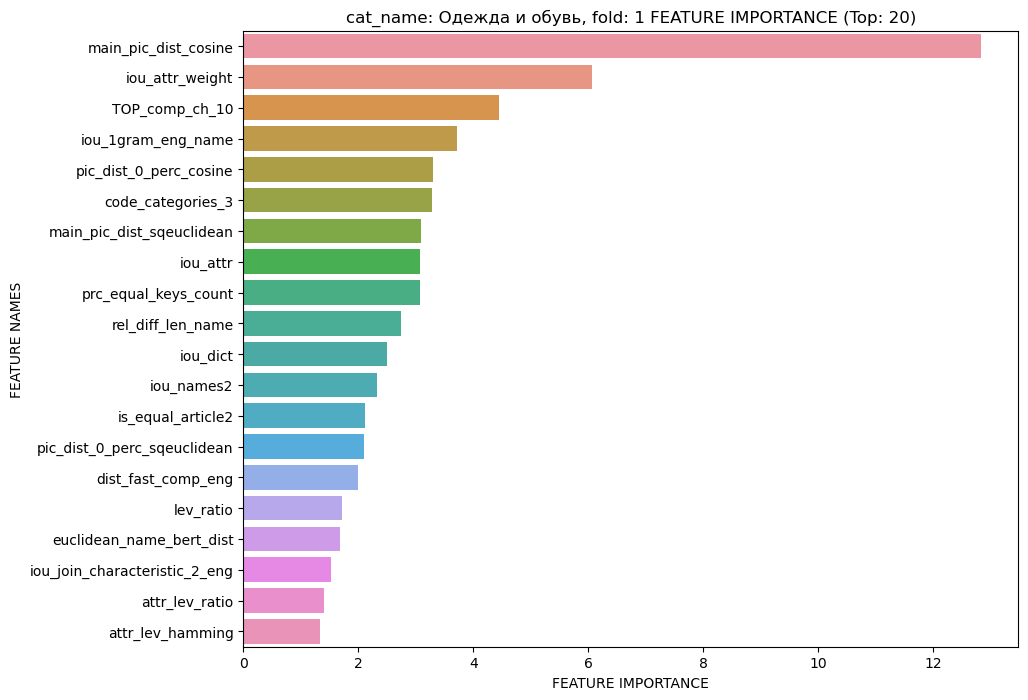

fold: 2
train_index: 934806, test_index: 233702
fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда
fold: 3
train_index: 934806, test_index: 233702


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда
fold: 4
train_index: 934807, test_index: 233701


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold_X_train: (934807, 313), fold_y_train: (934807,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда
fold: 5
train_index: 934807, test_index: 233701


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold_X_train: (934807, 313), fold_y_train: (934807,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

cat_name: EPG
Начало кросс-валидации, k_folds=5
fold: 1
train_index: 934806, test_index: 233702
fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

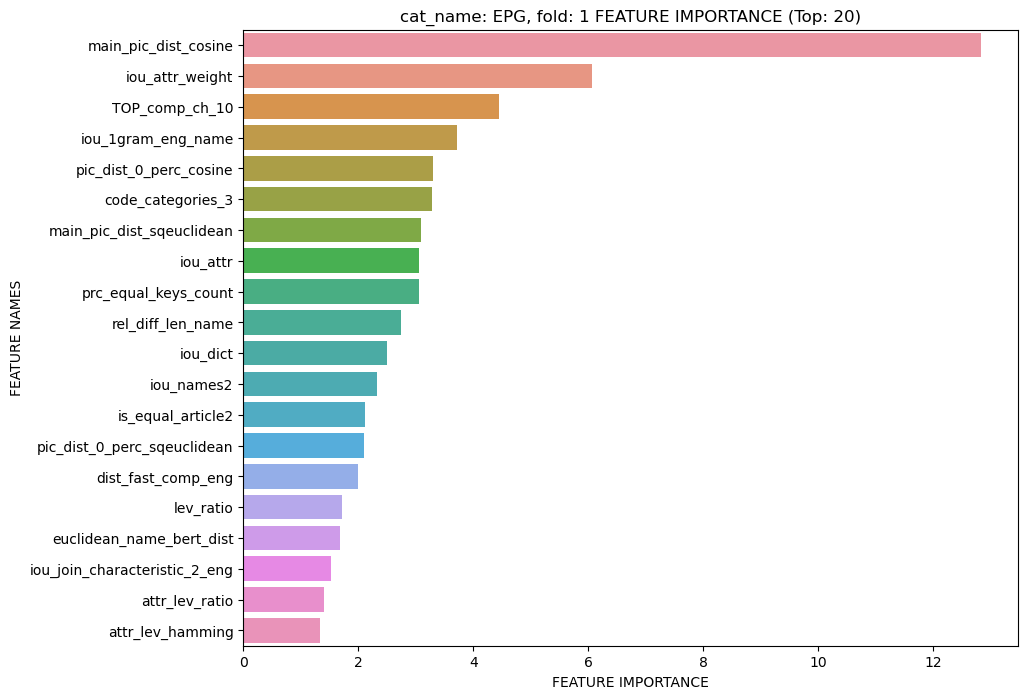

fold: 2
train_index: 934806, test_index: 233702
fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда
fold: 3
train_index: 934806, test_index: 233702


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда
fold: 4
train_index: 934807, test_index: 233701


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold_X_train: (934807, 313), fold_y_train: (934807,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда
fold: 5
train_index: 934807, test_index: 233701


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold_X_train: (934807, 313), fold_y_train: (934807,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

cat_name: Книги и цифровые книги
Начало кросс-валидации, k_folds=5
fold: 1
train_index: 934806, test_index: 233702
fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

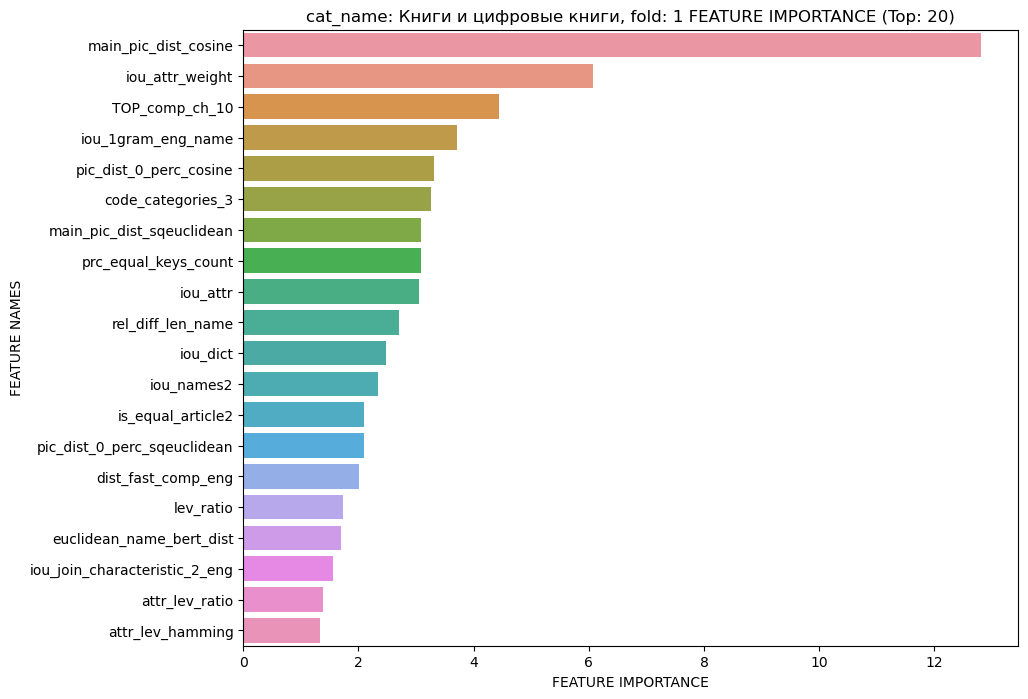

fold: 2
train_index: 934806, test_index: 233702
fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда
fold: 3
train_index: 934806, test_index: 233702


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold_X_train: (934806, 313), fold_y_train: (934806,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда
fold: 4
train_index: 934807, test_index: 233701


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold_X_train: (934807, 313), fold_y_train: (934807,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

fold: 5
train_index: 934807, test_index: 233701
fold_X_train: (934807, 313), fold_y_train: (934807,)
# Обучаем базовые модели


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


# Завершили обучение фолда


<timed exec>:60: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

CPU times: total: 9min 32s
Wall time: 4min 47s


In [860]:
%%time
# CPU (500 iter) 25 min 
# GPU (500 iter) 4 min
# GPU (8000 iter) 47 min
# GPU (500 iter) с категориальными признакми 18 min (из-за перевода названий в категории)
# GPU (500 iter) с категориальными признакми (только категории без навзваний) 11 min - При этом категории 3 и 4 которые имеют менее 100 объектов переведены группу rest и вместо названий введены ИД групп, для облегчения моделей 
# GPU (2000 iter) 13 min без категориальных фичей

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

models_by_cat_crossval = {}
k_folds = 5
for cat_name in union_features_df["cat_level_1_1"].unique():
    models_by_cat_crossval[cat_name] = []
    print(f'cat_name: {cat_name}')
    skf = StratifiedKFold(n_splits=k_folds, random_state=53, shuffle=True)
    predict_column = f'cv_predict'
    # Если в данных уже есть рассчитаное поле предикт, то удалем его
    train_df[predict_column] = np.nan
    cv_y_train = train_df[target_column]
    print(f'Начало кросс-валидации, k_folds={k_folds}')
    for i, (train_index, test_index) in enumerate(skf.split(train_df[features_columns], cv_y_train)):
        print(f'fold: {i+1}')
        print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
        
        fold_X_train = train_df[features_columns].iloc[train_index]
        fold_y_train = cv_y_train.iloc[train_index]
        print(f'fold_X_train: {fold_X_train.shape}, fold_y_train: {fold_y_train.shape}')

        # Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
        fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(
                                                                        fold_X_train, 
                                                                        fold_y_train, 
                                                                        test_size=0.05, 
                                                                        random_state=53)
        fold_X_test = train_df[features_columns].iloc[test_index]
        fold_y_test = cv_y_train.iloc[test_index]
        
        # Обучаем базовые модели
        fold_cv_model = CatBoostClassifier(iterations=500,
                    eval_metric =  "AUC", 
                    early_stopping_rounds=500, 
                    ignored_features=['variantid1', 'variantid2'],
                    # od_type = "Iter",
                    # od_wait = 200,                               
                    random_state=53,
                    task_type="GPU",
                    devices='0',
                    cat_features=cat_columns,
                    )
        print("# Обучаем базовые модели")
        fold_cv_model.fit(fold_X_train, fold_y_train,
                  eval_set=(fold_X_val, fold_y_val), 
                  plot=True, 
                  verbose=False 
                 )    
        models_by_cat_crossval[cat_name].append(fold_cv_model)
        print("# Завершили обучение фолда")
        # Делаем прогноз для фолдов
        train_df[predict_column].iloc[test_index] = fold_cv_model.predict_proba(fold_X_test)[:,1]
        # Выводим график важности признаков
        if i == 0:
            plot_feature_importance(fold_cv_model.get_feature_importance(), fold_X_train.columns, model_name=f'cat_name: {cat_name}, fold: {i+1}', top_n=20,)
            plt.show()

In [861]:
import pickle
cross_model_filename = 'cross_val_models_07_09_2024__vb8_4_2.pkl'
# Сохраняем модель
with open(cross_model_filename, 'wb') as file:
    pickle.dump(models_by_cat_crossval, file)

In [842]:
# %%time
# import tarfile
# tar = tarfile.open(f"{cross_model_filename}.tar.gz", "w:gz")
# tar.add(cross_model_filename)
# tar.close()

In [154]:
# import pickle
# with open('cross_val_models_03_09_2024__vb8_4.pkl', 'rb') as file:
#     models_by_cat_crossval = pickle.load(file)
# models_by_cat_crossval

In [33]:
%%time
X_train_val_df, X_test_df = train_test_split(
    train_df, 
    test_size=0.05, 
    random_state=53, 
    stratify=train_df[['cat_level_1_1', 'target']]
#     stratify=train_df[['cat_level_2_1', 'target']]
)
X_train_val_df.shape, X_test_df.shape

CPU times: total: 10.8 s
Wall time: 10.8 s


((1110082, 771), (58426, 771))

In [86]:
%%time
X_train_val_df, X_test_df = train_test_split(
    train_df, 
    test_size=0.01, 
    random_state=53, 
    stratify=train_df[['cat_level_1_1', 'target']]
#     stratify=train_df[['cat_level_2_1', 'target']]
)
X_train_val_df.shape, X_test_df.shape

CPU times: total: 14.9 s
Wall time: 14.9 s


((1156822, 771), (11686, 771))

Одежда и обувь


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


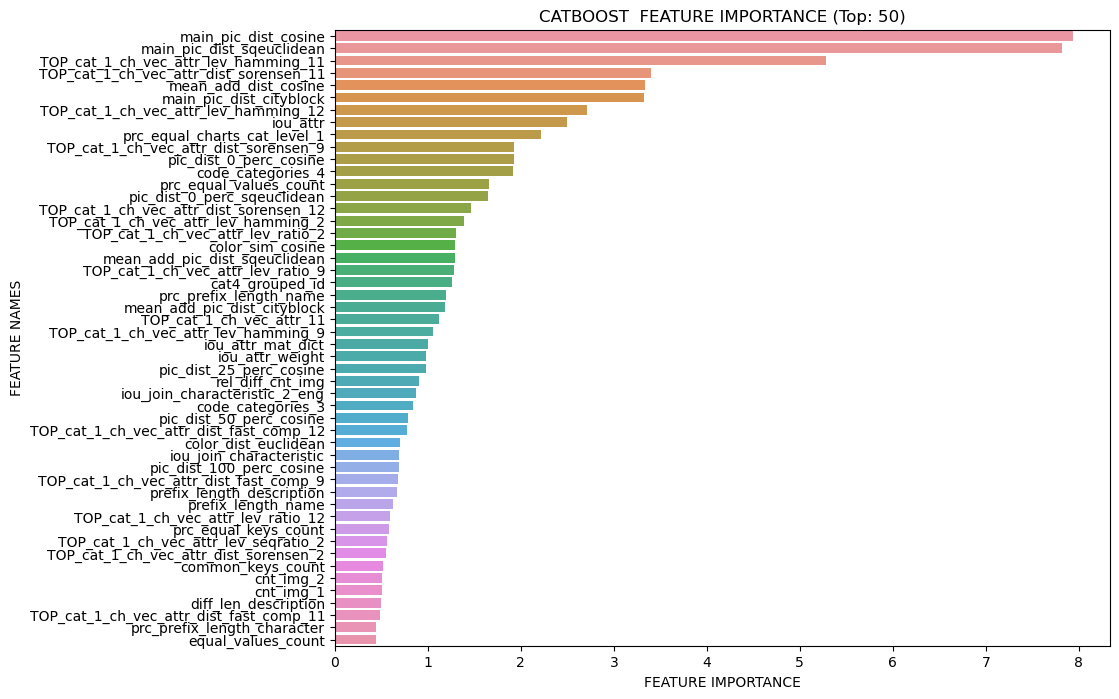

EPG


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


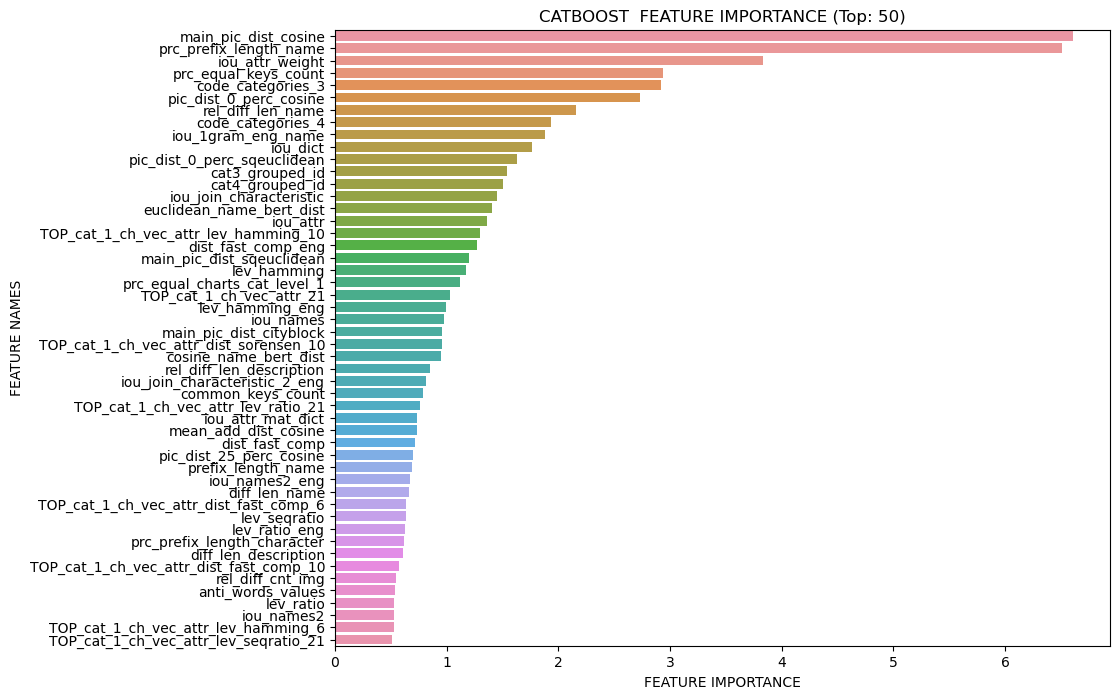

Книги и цифровые книги


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


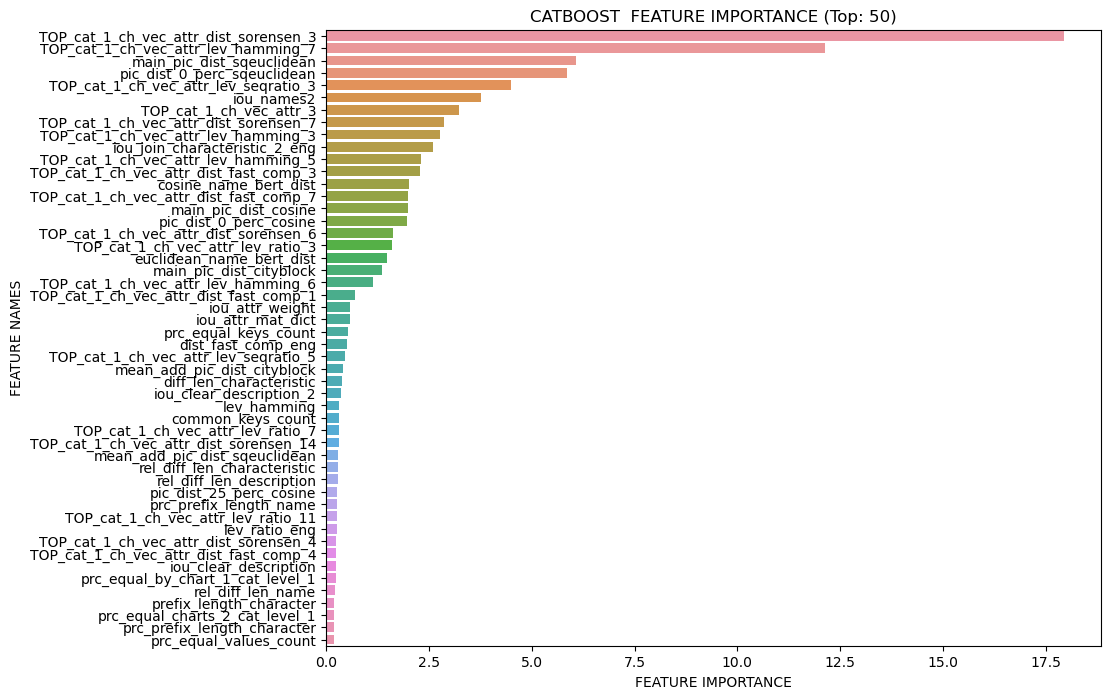

CPU times: total: 7min 17s
Wall time: 4min 5s


In [92]:
%%time

# Модель 26
# Одежда и обувь
# 0.9785115 / 0.1758349
# EPG
# 0.962727697 / 0.2446614
# Книги и цифровые книги
# 0.9562246 / 0.2584900


# # Модель 26 + исключены фичи BM25
# Одежда и обувь
# 0.97862186 / 0.175782344
# EPG
# 0.9627536 / 0.2443942
# Книги и цифровые книги
# 0.9569549 / 0.25677028

# Модель 26 + все фичи с перерасчетом на новой функции IoU + фичи на базе топ 100 схожих характеристик
# Одежда и обувь
# 0.9788964964/ 0.1738356
# EPG
# 0.9652386 / 0.23605510
# Книги и цифровые книги
# 0.95700011 / 0.255755338


# Модель 29 + переделан расчет фичей на базе топ 100 схожих характеристик
# Одежда и обувь
# 0.9787454 / 0.1746843
# EPG
# 0.9654758 / 0.2350615
# Книги и цифровые книги
# 0.9570559 / 0.2566721

# Модель 31 + исправлено деление текста по словам
# Одежда и обувь
# 0.9785693198 / 0.1753514
# EPG
# 0.9680002 / 0.2260063
# Книги и цифровые книги
# 0.9570038 / 0.2584383


# Модель 31 + исправлено деление текста по словам + исправлена ошибка опредления важных характеристик 
# Одежда и обувь
# 0.9792533 / 0.1725259
# EPG
# 0.96800020 / 0.2260063
# Книги и цифровые книги
# 0.961109804 / 0.2469585

# Модель 35 + исправлена ошибка опредления важных характеристик для топ 80 (было топ 40)
# Одежда и обувь
# 0.97931304 / 0.172117084
# EPG
# 0.96799988 / 0.2260534
# Книги и цифровые книги
# 0.9607019 / 0.2483240159

# Модель 36 + исправлены ошибки
# Одежда и обувь
# 0.979178908 / 0.1724482
# EPG
# 0.9681640 / 0.22529216
# Книги и цифровые книги
# 0.9611650181 / 0.2464426


# Модель 37 + фичи через кросс валидацию
# Одежда и обувь
# 0.9786400 / 0.1759270
# EPG
# 0.967766123 / 0.2270057
# Книги и цифровые книги
# 0.959425145 / 0.253161562

# Модель 39 + увеличено чиссло иттераций для  моделей кросс валидации с 500 до 8000 и основная модель с 8000 до 10000
# Одежда и обувь
# 0.978990376 / 0.1742687
# EPG
# 0.9675182 / 0.227931026
# Книги и цифровые книги
# 0.9588234425 / 0.25455945

# Модель 39 + BERT фичи 
# Одежда и обувь
# 0.9798251987 / 0.1680808
# EPG
# 0.9881978 / 0.1323430
# Книги и цифровые книги
# 0.9891203 / 0.11472484

# Модель 39 + Доп фичи над текстом + name1 name2 как категориальная фича + Категории как категориальная фича
# Одежда и обувь
# 0.980399280 / 0.1682753
# EPG
# 0.9684950113 / 0.2245482601
# Книги и цифровые книги
# 0.960323631 / 0.2486280

# Модель 39 + Доп фичи над текстом + Категории как категориальная фича (3 и 4 категории имеют подгруппу прочее)
# Одежда и обувь
# 0.979101657 / 0.1732968387
# EPG
# 0.96782118 / 0.22716331
# Книги и цифровые книги
# 0.9606279 / 0.2481396656

# Модель 43  + исключены категориальные признаки + BERT фичи
# Одежда и обувь
# 0.9810087681 / 0.1660270623
# EPG
# 0.976879119 / 0.190699046
# Книги и цифровые книги
# 0.97604650 / 0.18983746

# Модель 43  + BERT v3 + исключены категориальные признаки + добавлены новые фичи
# Одежда и обувь
# 0.980886519 / 0.1661450045
# EPG
# 0.987914264 / 0.1333414144
# Книги и цифровые книги
# 0.99250465 / 0.104173026

# Модель 43  + исключены категориальные признаки + добавлены новые фичи + исключен bert
# Одежда и обувь
# 0.979126215 / 0.17364813
# EPG
# 0.9663540721 / 0.2322186977
# Книги и цифровые книги
# 0.9591723084 / 0.2537634696

# Модель 46  + исключен стекинг
# Одежда и обувь
# 0.97916445 / 0.17344223
# EPG
# 0.965826869 / 0.234599717
# Книги и цифровые книги
# 0.961424171 / 0.245402938

# Модель 46  + Добавлены категориальные фичи: ['cat3_grouped_id', 'cat4_grouped_id']
# Одежда и обувь
# 0.9791937768 / 0.1732106585
# EPG
# 0.968220651 / 0.2255229783
# Книги и цифровые книги
# 0.9593059421 / 0.252910929

# Модель 46  + Добавлены фичи: ['cat3_grouped_id', 'cat4_grouped_id'] не как категории
# Одежда и обувь
# 0.9793245792 / 0.172810354
# EPG
# 0.966870784 / 0.2304152859
# Книги и цифровые книги
# 0.95961964 / 0.2522537065

# Модель 49  + исключен стекинг
# Одежда и обувь
# 0.979199349 / 0.172868512
# EPG
# 0.9662628174 / 0.23304823
# Книги и цифровые книги
# 0.961404085 / 0.245011756

# Модель 49 + стекинг + исключены и добавлены фичи и обрезаны фичи по характеристикам до 40
# Одежда и обувь
# 0.9793821573 / 0.1724034
# EPG
# 0.966134131 / 0.233047733
# Книги и цифровые книги
# 0.9590825438 / 0.252045772

# Модель 50 + исключен стекинг + исключены фичи 
# Одежда и обувь
# 0.97910737 / 0.173278857
# EPG
# 0.965843021 / 0.234377277
# Книги и цифровые книги
# 0.9613896 / 0.24515751

# Модель 37 + воспроизводим Модель 37
# Одежда и обувь
# 0.9792057 / 0.1730008297
# EPG
# 0.966023594 / 0.2339075306
# Книги и цифровые книги
# 0.9609887004 / 0.2464451306

# Модель 53 + категориальные признаки категорий частотные от Димы
# Одежда и обувь
# 0.97910910 / 0.173683544
# EPG
# 0.966231048 / 0.23284007
# Книги и цифровые книги
# 0.9589087963 / 0.25164375

# Модель 53 + переписаны фичи по характеристикам
# Одежда и обувь
# 0.98041501 / 0.1665762
# EPG
# 0.966086328 / 0.233538814
# Книги и цифровые книги
# 0.963213563 / 0.239071279

# Модель 53 + переписаны фичи по характеристикам (10000 иттераций)
# Одежда и обувь
# 0.98015993 / 0.16783126
# EPG
# 0.9666131139 / 0.23154800
# Книги и цифровые книги
# 0.96287918 / 0.239585936

# Модель 57 + исправлены ошибки в генерации фичей на тесте и трейне 
# Одежда и обувь
# 0.980161428 / 0.1667360
# EPG
# 0.9659101 / 0.2341748
# Книги и цифровые книги
# 0.962807655 / 0.2397910846

# Модель 58 + доабвлены фичи + модели по второй категории (20 штук)
# Одежда и обувь
# 0.980219870 / 0.1667118
# EPG
# 0.9661878347 / 0.233211723
# Книги и цифровые книги
# 0.9632731 / 0.2386306


# Модель 63 + Изменены гиперпарамтеры и уменьешены валиадция и локальный тест в пользу трейна
# 0.980473369 / 0.1683645101
# EPG
# 0.969619751 / 0.220495363
# Книги и цифровые книги
# 0.9714856148 / 0.2085056573

# Модель __
# Одежда и обувь
# 
# EPG
# 
# Книги и цифровые книги
# 

# from catboost import CatBoostRegressor
def train_test_split_by_cat(full_df, cat_name:str):
    full_df = full_df[full_df['cat_level_1_1'] == cat_name]
    X_train_df, X_val_df = train_test_split(
        full_df, 
        test_size=0.02, 
        random_state=53, 
        stratify=full_df["target"]
    )
    # X_train_df = full_df
    return X_train_df, X_val_df

models_by_cat = {}
for cat_name in train_df["cat_level_1_1"].unique():
    print(cat_name)
    # Определяем модель
    model = CatBoostClassifier(iterations=8000,
                    eval_metric =  "AUC", 
                    early_stopping_rounds=500, 
                    ignored_features=['variantid1', 'variantid2'],
                    cat_features=cat_columns,
                    # od_type = "Iter",
                    # od_wait = 200,                               
                    random_state=53,
                    task_type="GPU",
                    devices='0',
                    learning_rate = 0.1
                    )
#     model = CatBoostRegressor(iterations=8000,
#                     eval_metric="MAE",
#                     loss_function='RMSE',
#                     early_stopping_rounds=500, 
#                     ignored_features=['variantid1', 'variantid2'],
#                     # od_type = "Iter",
#                     # od_wait = 200,                               
#                     random_state=53,
#                     )    
    
    # Формируем выборку данных под категорию
    X_train_df, X_val_df = train_test_split_by_cat(full_df=X_train_val_df, cat_name=cat_name)
    
#     X_train = X_train_df[features_columns + ['cv_predict']]
    X_train = X_train_df[features_columns]
    y_train = X_train_df[target_column]

#     X_val = X_val_df[features_columns + ['cv_predict']]
    X_val = X_val_df[features_columns]
    y_val = X_val_df[target_column]
    
    # Обучаем модель
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val), 
              plot=True, 
              verbose=False 
             )
    
#     plot_feature_importance(model.get_feature_importance(), (features_columns + ['cv_predict']),'CATBOOST ', top_n=50)
    plot_feature_importance(model.get_feature_importance(), (features_columns ),'CATBOOST ', top_n=50)
    plt.show()
    models_by_cat[cat_name] = model

In [73]:
# kv_idf_by_models.keys()#['Книги и цифровые книги'][1][3]

In [74]:
# kv_idf_by_models['Книги и цифровые книги'][1]

In [780]:
# fi_df = plot_feature_importance(model.get_feature_importance(), (features_columns),'CATBOOST ', top_n=50)
# fi_df.shape

In [781]:
# fi_df[:100] 
# # attr_2_gram
# # 'lev_hamming',  'lev_ratio',  'dist_sorensen',  'lev_seqratio',  'dist_fast_comp',
# # 'prefix_length_name', 'prc_prefix_length_name', 'prefix_length_description', 'prc_prefix_length_description', 'prefix_length_character', 'prc_prefix_length_character',
# # 'is_equal_description', 'is_equal_name', 'is_equal_characteristic', 
# # is_equal_article2
# # 'is_equal_cat_1',  'is_equal_cat_2',  'is_equal_cat_3',  'is_equal_cat_4'

In [787]:
# model.feature_names_
# list(np.array(model.feature_names_)[model.get_cat_feature_indices()])


In [93]:
import pickle
# model_filename = 'triple_model_cat_1_08_09_2024__vb9_1_2.pkl'
model_filename = 'cat_1__3_models_08_09_2024__vb9_1_3.pkl'
# Сохраняем модель
with open(model_filename, 'wb') as file:
    pickle.dump(models_by_cat, file)

In [94]:
# import pickle
# # model_filename = 'triple_model_cat_1_08_09_2024__vb9_1_2.pkl'
# model_filename = 'cat_1__3_models_08_09_2024__vb9_1_2.pkl'
# # Загружаем anti_words
# with open(model_filename, 'rb') as file:
#     models_by_cat = pickle.load(file)

In [95]:
# %%time
# import tarfile
# tar = tarfile.open(f"{model_filename}.tar.gz", "w:gz")
# tar.add(model_filename)
# tar.close()

In [96]:
len(features_columns)

373

In [97]:
for cat in models_by_cat.keys():
    X_test_df.loc[X_test_df['cat_level_1_1'] == cat, 'predict_cat_1'] = models_by_cat[cat].predict_proba(X_test_df[X_test_df['cat_level_1_1'] == cat][features_columns])[:,1]
#     X_test_df.loc[X_test_df['cat_level_1_1'] == cat, 'predict'] = models_by_cat[cat].predict_proba(X_test_df[X_test_df['cat_level_1_1'] == cat][features_columns + ['cv_predict']])[:,1]
#     X_test_df.loc[X_test_df['cat_level_1_1'] == cat, 'predict'] = models_by_cat[cat].predict_proba(X_test_df[X_test_df['cat_level_1_1'] == cat][features_columns])[:,1]
#     X_test_df.loc[X_test_df['cat_level_1_1'] == cat, 'predict'] = models_by_cat[cat].predict(X_test_df[X_test_df['cat_level_1_1'] == cat][features_columns])
# X_test_df['predict'] = X_test_df['predict'].clip(0,1)    
X_test_df.shape    

(11686, 773)

In [178]:
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

In [ ]:
# 
calculate_macro_prauc_by_category(result_test_df, categories)

In [179]:
# только модель по 1му уровню Модель 58 + доабвлены фичи + модели по второй категории (20 штук) 
calculate_macro_prauc_by_category(result_test_df, categories)

0.9594172508977383

In [164]:
# Модель 57 + исправлены ошибки в генерации фичей на тесте и трейне 
calculate_macro_prauc_by_category(result_test_df, categories)

0.9593083488262136

In [70]:
# Модель 53 + переписаны фичи по характеристикам (12000 иттераций)
calculate_macro_prauc_by_category(result_test_df, categories)

0.9601320731563778

In [63]:
# Модель 53 + переписаны фичи по характеристикам
calculate_macro_prauc_by_category(result_test_df, categories)

0.9595485420767295

In [82]:
# Модель 53 + разбивка модели на 20 штук по кол-ву категорий второго уровня 
calculate_macro_prauc_by_category(result_test_df, categories)

0.9600610600362467

In [87]:
# Модель 53 + разбивка модели на 20 штук по кол-ву категорий второго уровня 
calculate_macro_prauc_by_category(result_test_df, categories)

0.9813815389731021

In [872]:
# Модель 53 + категориальные признаки категорий частотные от Димы
calculate_macro_prauc_by_category(result_test_df, categories)

0.9588157087809712

In [786]:
# Модель 37 + воспроизводим Модель 37
calculate_macro_prauc_by_category(result_test_df, categories)

0.9589412781629203

In [732]:
# Модель 50 + исключен стекинг + исключены фичи 
calculate_macro_prauc_by_category(result_test_df, categories)

0.958656255451108

In [696]:
# Модель 49 + стекинг + исключены и добавлены фичи и обрезаны фичи по характеристикам до 40
calculate_macro_prauc_by_category(result_test_df, categories)

0.9584008070388881

In [616]:
# Модель 49  + исключен стекинг
calculate_macro_prauc_by_category(result_test_df, categories)

0.9592137735033109

In [605]:
# Модель 46  + Добавлены фичи: ['cat3_grouped_id', 'cat4_grouped_id'] не как категории
calculate_macro_prauc_by_category(result_test_df, categories)

0.9592541254030378

In [578]:
# Модель 46  + Добавлены категориальные фичи: ['cat3_grouped_id', 'cat4_grouped_id']
calculate_macro_prauc_by_category(result_test_df, categories)

0.960611813984633

In [498]:
# Модель 46  + исключен стекинг
calculate_macro_prauc_by_category(result_test_df, categories)

0.9588200654207666

In [489]:
# Модель 43  + исключены категориальные признаки + добавлены новые фичи + исключен bert
calculate_macro_prauc_by_category(result_test_df, categories)

0.9588844056246684

In [445]:
# Модель 43  + BERT v3 + исключены категориальные признаки + добавлены новые фичи
calculate_macro_prauc_by_category(result_test_df, categories)

0.9844116186453824

In [370]:
# Модель 43  + исключены категориальные признаки + BERT фичи
calculate_macro_prauc_by_category(result_test_df, categories)

0.9717006513470787

In [344]:
# Модель 39 + Доп фичи над текстом + Категории как категориальная фича (3 и 4 категории имеют подгруппу прочее)
calculate_macro_prauc_by_category(result_test_df, categories)

0.960134575584408

In [210]:
# Модель 39 + Доп фичи над текстом + name1 name2 как категориальная фича + Категории как категориальная фича
calculate_macro_prauc_by_category(result_test_df, categories)

0.9611005093877845

In [57]:
# Модель 39 + BERT фичи 
calculate_macro_prauc_by_category(result_test_df, categories)

0.9849294454986666

In [33]:
# Модель 39 + увеличено чиссло иттераций для  моделей кросс валидации с 500 до 8000 и основная модель с 8000 до 10000
calculate_macro_prauc_by_category(result_test_df, categories)

0.9602037857827478

In [239]:
# Модель 37 + фичи через кросс валидацию
calculate_macro_prauc_by_category(result_test_df, categories)

0.9603728566445596

In [208]:
# Модель 37 + RMSE
calculate_macro_prauc_by_category(result_test_df, categories)

0.9575613247257687

In [194]:
# Модель 36 + исправлены ошибки
calculate_macro_prauc_by_category(result_test_df, categories)

0.9612430841814046

In [184]:
# Модель 35 + исправлена ошибка опредления важных характеристик для топ 80 (было топ 40)
calculate_macro_prauc_by_category(result_test_df, categories)

0.9606956286704591

In [141]:
# Модель 29 + переделан расчет фичей на базе топ 100 схожих характеристик
calculate_macro_prauc_by_category(result_test_df, categories)

0.9575870148247004

In [107]:
# Модель 29 + валидация добавлена в состав обучающей выборки
calculate_macro_prauc_by_category(result_test_df, categories)

0.9562270909378396

In [100]:
# Модель 26 + все фичи с перерасчетом на новой функции IoU + фичи на базе топ 100 схожих характеристик
calculate_macro_prauc_by_category(result_test_df, categories)

0.9571449633042681

In [45]:
# Старая Модель 7 + фичи на базе топ 100 схожих характеристик
calculate_macro_prauc_by_category(result_test_df, categories)

0.9562061975292705

In [219]:
# Модель 26 + исключены фичи BM25
calculate_macro_prauc_by_category(result_test_df, categories)

0.9542594176826625

In [203]:
# Модель 24 + обучание трех моделей каждая под свою категорию 1го уровня
calculate_macro_prauc_by_category(result_test_df, categories)

0.9537768364146251

# Общая модель

In [87]:
len(features_columns_one_model)

128

In [37]:
X_train_val_df['sample_weights'] = 1
# повышаем вес у примеров
X_train_val_df.loc[(X_train_val_df['name1'] != X_train_val_df['name2']) & (X_train_val_df['iou_names'] < 0.7)&(X_train_val_df['target'] == 1), 'sample_weights'] = 2
X_train_val_df.loc[(X_train_val_df['name1'] == X_train_val_df['name2']) & (X_train_val_df['target'] == 0), 'sample_weights'] = 2
# X_train_val_df[(X_train_val_df['name1'] != X_train_val_df['name2']) & (X_train_val_df['iou_names'] < 0.7)&(X_train_val_df['target'] == 1)]
# X_train_val_df[(X_train_val_df['name1'] == X_train_val_df['name2']) & (X_train_val_df['target'] == 0)].shape

In [302]:
# X_train_val_df['sample_weights']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


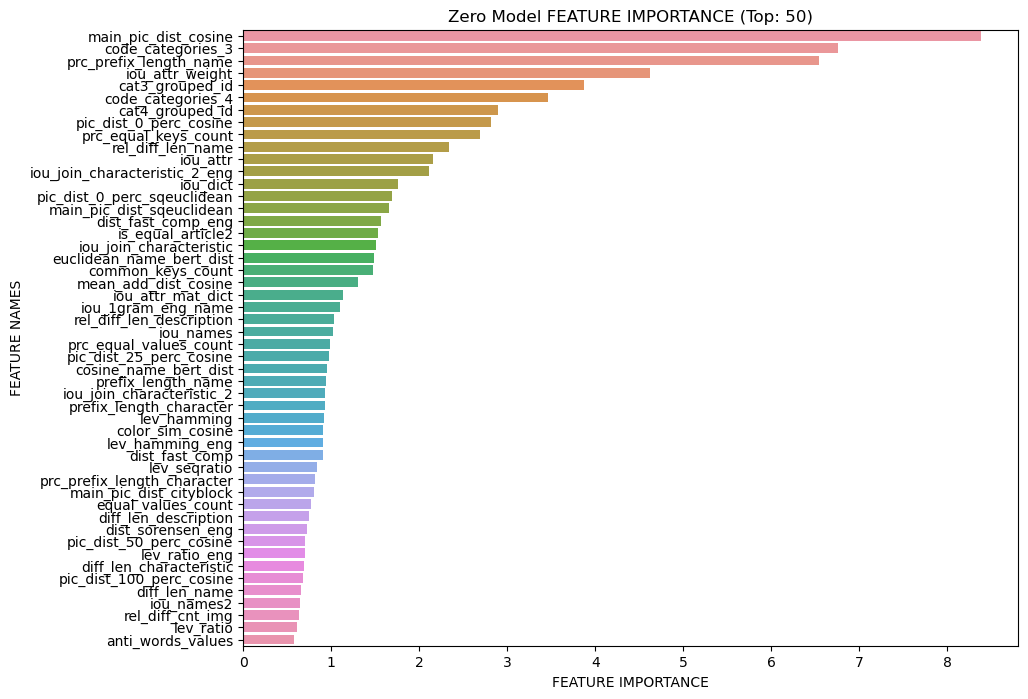

CPU times: total: 6min 17s
Wall time: 3min 48s


In [88]:
%%time
# Подбор гипермаратров
# по умолчанию: 0.964057624 / 0.2420194
# learning_rate = 0.1: 0.9671152 / 0.23015267
# Изменены веса для объектов:  0.9602493 / 0.255341913
# Изменены веса для объектов:  0.9602493 / 0.255341913
# Изменены гиперпарамтеры и уменьешены валиадция и локальный тест в пользу трейна: 0.9676946104 / 0.2284820
model_by_cat_level_zero = CatBoostClassifier(iterations=12000,
                eval_metric =  "AUC", 
                early_stopping_rounds=500, 
                ignored_features=['variantid1', 'variantid2'],
                cat_features=cat_columns,
                # od_type = "Iter",
                # od_wait = 200,                               
                random_state=53,
                task_type="GPU",
                devices='0',
                learning_rate = 0.1,
                
                )
zero_X_train_df, zero_X_val_df = train_test_split(
    X_train_val_df, 
    test_size=0.02, 
    random_state=53, 
    stratify=X_train_val_df["target"]
)
zero_X_train = zero_X_train_df[features_columns_one_model]
zero_y_train = zero_X_train_df[target_column]
zero_X_val = zero_X_val_df[features_columns_one_model ]
zero_y_val = zero_X_val_df[target_column]
    
# Обучаем модель
model_by_cat_level_zero.fit(zero_X_train, zero_y_train,
          eval_set=(zero_X_val, zero_y_val), 
          plot=True, 
          verbose=False,
#           sample_weight = zero_X_train_df['sample_weights'],
         )
plot_feature_importance(model_by_cat_level_zero.get_feature_importance(), (features_columns_one_model ),f'Zero Model', top_n=50)
plt.show()


In [ ]:
# model_by_cat_level_zero.get_all_params()

In [288]:
# %%time
# import numpy as np
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import make_classification
# from catboost import CatBoostClassifier

# # Генерация примера данных
# # X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
# #                            n_redundant=5, random_state=42)
# sample_X_train_val_df = X_train_val_df.sample(100_000)
# X = sample_X_train_val_df[features_columns_one_model]
# y = sample_X_train_val_df[target_column]
# # Определение пространства поиска гиперпараметров
# param_grid = {
#     'learning_rate': [0.08, 0.1, 0.15, 0.2],
# #     'depth': [4, 6, 8, 10],
# #     'l2_leaf_reg': [1, 3, 5, 7, 9],
# #     'border_count': [32, 64, 128, 256],
# #     'bagging_temperature': [0, 0.5, 1, 1.5],
# #     'random_strength': [1, 10, 100]
# }

# grid_model = CatBoostClassifier(
#                 eval_metric =  "AUC", 
#                 loss_function='Logloss',
# #                 ignored_features=['variantid1', 'variantid2'],
#                 random_state=53,
#                 task_type="GPU",
#                 devices='0',
#                 )

# # Настройка и запуск GridSearchCV
# grid_search = GridSearchCV(estimator=grid_model, param_grid=param_grid, 
#                            cv=3, scoring='roc_auc', verbose=1)
# grid_search.fit(X, y)

# # Вывод лучших параметров и оценки
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшая оценка ROC AUC:", grid_search.best_score_)

# # Использование лучшей модели
# best_model = grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.95ms	remaining: 7.94s
1:	total: 14.3ms	remaining: 7.16s
2:	total: 20.7ms	remaining: 6.89s
3:	total: 27ms	remaining: 6.73s
4:	total: 33.7ms	remaining: 6.71s
5:	total: 40.2ms	remaining: 6.67s
6:	total: 46.9ms	remaining: 6.65s
7:	total: 52.9ms	remaining: 6.56s
8:	total: 59.1ms	remaining: 6.51s
9:	total: 65.3ms	remaining: 6.46s
10:	total: 71.7ms	remaining: 6.45s
11:	total: 77.9ms	remaining: 6.42s
12:	total: 84.1ms	remaining: 6.38s
13:	total: 90.3ms	remaining: 6.36s
14:	total: 96.3ms	remaining: 6.33s
15:	total: 103ms	remaining: 6.32s
16:	total: 109ms	remaining: 6.3s
17:	total: 115ms	remaining: 6.28s
18:	total: 121ms	remaining: 6.26s
19:	total: 127ms	remaining: 6.24s
20:	total: 134ms	remaining: 6.24s
21:	total: 140ms	remaining: 6.24s
22:	total: 147ms	remaining: 6.24s
23:	total: 153ms	remaining: 6.23s
24:	total: 160ms	remaining: 6.22s
25:	total: 166ms	remaining: 6.21s
26:	total: 172ms	remaining: 6.2s
27:	total: 178ms	remaining: 6.19s
28:	total: 184ms	remaining: 6.17s
29:	total: 19

254:	total: 1.66s	remaining: 4.84s
255:	total: 1.66s	remaining: 4.84s
256:	total: 1.67s	remaining: 4.83s
257:	total: 1.68s	remaining: 4.83s
258:	total: 1.68s	remaining: 4.82s
259:	total: 1.69s	remaining: 4.81s
260:	total: 1.7s	remaining: 4.8s
261:	total: 1.7s	remaining: 4.8s
262:	total: 1.71s	remaining: 4.79s
263:	total: 1.72s	remaining: 4.78s
264:	total: 1.72s	remaining: 4.77s
265:	total: 1.73s	remaining: 4.77s
266:	total: 1.73s	remaining: 4.76s
267:	total: 1.74s	remaining: 4.76s
268:	total: 1.75s	remaining: 4.75s
269:	total: 1.75s	remaining: 4.74s
270:	total: 1.76s	remaining: 4.74s
271:	total: 1.77s	remaining: 4.73s
272:	total: 1.77s	remaining: 4.72s
273:	total: 1.78s	remaining: 4.71s
274:	total: 1.78s	remaining: 4.7s
275:	total: 1.79s	remaining: 4.7s
276:	total: 1.8s	remaining: 4.69s
277:	total: 1.8s	remaining: 4.68s
278:	total: 1.81s	remaining: 4.68s
279:	total: 1.81s	remaining: 4.67s
280:	total: 1.82s	remaining: 4.66s
281:	total: 1.83s	remaining: 4.66s
282:	total: 1.83s	remaining:

512:	total: 3.54s	remaining: 3.35s
513:	total: 3.54s	remaining: 3.35s
514:	total: 3.55s	remaining: 3.34s
515:	total: 3.56s	remaining: 3.33s
516:	total: 3.56s	remaining: 3.33s
517:	total: 3.57s	remaining: 3.32s
518:	total: 3.57s	remaining: 3.31s
519:	total: 3.58s	remaining: 3.31s
520:	total: 3.59s	remaining: 3.3s
521:	total: 3.59s	remaining: 3.29s
522:	total: 3.6s	remaining: 3.28s
523:	total: 3.61s	remaining: 3.28s
524:	total: 3.62s	remaining: 3.27s
525:	total: 3.62s	remaining: 3.26s
526:	total: 3.63s	remaining: 3.26s
527:	total: 3.63s	remaining: 3.25s
528:	total: 3.64s	remaining: 3.24s
529:	total: 3.65s	remaining: 3.24s
530:	total: 3.66s	remaining: 3.23s
531:	total: 3.66s	remaining: 3.22s
532:	total: 3.67s	remaining: 3.21s
533:	total: 3.68s	remaining: 3.21s
534:	total: 3.68s	remaining: 3.2s
535:	total: 3.69s	remaining: 3.2s
536:	total: 3.7s	remaining: 3.19s
537:	total: 3.7s	remaining: 3.18s
538:	total: 3.71s	remaining: 3.17s
539:	total: 3.72s	remaining: 3.17s
540:	total: 3.72s	remainin

750:	total: 5.19s	remaining: 1.72s
751:	total: 5.2s	remaining: 1.72s
752:	total: 5.21s	remaining: 1.71s
753:	total: 5.21s	remaining: 1.7s
754:	total: 5.22s	remaining: 1.69s
755:	total: 5.23s	remaining: 1.69s
756:	total: 5.23s	remaining: 1.68s
757:	total: 5.24s	remaining: 1.67s
758:	total: 5.25s	remaining: 1.67s
759:	total: 5.25s	remaining: 1.66s
760:	total: 5.26s	remaining: 1.65s
761:	total: 5.27s	remaining: 1.65s
762:	total: 5.27s	remaining: 1.64s
763:	total: 5.28s	remaining: 1.63s
764:	total: 5.29s	remaining: 1.62s
765:	total: 5.29s	remaining: 1.62s
766:	total: 5.3s	remaining: 1.61s
767:	total: 5.31s	remaining: 1.6s
768:	total: 5.31s	remaining: 1.6s
769:	total: 5.32s	remaining: 1.59s
770:	total: 5.33s	remaining: 1.58s
771:	total: 5.33s	remaining: 1.57s
772:	total: 5.34s	remaining: 1.57s
773:	total: 5.34s	remaining: 1.56s
774:	total: 5.35s	remaining: 1.55s
775:	total: 5.36s	remaining: 1.55s
776:	total: 5.37s	remaining: 1.54s
777:	total: 5.37s	remaining: 1.53s
778:	total: 5.38s	remaini

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.11ms	remaining: 8.1s
1:	total: 15.1ms	remaining: 7.53s
2:	total: 21.7ms	remaining: 7.23s
3:	total: 27.9ms	remaining: 6.95s
4:	total: 34.5ms	remaining: 6.87s
5:	total: 41.8ms	remaining: 6.92s
6:	total: 48.7ms	remaining: 6.91s
7:	total: 55ms	remaining: 6.82s
8:	total: 61.3ms	remaining: 6.75s
9:	total: 67.5ms	remaining: 6.68s
10:	total: 73.8ms	remaining: 6.63s
11:	total: 80.1ms	remaining: 6.59s
12:	total: 86.2ms	remaining: 6.54s
13:	total: 92.7ms	remaining: 6.53s
14:	total: 98.8ms	remaining: 6.49s
15:	total: 106ms	remaining: 6.5s
16:	total: 112ms	remaining: 6.47s
17:	total: 118ms	remaining: 6.46s
18:	total: 125ms	remaining: 6.44s
19:	total: 131ms	remaining: 6.41s
20:	total: 137ms	remaining: 6.39s
21:	total: 143ms	remaining: 6.37s
22:	total: 150ms	remaining: 6.35s
23:	total: 156ms	remaining: 6.33s
24:	total: 162ms	remaining: 6.31s
25:	total: 168ms	remaining: 6.31s
26:	total: 175ms	remaining: 6.29s
27:	total: 182ms	remaining: 6.32s
28:	total: 188ms	remaining: 6.3s
29:	total: 195

261:	total: 1.68s	remaining: 4.73s
262:	total: 1.69s	remaining: 4.72s
263:	total: 1.69s	remaining: 4.72s
264:	total: 1.7s	remaining: 4.71s
265:	total: 1.71s	remaining: 4.71s
266:	total: 1.71s	remaining: 4.7s
267:	total: 1.72s	remaining: 4.69s
268:	total: 1.72s	remaining: 4.69s
269:	total: 1.73s	remaining: 4.68s
270:	total: 1.74s	remaining: 4.67s
271:	total: 1.74s	remaining: 4.67s
272:	total: 1.75s	remaining: 4.66s
273:	total: 1.76s	remaining: 4.66s
274:	total: 1.76s	remaining: 4.65s
275:	total: 1.77s	remaining: 4.64s
276:	total: 1.78s	remaining: 4.64s
277:	total: 1.78s	remaining: 4.63s
278:	total: 1.79s	remaining: 4.62s
279:	total: 1.79s	remaining: 4.61s
280:	total: 1.8s	remaining: 4.61s
281:	total: 1.81s	remaining: 4.6s
282:	total: 1.81s	remaining: 4.6s
283:	total: 1.82s	remaining: 4.59s
284:	total: 1.83s	remaining: 4.58s
285:	total: 1.83s	remaining: 4.58s
286:	total: 1.84s	remaining: 4.57s
287:	total: 1.84s	remaining: 4.56s
288:	total: 1.85s	remaining: 4.55s
289:	total: 1.86s	remaini

510:	total: 3.35s	remaining: 3.21s
511:	total: 3.36s	remaining: 3.2s
512:	total: 3.37s	remaining: 3.2s
513:	total: 3.37s	remaining: 3.19s
514:	total: 3.38s	remaining: 3.18s
515:	total: 3.39s	remaining: 3.18s
516:	total: 3.39s	remaining: 3.17s
517:	total: 3.4s	remaining: 3.16s
518:	total: 3.4s	remaining: 3.15s
519:	total: 3.41s	remaining: 3.15s
520:	total: 3.42s	remaining: 3.14s
521:	total: 3.42s	remaining: 3.13s
522:	total: 3.43s	remaining: 3.13s
523:	total: 3.44s	remaining: 3.12s
524:	total: 3.44s	remaining: 3.11s
525:	total: 3.45s	remaining: 3.11s
526:	total: 3.45s	remaining: 3.1s
527:	total: 3.46s	remaining: 3.09s
528:	total: 3.47s	remaining: 3.09s
529:	total: 3.47s	remaining: 3.08s
530:	total: 3.48s	remaining: 3.07s
531:	total: 3.49s	remaining: 3.07s
532:	total: 3.49s	remaining: 3.06s
533:	total: 3.5s	remaining: 3.05s
534:	total: 3.5s	remaining: 3.05s
535:	total: 3.51s	remaining: 3.04s
536:	total: 3.52s	remaining: 3.03s
537:	total: 3.52s	remaining: 3.02s
538:	total: 3.53s	remaining

765:	total: 5.02s	remaining: 1.53s
766:	total: 5.03s	remaining: 1.53s
767:	total: 5.03s	remaining: 1.52s
768:	total: 5.04s	remaining: 1.51s
769:	total: 5.04s	remaining: 1.51s
770:	total: 5.05s	remaining: 1.5s
771:	total: 5.06s	remaining: 1.49s
772:	total: 5.07s	remaining: 1.49s
773:	total: 5.07s	remaining: 1.48s
774:	total: 5.08s	remaining: 1.48s
775:	total: 5.09s	remaining: 1.47s
776:	total: 5.09s	remaining: 1.46s
777:	total: 5.1s	remaining: 1.46s
778:	total: 5.11s	remaining: 1.45s
779:	total: 5.12s	remaining: 1.44s
780:	total: 5.12s	remaining: 1.44s
781:	total: 5.13s	remaining: 1.43s
782:	total: 5.13s	remaining: 1.42s
783:	total: 5.14s	remaining: 1.42s
784:	total: 5.15s	remaining: 1.41s
785:	total: 5.16s	remaining: 1.4s
786:	total: 5.16s	remaining: 1.4s
787:	total: 5.17s	remaining: 1.39s
788:	total: 5.17s	remaining: 1.38s
789:	total: 5.18s	remaining: 1.38s
790:	total: 5.19s	remaining: 1.37s
791:	total: 5.19s	remaining: 1.36s
792:	total: 5.2s	remaining: 1.36s
793:	total: 5.21s	remaini

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.51ms	remaining: 7.5s
1:	total: 14.2ms	remaining: 7.11s
2:	total: 20.6ms	remaining: 6.83s
3:	total: 26.8ms	remaining: 6.67s
4:	total: 32.8ms	remaining: 6.54s
5:	total: 39.1ms	remaining: 6.48s
6:	total: 45.2ms	remaining: 6.41s
7:	total: 51.3ms	remaining: 6.36s
8:	total: 57.8ms	remaining: 6.36s
9:	total: 64.1ms	remaining: 6.35s
10:	total: 70.4ms	remaining: 6.33s
11:	total: 77.5ms	remaining: 6.38s
12:	total: 84.9ms	remaining: 6.44s
13:	total: 92.3ms	remaining: 6.5s
14:	total: 99.2ms	remaining: 6.52s
15:	total: 106ms	remaining: 6.54s
16:	total: 113ms	remaining: 6.53s
17:	total: 120ms	remaining: 6.53s
18:	total: 126ms	remaining: 6.51s
19:	total: 132ms	remaining: 6.49s
20:	total: 139ms	remaining: 6.47s
21:	total: 145ms	remaining: 6.44s
22:	total: 151ms	remaining: 6.42s
23:	total: 157ms	remaining: 6.4s
24:	total: 164ms	remaining: 6.4s
25:	total: 171ms	remaining: 6.39s
26:	total: 177ms	remaining: 6.38s
27:	total: 184ms	remaining: 6.38s
28:	total: 191ms	remaining: 6.41s
29:	total: 19

251:	total: 1.65s	remaining: 4.89s
252:	total: 1.66s	remaining: 4.89s
253:	total: 1.66s	remaining: 4.88s
254:	total: 1.67s	remaining: 4.88s
255:	total: 1.68s	remaining: 4.87s
256:	total: 1.68s	remaining: 4.86s
257:	total: 1.69s	remaining: 4.86s
258:	total: 1.7s	remaining: 4.85s
259:	total: 1.7s	remaining: 4.84s
260:	total: 1.71s	remaining: 4.84s
261:	total: 1.71s	remaining: 4.83s
262:	total: 1.72s	remaining: 4.82s
263:	total: 1.73s	remaining: 4.82s
264:	total: 1.74s	remaining: 4.82s
265:	total: 1.74s	remaining: 4.81s
266:	total: 1.75s	remaining: 4.8s
267:	total: 1.75s	remaining: 4.79s
268:	total: 1.76s	remaining: 4.79s
269:	total: 1.77s	remaining: 4.78s
270:	total: 1.77s	remaining: 4.77s
271:	total: 1.78s	remaining: 4.76s
272:	total: 1.79s	remaining: 4.76s
273:	total: 1.79s	remaining: 4.75s
274:	total: 1.8s	remaining: 4.75s
275:	total: 1.81s	remaining: 4.74s
276:	total: 1.81s	remaining: 4.73s
277:	total: 1.82s	remaining: 4.72s
278:	total: 1.82s	remaining: 4.72s
279:	total: 1.83s	remain

503:	total: 3.32s	remaining: 3.26s
504:	total: 3.32s	remaining: 3.26s
505:	total: 3.33s	remaining: 3.25s
506:	total: 3.33s	remaining: 3.24s
507:	total: 3.34s	remaining: 3.24s
508:	total: 3.35s	remaining: 3.23s
509:	total: 3.35s	remaining: 3.22s
510:	total: 3.36s	remaining: 3.22s
511:	total: 3.37s	remaining: 3.21s
512:	total: 3.38s	remaining: 3.21s
513:	total: 3.38s	remaining: 3.2s
514:	total: 3.39s	remaining: 3.19s
515:	total: 3.4s	remaining: 3.19s
516:	total: 3.4s	remaining: 3.18s
517:	total: 3.41s	remaining: 3.17s
518:	total: 3.42s	remaining: 3.17s
519:	total: 3.42s	remaining: 3.16s
520:	total: 3.43s	remaining: 3.15s
521:	total: 3.43s	remaining: 3.14s
522:	total: 3.44s	remaining: 3.14s
523:	total: 3.45s	remaining: 3.13s
524:	total: 3.45s	remaining: 3.12s
525:	total: 3.46s	remaining: 3.12s
526:	total: 3.46s	remaining: 3.11s
527:	total: 3.47s	remaining: 3.1s
528:	total: 3.48s	remaining: 3.1s
529:	total: 3.48s	remaining: 3.09s
530:	total: 3.49s	remaining: 3.08s
531:	total: 3.5s	remainin

758:	total: 4.99s	remaining: 1.58s
759:	total: 5s	remaining: 1.58s
760:	total: 5s	remaining: 1.57s
761:	total: 5.01s	remaining: 1.56s
762:	total: 5.02s	remaining: 1.56s
763:	total: 5.02s	remaining: 1.55s
764:	total: 5.03s	remaining: 1.54s
765:	total: 5.04s	remaining: 1.54s
766:	total: 5.04s	remaining: 1.53s
767:	total: 5.05s	remaining: 1.52s
768:	total: 5.05s	remaining: 1.52s
769:	total: 5.06s	remaining: 1.51s
770:	total: 5.07s	remaining: 1.5s
771:	total: 5.07s	remaining: 1.5s
772:	total: 5.08s	remaining: 1.49s
773:	total: 5.09s	remaining: 1.49s
774:	total: 5.09s	remaining: 1.48s
775:	total: 5.1s	remaining: 1.47s
776:	total: 5.11s	remaining: 1.47s
777:	total: 5.11s	remaining: 1.46s
778:	total: 5.12s	remaining: 1.45s
779:	total: 5.13s	remaining: 1.45s
780:	total: 5.13s	remaining: 1.44s
781:	total: 5.14s	remaining: 1.43s
782:	total: 5.15s	remaining: 1.43s
783:	total: 5.15s	remaining: 1.42s
784:	total: 5.16s	remaining: 1.41s
785:	total: 5.17s	remaining: 1.41s
786:	total: 5.17s	remaining: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.43ms	remaining: 8.42s
1:	total: 15ms	remaining: 7.48s
2:	total: 21.4ms	remaining: 7.13s
3:	total: 28.1ms	remaining: 6.99s
4:	total: 35.3ms	remaining: 7.03s
5:	total: 42.1ms	remaining: 6.98s
6:	total: 49.4ms	remaining: 7s
7:	total: 56ms	remaining: 6.94s
8:	total: 62.4ms	remaining: 6.88s
9:	total: 68.7ms	remaining: 6.8s
10:	total: 75.3ms	remaining: 6.77s
11:	total: 81.5ms	remaining: 6.71s
12:	total: 87.7ms	remaining: 6.66s
13:	total: 94ms	remaining: 6.62s
14:	total: 101ms	remaining: 6.6s
15:	total: 107ms	remaining: 6.58s
16:	total: 113ms	remaining: 6.54s
17:	total: 121ms	remaining: 6.57s
18:	total: 129ms	remaining: 6.64s
19:	total: 135ms	remaining: 6.63s
20:	total: 142ms	remaining: 6.63s
21:	total: 148ms	remaining: 6.59s
22:	total: 155ms	remaining: 6.56s
23:	total: 161ms	remaining: 6.54s
24:	total: 167ms	remaining: 6.51s
25:	total: 173ms	remaining: 6.49s
26:	total: 180ms	remaining: 6.47s
27:	total: 186ms	remaining: 6.45s
28:	total: 193ms	remaining: 6.46s
29:	total: 199ms	rema

257:	total: 1.67s	remaining: 4.81s
258:	total: 1.68s	remaining: 4.8s
259:	total: 1.68s	remaining: 4.79s
260:	total: 1.69s	remaining: 4.79s
261:	total: 1.7s	remaining: 4.78s
262:	total: 1.7s	remaining: 4.78s
263:	total: 1.71s	remaining: 4.77s
264:	total: 1.72s	remaining: 4.76s
265:	total: 1.72s	remaining: 4.76s
266:	total: 1.73s	remaining: 4.75s
267:	total: 1.74s	remaining: 4.74s
268:	total: 1.74s	remaining: 4.73s
269:	total: 1.75s	remaining: 4.73s
270:	total: 1.75s	remaining: 4.72s
271:	total: 1.76s	remaining: 4.71s
272:	total: 1.77s	remaining: 4.7s
273:	total: 1.77s	remaining: 4.7s
274:	total: 1.78s	remaining: 4.69s
275:	total: 1.79s	remaining: 4.68s
276:	total: 1.79s	remaining: 4.68s
277:	total: 1.8s	remaining: 4.67s
278:	total: 1.8s	remaining: 4.67s
279:	total: 1.81s	remaining: 4.66s
280:	total: 1.82s	remaining: 4.66s
281:	total: 1.83s	remaining: 4.65s
282:	total: 1.83s	remaining: 4.64s
283:	total: 1.84s	remaining: 4.63s
284:	total: 1.84s	remaining: 4.63s
285:	total: 1.85s	remaining

511:	total: 3.34s	remaining: 3.19s
512:	total: 3.35s	remaining: 3.18s
513:	total: 3.36s	remaining: 3.18s
514:	total: 3.37s	remaining: 3.17s
515:	total: 3.37s	remaining: 3.16s
516:	total: 3.38s	remaining: 3.16s
517:	total: 3.38s	remaining: 3.15s
518:	total: 3.39s	remaining: 3.14s
519:	total: 3.4s	remaining: 3.14s
520:	total: 3.4s	remaining: 3.13s
521:	total: 3.41s	remaining: 3.12s
522:	total: 3.42s	remaining: 3.12s
523:	total: 3.42s	remaining: 3.11s
524:	total: 3.43s	remaining: 3.1s
525:	total: 3.44s	remaining: 3.1s
526:	total: 3.44s	remaining: 3.09s
527:	total: 3.45s	remaining: 3.08s
528:	total: 3.46s	remaining: 3.08s
529:	total: 3.46s	remaining: 3.07s
530:	total: 3.47s	remaining: 3.06s
531:	total: 3.48s	remaining: 3.06s
532:	total: 3.48s	remaining: 3.05s
533:	total: 3.49s	remaining: 3.04s
534:	total: 3.5s	remaining: 3.04s
535:	total: 3.5s	remaining: 3.03s
536:	total: 3.51s	remaining: 3.02s
537:	total: 3.52s	remaining: 3.02s
538:	total: 3.52s	remaining: 3.01s
539:	total: 3.53s	remainin

761:	total: 5.01s	remaining: 1.56s
762:	total: 5.02s	remaining: 1.56s
763:	total: 5.03s	remaining: 1.55s
764:	total: 5.03s	remaining: 1.55s
765:	total: 5.04s	remaining: 1.54s
766:	total: 5.05s	remaining: 1.53s
767:	total: 5.05s	remaining: 1.53s
768:	total: 5.06s	remaining: 1.52s
769:	total: 5.07s	remaining: 1.51s
770:	total: 5.07s	remaining: 1.51s
771:	total: 5.08s	remaining: 1.5s
772:	total: 5.08s	remaining: 1.49s
773:	total: 5.09s	remaining: 1.49s
774:	total: 5.1s	remaining: 1.48s
775:	total: 5.1s	remaining: 1.47s
776:	total: 5.11s	remaining: 1.47s
777:	total: 5.12s	remaining: 1.46s
778:	total: 5.12s	remaining: 1.45s
779:	total: 5.13s	remaining: 1.45s
780:	total: 5.14s	remaining: 1.44s
781:	total: 5.14s	remaining: 1.43s
782:	total: 5.15s	remaining: 1.43s
783:	total: 5.16s	remaining: 1.42s
784:	total: 5.16s	remaining: 1.41s
785:	total: 5.17s	remaining: 1.41s
786:	total: 5.18s	remaining: 1.4s
787:	total: 5.18s	remaining: 1.39s
788:	total: 5.19s	remaining: 1.39s
789:	total: 5.2s	remaini

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.48ms	remaining: 7.47s
1:	total: 13.8ms	remaining: 6.87s
2:	total: 19.9ms	remaining: 6.61s
3:	total: 26ms	remaining: 6.46s
4:	total: 32ms	remaining: 6.37s
5:	total: 38.3ms	remaining: 6.34s
6:	total: 44.6ms	remaining: 6.32s
7:	total: 50.8ms	remaining: 6.3s
8:	total: 57.6ms	remaining: 6.34s
9:	total: 63.8ms	remaining: 6.32s
10:	total: 70.5ms	remaining: 6.34s
11:	total: 76.5ms	remaining: 6.3s
12:	total: 83ms	remaining: 6.3s
13:	total: 89.1ms	remaining: 6.28s
14:	total: 95.7ms	remaining: 6.28s
15:	total: 102ms	remaining: 6.29s
16:	total: 109ms	remaining: 6.28s
17:	total: 115ms	remaining: 6.25s
18:	total: 121ms	remaining: 6.23s
19:	total: 127ms	remaining: 6.21s
20:	total: 134ms	remaining: 6.22s
21:	total: 140ms	remaining: 6.21s
22:	total: 146ms	remaining: 6.21s
23:	total: 153ms	remaining: 6.22s
24:	total: 159ms	remaining: 6.21s
25:	total: 166ms	remaining: 6.22s
26:	total: 174ms	remaining: 6.25s
27:	total: 180ms	remaining: 6.26s
28:	total: 188ms	remaining: 6.29s
29:	total: 194ms	r

259:	total: 1.67s	remaining: 4.75s
260:	total: 1.68s	remaining: 4.75s
261:	total: 1.68s	remaining: 4.75s
262:	total: 1.69s	remaining: 4.74s
263:	total: 1.7s	remaining: 4.74s
264:	total: 1.71s	remaining: 4.73s
265:	total: 1.71s	remaining: 4.72s
266:	total: 1.72s	remaining: 4.72s
267:	total: 1.72s	remaining: 4.71s
268:	total: 1.73s	remaining: 4.7s
269:	total: 1.74s	remaining: 4.7s
270:	total: 1.74s	remaining: 4.69s
271:	total: 1.75s	remaining: 4.68s
272:	total: 1.75s	remaining: 4.67s
273:	total: 1.76s	remaining: 4.67s
274:	total: 1.77s	remaining: 4.66s
275:	total: 1.77s	remaining: 4.66s
276:	total: 1.78s	remaining: 4.65s
277:	total: 1.79s	remaining: 4.64s
278:	total: 1.79s	remaining: 4.63s
279:	total: 1.8s	remaining: 4.63s
280:	total: 1.8s	remaining: 4.62s
281:	total: 1.81s	remaining: 4.61s
282:	total: 1.82s	remaining: 4.61s
283:	total: 1.82s	remaining: 4.6s
284:	total: 1.83s	remaining: 4.59s
285:	total: 1.84s	remaining: 4.58s
286:	total: 1.84s	remaining: 4.58s
287:	total: 1.85s	remainin

518:	total: 3.34s	remaining: 3.1s
519:	total: 3.35s	remaining: 3.09s
520:	total: 3.35s	remaining: 3.08s
521:	total: 3.36s	remaining: 3.08s
522:	total: 3.37s	remaining: 3.07s
523:	total: 3.38s	remaining: 3.06s
524:	total: 3.38s	remaining: 3.06s
525:	total: 3.39s	remaining: 3.05s
526:	total: 3.39s	remaining: 3.05s
527:	total: 3.4s	remaining: 3.04s
528:	total: 3.41s	remaining: 3.03s
529:	total: 3.41s	remaining: 3.03s
530:	total: 3.42s	remaining: 3.02s
531:	total: 3.42s	remaining: 3.01s
532:	total: 3.43s	remaining: 3.01s
533:	total: 3.44s	remaining: 3s
534:	total: 3.44s	remaining: 2.99s
535:	total: 3.45s	remaining: 2.99s
536:	total: 3.46s	remaining: 2.98s
537:	total: 3.46s	remaining: 2.97s
538:	total: 3.47s	remaining: 2.97s
539:	total: 3.48s	remaining: 2.96s
540:	total: 3.48s	remaining: 2.95s
541:	total: 3.49s	remaining: 2.95s
542:	total: 3.5s	remaining: 2.94s
543:	total: 3.5s	remaining: 2.94s
544:	total: 3.51s	remaining: 2.93s
545:	total: 3.51s	remaining: 2.92s
546:	total: 3.52s	remaining

773:	total: 5.02s	remaining: 1.46s
774:	total: 5.02s	remaining: 1.46s
775:	total: 5.03s	remaining: 1.45s
776:	total: 5.04s	remaining: 1.45s
777:	total: 5.04s	remaining: 1.44s
778:	total: 5.05s	remaining: 1.43s
779:	total: 5.05s	remaining: 1.43s
780:	total: 5.06s	remaining: 1.42s
781:	total: 5.07s	remaining: 1.41s
782:	total: 5.07s	remaining: 1.41s
783:	total: 5.08s	remaining: 1.4s
784:	total: 5.08s	remaining: 1.39s
785:	total: 5.09s	remaining: 1.39s
786:	total: 5.1s	remaining: 1.38s
787:	total: 5.1s	remaining: 1.37s
788:	total: 5.11s	remaining: 1.37s
789:	total: 5.12s	remaining: 1.36s
790:	total: 5.12s	remaining: 1.35s
791:	total: 5.13s	remaining: 1.35s
792:	total: 5.14s	remaining: 1.34s
793:	total: 5.14s	remaining: 1.33s
794:	total: 5.15s	remaining: 1.33s
795:	total: 5.16s	remaining: 1.32s
796:	total: 5.16s	remaining: 1.31s
797:	total: 5.17s	remaining: 1.31s
798:	total: 5.17s	remaining: 1.3s
799:	total: 5.18s	remaining: 1.29s
800:	total: 5.19s	remaining: 1.29s
801:	total: 5.19s	remain

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.49ms	remaining: 7.48s
1:	total: 13.7ms	remaining: 6.83s
2:	total: 19.9ms	remaining: 6.61s
3:	total: 25.9ms	remaining: 6.46s
4:	total: 32.3ms	remaining: 6.42s
5:	total: 38.6ms	remaining: 6.39s
6:	total: 45.3ms	remaining: 6.43s
7:	total: 52.2ms	remaining: 6.47s
8:	total: 59.1ms	remaining: 6.5s
9:	total: 65.2ms	remaining: 6.46s
10:	total: 71.4ms	remaining: 6.42s
11:	total: 77.5ms	remaining: 6.38s
12:	total: 83.6ms	remaining: 6.34s
13:	total: 90ms	remaining: 6.34s
14:	total: 97.7ms	remaining: 6.42s
15:	total: 106ms	remaining: 6.5s
16:	total: 112ms	remaining: 6.48s
17:	total: 119ms	remaining: 6.48s
18:	total: 126ms	remaining: 6.5s
19:	total: 133ms	remaining: 6.49s
20:	total: 140ms	remaining: 6.51s
21:	total: 146ms	remaining: 6.48s
22:	total: 152ms	remaining: 6.47s
23:	total: 159ms	remaining: 6.45s
24:	total: 165ms	remaining: 6.44s
25:	total: 172ms	remaining: 6.43s
26:	total: 179ms	remaining: 6.43s
27:	total: 185ms	remaining: 6.41s
28:	total: 191ms	remaining: 6.39s
29:	total: 197

258:	total: 1.67s	remaining: 4.78s
259:	total: 1.68s	remaining: 4.78s
260:	total: 1.68s	remaining: 4.77s
261:	total: 1.69s	remaining: 4.76s
262:	total: 1.7s	remaining: 4.76s
263:	total: 1.7s	remaining: 4.75s
264:	total: 1.71s	remaining: 4.75s
265:	total: 1.72s	remaining: 4.74s
266:	total: 1.73s	remaining: 4.74s
267:	total: 1.73s	remaining: 4.73s
268:	total: 1.74s	remaining: 4.72s
269:	total: 1.74s	remaining: 4.71s
270:	total: 1.75s	remaining: 4.71s
271:	total: 1.75s	remaining: 4.7s
272:	total: 1.76s	remaining: 4.69s
273:	total: 1.77s	remaining: 4.68s
274:	total: 1.77s	remaining: 4.68s
275:	total: 1.78s	remaining: 4.67s
276:	total: 1.79s	remaining: 4.66s
277:	total: 1.79s	remaining: 4.66s
278:	total: 1.8s	remaining: 4.65s
279:	total: 1.8s	remaining: 4.64s
280:	total: 1.81s	remaining: 4.63s
281:	total: 1.82s	remaining: 4.63s
282:	total: 1.82s	remaining: 4.62s
283:	total: 1.83s	remaining: 4.62s
284:	total: 1.84s	remaining: 4.61s
285:	total: 1.84s	remaining: 4.61s
286:	total: 1.85s	remaini

518:	total: 3.34s	remaining: 3.1s
519:	total: 3.35s	remaining: 3.09s
520:	total: 3.36s	remaining: 3.08s
521:	total: 3.36s	remaining: 3.08s
522:	total: 3.37s	remaining: 3.07s
523:	total: 3.38s	remaining: 3.06s
524:	total: 3.38s	remaining: 3.06s
525:	total: 3.39s	remaining: 3.05s
526:	total: 3.39s	remaining: 3.05s
527:	total: 3.4s	remaining: 3.04s
528:	total: 3.41s	remaining: 3.03s
529:	total: 3.41s	remaining: 3.02s
530:	total: 3.42s	remaining: 3.02s
531:	total: 3.42s	remaining: 3.01s
532:	total: 3.43s	remaining: 3.01s
533:	total: 3.44s	remaining: 3s
534:	total: 3.44s	remaining: 2.99s
535:	total: 3.45s	remaining: 2.99s
536:	total: 3.46s	remaining: 2.98s
537:	total: 3.46s	remaining: 2.97s
538:	total: 3.47s	remaining: 2.97s
539:	total: 3.48s	remaining: 2.96s
540:	total: 3.48s	remaining: 2.96s
541:	total: 3.49s	remaining: 2.95s
542:	total: 3.5s	remaining: 2.94s
543:	total: 3.5s	remaining: 2.94s
544:	total: 3.51s	remaining: 2.93s
545:	total: 3.52s	remaining: 2.92s
546:	total: 3.52s	remaining

780:	total: 5.02s	remaining: 1.41s
781:	total: 5.03s	remaining: 1.4s
782:	total: 5.04s	remaining: 1.4s
783:	total: 5.04s	remaining: 1.39s
784:	total: 5.05s	remaining: 1.38s
785:	total: 5.06s	remaining: 1.38s
786:	total: 5.06s	remaining: 1.37s
787:	total: 5.07s	remaining: 1.36s
788:	total: 5.08s	remaining: 1.36s
789:	total: 5.08s	remaining: 1.35s
790:	total: 5.09s	remaining: 1.34s
791:	total: 5.1s	remaining: 1.34s
792:	total: 5.1s	remaining: 1.33s
793:	total: 5.11s	remaining: 1.32s
794:	total: 5.12s	remaining: 1.32s
795:	total: 5.12s	remaining: 1.31s
796:	total: 5.13s	remaining: 1.31s
797:	total: 5.14s	remaining: 1.3s
798:	total: 5.14s	remaining: 1.29s
799:	total: 5.15s	remaining: 1.29s
800:	total: 5.15s	remaining: 1.28s
801:	total: 5.16s	remaining: 1.27s
802:	total: 5.17s	remaining: 1.27s
803:	total: 5.17s	remaining: 1.26s
804:	total: 5.18s	remaining: 1.25s
805:	total: 5.19s	remaining: 1.25s
806:	total: 5.19s	remaining: 1.24s
807:	total: 5.2s	remaining: 1.24s
808:	total: 5.21s	remainin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.63ms	remaining: 7.62s
1:	total: 13.7ms	remaining: 6.82s
2:	total: 20.1ms	remaining: 6.68s
3:	total: 26.2ms	remaining: 6.53s
4:	total: 32.5ms	remaining: 6.47s
5:	total: 39ms	remaining: 6.46s
6:	total: 45ms	remaining: 6.38s
7:	total: 51.5ms	remaining: 6.39s
8:	total: 57.5ms	remaining: 6.33s
9:	total: 64ms	remaining: 6.34s
10:	total: 70.5ms	remaining: 6.34s
11:	total: 77.3ms	remaining: 6.37s
12:	total: 83.4ms	remaining: 6.33s
13:	total: 89.5ms	remaining: 6.3s
14:	total: 95.7ms	remaining: 6.28s
15:	total: 102ms	remaining: 6.27s
16:	total: 108ms	remaining: 6.26s
17:	total: 114ms	remaining: 6.24s
18:	total: 120ms	remaining: 6.22s
19:	total: 127ms	remaining: 6.2s
20:	total: 133ms	remaining: 6.2s
21:	total: 140ms	remaining: 6.21s
22:	total: 146ms	remaining: 6.2s
23:	total: 152ms	remaining: 6.17s
24:	total: 158ms	remaining: 6.15s
25:	total: 164ms	remaining: 6.14s
26:	total: 171ms	remaining: 6.14s
27:	total: 177ms	remaining: 6.14s
28:	total: 184ms	remaining: 6.15s
29:	total: 190ms	re

259:	total: 1.68s	remaining: 4.77s
260:	total: 1.68s	remaining: 4.76s
261:	total: 1.69s	remaining: 4.76s
262:	total: 1.7s	remaining: 4.75s
263:	total: 1.7s	remaining: 4.75s
264:	total: 1.71s	remaining: 4.74s
265:	total: 1.72s	remaining: 4.73s
266:	total: 1.72s	remaining: 4.73s
267:	total: 1.73s	remaining: 4.72s
268:	total: 1.73s	remaining: 4.71s
269:	total: 1.74s	remaining: 4.71s
270:	total: 1.75s	remaining: 4.7s
271:	total: 1.75s	remaining: 4.69s
272:	total: 1.76s	remaining: 4.69s
273:	total: 1.77s	remaining: 4.68s
274:	total: 1.77s	remaining: 4.68s
275:	total: 1.78s	remaining: 4.67s
276:	total: 1.79s	remaining: 4.66s
277:	total: 1.79s	remaining: 4.66s
278:	total: 1.8s	remaining: 4.65s
279:	total: 1.81s	remaining: 4.64s
280:	total: 1.81s	remaining: 4.64s
281:	total: 1.82s	remaining: 4.64s
282:	total: 1.83s	remaining: 4.63s
283:	total: 1.83s	remaining: 4.62s
284:	total: 1.84s	remaining: 4.62s
285:	total: 1.85s	remaining: 4.61s
286:	total: 1.85s	remaining: 4.6s
287:	total: 1.86s	remaini

519:	total: 3.35s	remaining: 3.09s
520:	total: 3.35s	remaining: 3.08s
521:	total: 3.38s	remaining: 3.1s
522:	total: 3.39s	remaining: 3.1s
523:	total: 3.4s	remaining: 3.09s
524:	total: 3.41s	remaining: 3.08s
525:	total: 3.41s	remaining: 3.08s
526:	total: 3.42s	remaining: 3.07s
527:	total: 3.43s	remaining: 3.06s
528:	total: 3.44s	remaining: 3.06s
529:	total: 3.44s	remaining: 3.05s
530:	total: 3.45s	remaining: 3.05s
531:	total: 3.46s	remaining: 3.04s
532:	total: 3.46s	remaining: 3.03s
533:	total: 3.47s	remaining: 3.03s
534:	total: 3.48s	remaining: 3.02s
535:	total: 3.48s	remaining: 3.01s
536:	total: 3.49s	remaining: 3.01s
537:	total: 3.49s	remaining: 3s
538:	total: 3.5s	remaining: 2.99s
539:	total: 3.51s	remaining: 2.99s
540:	total: 3.51s	remaining: 2.98s
541:	total: 3.52s	remaining: 2.97s
542:	total: 3.52s	remaining: 2.97s
543:	total: 3.53s	remaining: 2.96s
544:	total: 3.54s	remaining: 2.95s
545:	total: 3.54s	remaining: 2.95s
546:	total: 3.55s	remaining: 2.94s
547:	total: 3.56s	remaining

773:	total: 5.02s	remaining: 1.47s
774:	total: 5.03s	remaining: 1.46s
775:	total: 5.03s	remaining: 1.45s
776:	total: 5.04s	remaining: 1.45s
777:	total: 5.05s	remaining: 1.44s
778:	total: 5.05s	remaining: 1.43s
779:	total: 5.06s	remaining: 1.43s
780:	total: 5.07s	remaining: 1.42s
781:	total: 5.07s	remaining: 1.41s
782:	total: 5.08s	remaining: 1.41s
783:	total: 5.08s	remaining: 1.4s
784:	total: 5.09s	remaining: 1.39s
785:	total: 5.1s	remaining: 1.39s
786:	total: 5.11s	remaining: 1.38s
787:	total: 5.11s	remaining: 1.38s
788:	total: 5.12s	remaining: 1.37s
789:	total: 5.13s	remaining: 1.36s
790:	total: 5.13s	remaining: 1.36s
791:	total: 5.14s	remaining: 1.35s
792:	total: 5.15s	remaining: 1.34s
793:	total: 5.16s	remaining: 1.34s
794:	total: 5.17s	remaining: 1.33s
795:	total: 5.17s	remaining: 1.32s
796:	total: 5.18s	remaining: 1.32s
797:	total: 5.19s	remaining: 1.31s
798:	total: 5.19s	remaining: 1.31s
799:	total: 5.2s	remaining: 1.3s
800:	total: 5.21s	remaining: 1.29s
801:	total: 5.21s	remain

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.39ms	remaining: 8.39s
1:	total: 15.4ms	remaining: 7.7s
2:	total: 22ms	remaining: 7.33s
3:	total: 29ms	remaining: 7.21s
4:	total: 35.2ms	remaining: 7.01s
5:	total: 43ms	remaining: 7.12s
6:	total: 49.7ms	remaining: 7.05s
7:	total: 56.6ms	remaining: 7.01s
8:	total: 63.5ms	remaining: 6.99s
9:	total: 70.3ms	remaining: 6.96s
10:	total: 76.7ms	remaining: 6.9s
11:	total: 83.1ms	remaining: 6.84s
12:	total: 89.5ms	remaining: 6.8s
13:	total: 95.8ms	remaining: 6.75s
14:	total: 102ms	remaining: 6.69s
15:	total: 109ms	remaining: 6.68s
16:	total: 116ms	remaining: 6.69s
17:	total: 124ms	remaining: 6.75s
18:	total: 130ms	remaining: 6.73s
19:	total: 137ms	remaining: 6.69s
20:	total: 143ms	remaining: 6.68s
21:	total: 150ms	remaining: 6.68s
22:	total: 157ms	remaining: 6.67s
23:	total: 164ms	remaining: 6.68s
24:	total: 171ms	remaining: 6.68s
25:	total: 179ms	remaining: 6.71s
26:	total: 186ms	remaining: 6.72s
27:	total: 194ms	remaining: 6.72s
28:	total: 200ms	remaining: 6.71s
29:	total: 206ms	re

249:	total: 1.68s	remaining: 5.04s
250:	total: 1.69s	remaining: 5.03s
251:	total: 1.69s	remaining: 5.03s
252:	total: 1.7s	remaining: 5.02s
253:	total: 1.71s	remaining: 5.01s
254:	total: 1.71s	remaining: 5.01s
255:	total: 1.72s	remaining: 5s
256:	total: 1.73s	remaining: 5s
257:	total: 1.73s	remaining: 4.99s
258:	total: 1.74s	remaining: 4.98s
259:	total: 1.75s	remaining: 4.97s
260:	total: 1.75s	remaining: 4.96s
261:	total: 1.76s	remaining: 4.96s
262:	total: 1.76s	remaining: 4.95s
263:	total: 1.77s	remaining: 4.94s
264:	total: 1.78s	remaining: 4.93s
265:	total: 1.78s	remaining: 4.92s
266:	total: 1.79s	remaining: 4.92s
267:	total: 1.8s	remaining: 4.91s
268:	total: 1.8s	remaining: 4.9s
269:	total: 1.81s	remaining: 4.89s
270:	total: 1.81s	remaining: 4.88s
271:	total: 1.82s	remaining: 4.88s
272:	total: 1.83s	remaining: 4.87s
273:	total: 1.83s	remaining: 4.86s
274:	total: 1.84s	remaining: 4.85s
275:	total: 1.85s	remaining: 4.85s
276:	total: 1.85s	remaining: 4.84s
277:	total: 1.86s	remaining: 4

505:	total: 3.35s	remaining: 3.27s
506:	total: 3.35s	remaining: 3.26s
507:	total: 3.36s	remaining: 3.25s
508:	total: 3.37s	remaining: 3.25s
509:	total: 3.37s	remaining: 3.24s
510:	total: 3.38s	remaining: 3.23s
511:	total: 3.39s	remaining: 3.23s
512:	total: 3.39s	remaining: 3.22s
513:	total: 3.4s	remaining: 3.21s
514:	total: 3.41s	remaining: 3.21s
515:	total: 3.41s	remaining: 3.2s
516:	total: 3.42s	remaining: 3.2s
517:	total: 3.43s	remaining: 3.19s
518:	total: 3.43s	remaining: 3.18s
519:	total: 3.44s	remaining: 3.17s
520:	total: 3.45s	remaining: 3.17s
521:	total: 3.46s	remaining: 3.17s
522:	total: 3.46s	remaining: 3.16s
523:	total: 3.47s	remaining: 3.15s
524:	total: 3.48s	remaining: 3.15s
525:	total: 3.48s	remaining: 3.14s
526:	total: 3.49s	remaining: 3.13s
527:	total: 3.5s	remaining: 3.13s
528:	total: 3.5s	remaining: 3.12s
529:	total: 3.51s	remaining: 3.11s
530:	total: 3.52s	remaining: 3.11s
531:	total: 3.52s	remaining: 3.1s
532:	total: 3.53s	remaining: 3.09s
533:	total: 3.54s	remainin

763:	total: 5.02s	remaining: 1.55s
764:	total: 5.03s	remaining: 1.54s
765:	total: 5.04s	remaining: 1.54s
766:	total: 5.04s	remaining: 1.53s
767:	total: 5.05s	remaining: 1.53s
768:	total: 5.06s	remaining: 1.52s
769:	total: 5.07s	remaining: 1.51s
770:	total: 5.07s	remaining: 1.51s
771:	total: 5.08s	remaining: 1.5s
772:	total: 5.08s	remaining: 1.49s
773:	total: 5.09s	remaining: 1.49s
774:	total: 5.1s	remaining: 1.48s
775:	total: 5.1s	remaining: 1.47s
776:	total: 5.11s	remaining: 1.47s
777:	total: 5.12s	remaining: 1.46s
778:	total: 5.13s	remaining: 1.45s
779:	total: 5.13s	remaining: 1.45s
780:	total: 5.14s	remaining: 1.44s
781:	total: 5.15s	remaining: 1.43s
782:	total: 5.15s	remaining: 1.43s
783:	total: 5.16s	remaining: 1.42s
784:	total: 5.17s	remaining: 1.41s
785:	total: 5.17s	remaining: 1.41s
786:	total: 5.18s	remaining: 1.4s
787:	total: 5.18s	remaining: 1.4s
788:	total: 5.19s	remaining: 1.39s
789:	total: 5.2s	remaining: 1.38s
790:	total: 5.2s	remaining: 1.37s
791:	total: 5.21s	remaining

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.29ms	remaining: 8.28s
1:	total: 15.2ms	remaining: 7.58s
2:	total: 22ms	remaining: 7.32s
3:	total: 28.9ms	remaining: 7.19s
4:	total: 35.7ms	remaining: 7.11s
5:	total: 42.8ms	remaining: 7.1s
6:	total: 49.3ms	remaining: 6.99s
7:	total: 56.3ms	remaining: 6.98s
8:	total: 63.3ms	remaining: 6.97s
9:	total: 70.6ms	remaining: 6.99s
10:	total: 77.6ms	remaining: 6.98s
11:	total: 84.8ms	remaining: 6.98s
12:	total: 91.8ms	remaining: 6.97s
13:	total: 98.1ms	remaining: 6.91s
14:	total: 105ms	remaining: 6.93s
15:	total: 113ms	remaining: 6.93s
16:	total: 120ms	remaining: 6.92s
17:	total: 126ms	remaining: 6.9s
18:	total: 134ms	remaining: 6.91s
19:	total: 141ms	remaining: 6.9s
20:	total: 149ms	remaining: 6.93s
21:	total: 156ms	remaining: 6.91s
22:	total: 162ms	remaining: 6.87s
23:	total: 168ms	remaining: 6.83s
24:	total: 175ms	remaining: 6.81s
25:	total: 181ms	remaining: 6.78s
26:	total: 188ms	remaining: 6.79s
27:	total: 195ms	remaining: 6.78s
28:	total: 202ms	remaining: 6.77s
29:	total: 209m

255:	total: 1.68s	remaining: 4.89s
256:	total: 1.69s	remaining: 4.89s
257:	total: 1.7s	remaining: 4.88s
258:	total: 1.7s	remaining: 4.88s
259:	total: 1.71s	remaining: 4.87s
260:	total: 1.72s	remaining: 4.86s
261:	total: 1.72s	remaining: 4.86s
262:	total: 1.73s	remaining: 4.85s
263:	total: 1.74s	remaining: 4.84s
264:	total: 1.74s	remaining: 4.83s
265:	total: 1.75s	remaining: 4.82s
266:	total: 1.75s	remaining: 4.82s
267:	total: 1.76s	remaining: 4.81s
268:	total: 1.77s	remaining: 4.8s
269:	total: 1.77s	remaining: 4.79s
270:	total: 1.78s	remaining: 4.79s
271:	total: 1.79s	remaining: 4.78s
272:	total: 1.79s	remaining: 4.77s
273:	total: 1.8s	remaining: 4.77s
274:	total: 1.81s	remaining: 4.76s
275:	total: 1.81s	remaining: 4.75s
276:	total: 1.82s	remaining: 4.75s
277:	total: 1.83s	remaining: 4.74s
278:	total: 1.83s	remaining: 4.74s
279:	total: 1.84s	remaining: 4.73s
280:	total: 1.85s	remaining: 4.72s
281:	total: 1.85s	remaining: 4.72s
282:	total: 1.86s	remaining: 4.72s
283:	total: 1.87s	remain

512:	total: 3.35s	remaining: 3.18s
513:	total: 3.35s	remaining: 3.17s
514:	total: 3.36s	remaining: 3.17s
515:	total: 3.37s	remaining: 3.16s
516:	total: 3.38s	remaining: 3.15s
517:	total: 3.38s	remaining: 3.15s
518:	total: 3.39s	remaining: 3.14s
519:	total: 3.4s	remaining: 3.13s
520:	total: 3.4s	remaining: 3.13s
521:	total: 3.41s	remaining: 3.12s
522:	total: 3.41s	remaining: 3.11s
523:	total: 3.42s	remaining: 3.11s
524:	total: 3.43s	remaining: 3.1s
525:	total: 3.43s	remaining: 3.09s
526:	total: 3.44s	remaining: 3.09s
527:	total: 3.44s	remaining: 3.08s
528:	total: 3.45s	remaining: 3.07s
529:	total: 3.46s	remaining: 3.07s
530:	total: 3.46s	remaining: 3.06s
531:	total: 3.47s	remaining: 3.05s
532:	total: 3.48s	remaining: 3.05s
533:	total: 3.48s	remaining: 3.04s
534:	total: 3.49s	remaining: 3.03s
535:	total: 3.5s	remaining: 3.03s
536:	total: 3.5s	remaining: 3.02s
537:	total: 3.51s	remaining: 3.01s
538:	total: 3.52s	remaining: 3.01s
539:	total: 3.52s	remaining: 3s
540:	total: 3.53s	remaining:

769:	total: 5.02s	remaining: 1.5s
770:	total: 5.03s	remaining: 1.49s
771:	total: 5.03s	remaining: 1.49s
772:	total: 5.04s	remaining: 1.48s
773:	total: 5.05s	remaining: 1.47s
774:	total: 5.05s	remaining: 1.47s
775:	total: 5.06s	remaining: 1.46s
776:	total: 5.07s	remaining: 1.45s
777:	total: 5.07s	remaining: 1.45s
778:	total: 5.08s	remaining: 1.44s
779:	total: 5.09s	remaining: 1.43s
780:	total: 5.09s	remaining: 1.43s
781:	total: 5.1s	remaining: 1.42s
782:	total: 5.11s	remaining: 1.42s
783:	total: 5.11s	remaining: 1.41s
784:	total: 5.12s	remaining: 1.4s
785:	total: 5.12s	remaining: 1.4s
786:	total: 5.13s	remaining: 1.39s
787:	total: 5.14s	remaining: 1.38s
788:	total: 5.14s	remaining: 1.38s
789:	total: 5.15s	remaining: 1.37s
790:	total: 5.16s	remaining: 1.36s
791:	total: 5.16s	remaining: 1.35s
792:	total: 5.17s	remaining: 1.35s
793:	total: 5.17s	remaining: 1.34s
794:	total: 5.18s	remaining: 1.33s
795:	total: 5.19s	remaining: 1.33s
796:	total: 5.19s	remaining: 1.32s
797:	total: 5.2s	remaini

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.23ms	remaining: 8.23s
1:	total: 14.3ms	remaining: 7.15s
2:	total: 20.9ms	remaining: 6.94s
3:	total: 27ms	remaining: 6.73s
4:	total: 33.6ms	remaining: 6.68s
5:	total: 39.9ms	remaining: 6.61s
6:	total: 46.6ms	remaining: 6.6s
7:	total: 53.2ms	remaining: 6.59s
8:	total: 59.9ms	remaining: 6.59s
9:	total: 66ms	remaining: 6.53s
10:	total: 72.5ms	remaining: 6.52s
11:	total: 78.9ms	remaining: 6.49s
12:	total: 84.9ms	remaining: 6.44s
13:	total: 91ms	remaining: 6.41s
14:	total: 97.2ms	remaining: 6.38s
15:	total: 103ms	remaining: 6.36s
16:	total: 110ms	remaining: 6.38s
17:	total: 117ms	remaining: 6.36s
18:	total: 123ms	remaining: 6.35s
19:	total: 129ms	remaining: 6.34s
20:	total: 136ms	remaining: 6.36s
21:	total: 142ms	remaining: 6.33s
22:	total: 149ms	remaining: 6.31s
23:	total: 155ms	remaining: 6.29s
24:	total: 161ms	remaining: 6.27s
25:	total: 167ms	remaining: 6.26s
26:	total: 173ms	remaining: 6.25s
27:	total: 180ms	remaining: 6.25s
28:	total: 187ms	remaining: 6.24s
29:	total: 194ms

259:	total: 1.68s	remaining: 4.78s
260:	total: 1.69s	remaining: 4.78s
261:	total: 1.69s	remaining: 4.77s
262:	total: 1.7s	remaining: 4.77s
263:	total: 1.71s	remaining: 4.76s
264:	total: 1.71s	remaining: 4.75s
265:	total: 1.72s	remaining: 4.75s
266:	total: 1.73s	remaining: 4.74s
267:	total: 1.73s	remaining: 4.74s
268:	total: 1.74s	remaining: 4.73s
269:	total: 1.75s	remaining: 4.72s
270:	total: 1.75s	remaining: 4.71s
271:	total: 1.76s	remaining: 4.71s
272:	total: 1.76s	remaining: 4.7s
273:	total: 1.77s	remaining: 4.69s
274:	total: 1.78s	remaining: 4.69s
275:	total: 1.78s	remaining: 4.68s
276:	total: 1.79s	remaining: 4.67s
277:	total: 1.8s	remaining: 4.67s
278:	total: 1.8s	remaining: 4.66s
279:	total: 1.81s	remaining: 4.65s
280:	total: 1.81s	remaining: 4.64s
281:	total: 1.82s	remaining: 4.64s
282:	total: 1.83s	remaining: 4.63s
283:	total: 1.83s	remaining: 4.63s
284:	total: 1.84s	remaining: 4.62s
285:	total: 1.85s	remaining: 4.61s
286:	total: 1.85s	remaining: 4.6s
287:	total: 1.86s	remaini

508:	total: 3.35s	remaining: 3.23s
509:	total: 3.35s	remaining: 3.22s
510:	total: 3.36s	remaining: 3.21s
511:	total: 3.37s	remaining: 3.21s
512:	total: 3.37s	remaining: 3.2s
513:	total: 3.38s	remaining: 3.2s
514:	total: 3.39s	remaining: 3.19s
515:	total: 3.39s	remaining: 3.18s
516:	total: 3.4s	remaining: 3.17s
517:	total: 3.41s	remaining: 3.17s
518:	total: 3.41s	remaining: 3.16s
519:	total: 3.42s	remaining: 3.16s
520:	total: 3.42s	remaining: 3.15s
521:	total: 3.43s	remaining: 3.14s
522:	total: 3.44s	remaining: 3.13s
523:	total: 3.44s	remaining: 3.13s
524:	total: 3.45s	remaining: 3.12s
525:	total: 3.46s	remaining: 3.12s
526:	total: 3.46s	remaining: 3.11s
527:	total: 3.47s	remaining: 3.1s
528:	total: 3.48s	remaining: 3.09s
529:	total: 3.48s	remaining: 3.09s
530:	total: 3.49s	remaining: 3.08s
531:	total: 3.49s	remaining: 3.07s
532:	total: 3.5s	remaining: 3.07s
533:	total: 3.51s	remaining: 3.06s
534:	total: 3.51s	remaining: 3.05s
535:	total: 3.52s	remaining: 3.05s
536:	total: 3.53s	remaini

763:	total: 5.02s	remaining: 1.55s
764:	total: 5.02s	remaining: 1.54s
765:	total: 5.03s	remaining: 1.54s
766:	total: 5.04s	remaining: 1.53s
767:	total: 5.04s	remaining: 1.52s
768:	total: 5.05s	remaining: 1.52s
769:	total: 5.06s	remaining: 1.51s
770:	total: 5.06s	remaining: 1.5s
771:	total: 5.07s	remaining: 1.5s
772:	total: 5.08s	remaining: 1.49s
773:	total: 5.08s	remaining: 1.48s
774:	total: 5.09s	remaining: 1.48s
775:	total: 5.09s	remaining: 1.47s
776:	total: 5.1s	remaining: 1.46s
777:	total: 5.11s	remaining: 1.46s
778:	total: 5.11s	remaining: 1.45s
779:	total: 5.12s	remaining: 1.44s
780:	total: 5.13s	remaining: 1.44s
781:	total: 5.13s	remaining: 1.43s
782:	total: 5.14s	remaining: 1.42s
783:	total: 5.14s	remaining: 1.42s
784:	total: 5.15s	remaining: 1.41s
785:	total: 5.16s	remaining: 1.4s
786:	total: 5.17s	remaining: 1.4s
787:	total: 5.17s	remaining: 1.39s
788:	total: 5.18s	remaining: 1.39s
789:	total: 5.19s	remaining: 1.38s
790:	total: 5.19s	remaining: 1.37s
791:	total: 5.2s	remainin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.66ms	remaining: 7.65s
1:	total: 14.3ms	remaining: 7.11s
2:	total: 20.3ms	remaining: 6.76s
3:	total: 26.5ms	remaining: 6.59s
4:	total: 32.5ms	remaining: 6.47s
5:	total: 38.8ms	remaining: 6.42s
6:	total: 44.9ms	remaining: 6.37s
7:	total: 51.1ms	remaining: 6.33s
8:	total: 57.2ms	remaining: 6.3s
9:	total: 64ms	remaining: 6.33s
10:	total: 70.5ms	remaining: 6.33s
11:	total: 76.7ms	remaining: 6.31s
12:	total: 83.3ms	remaining: 6.32s
13:	total: 89.8ms	remaining: 6.33s
14:	total: 96.3ms	remaining: 6.32s
15:	total: 103ms	remaining: 6.3s
16:	total: 110ms	remaining: 6.38s
17:	total: 118ms	remaining: 6.42s
18:	total: 124ms	remaining: 6.4s
19:	total: 130ms	remaining: 6.37s
20:	total: 136ms	remaining: 6.35s
21:	total: 142ms	remaining: 6.33s
22:	total: 149ms	remaining: 6.31s
23:	total: 155ms	remaining: 6.3s
24:	total: 161ms	remaining: 6.28s
25:	total: 167ms	remaining: 6.27s
26:	total: 174ms	remaining: 6.27s
27:	total: 181ms	remaining: 6.27s
28:	total: 187ms	remaining: 6.27s
29:	total: 194m

250:	total: 1.61s	remaining: 4.8s
251:	total: 1.61s	remaining: 4.79s
252:	total: 1.62s	remaining: 4.79s
253:	total: 1.63s	remaining: 4.78s
254:	total: 1.63s	remaining: 4.77s
255:	total: 1.64s	remaining: 4.76s
256:	total: 1.65s	remaining: 4.76s
257:	total: 1.65s	remaining: 4.75s
258:	total: 1.66s	remaining: 4.75s
259:	total: 1.67s	remaining: 4.74s
260:	total: 1.67s	remaining: 4.74s
261:	total: 1.68s	remaining: 4.73s
262:	total: 1.69s	remaining: 4.72s
263:	total: 1.69s	remaining: 4.72s
264:	total: 1.7s	remaining: 4.71s
265:	total: 1.7s	remaining: 4.7s
266:	total: 1.71s	remaining: 4.7s
267:	total: 1.72s	remaining: 4.69s
268:	total: 1.72s	remaining: 4.68s
269:	total: 1.73s	remaining: 4.67s
270:	total: 1.74s	remaining: 4.67s
271:	total: 1.74s	remaining: 4.66s
272:	total: 1.75s	remaining: 4.65s
273:	total: 1.75s	remaining: 4.65s
274:	total: 1.76s	remaining: 4.64s
275:	total: 1.77s	remaining: 4.63s
276:	total: 1.77s	remaining: 4.63s
277:	total: 1.78s	remaining: 4.62s
278:	total: 1.78s	remaini

506:	total: 3.25s	remaining: 3.16s
507:	total: 3.25s	remaining: 3.15s
508:	total: 3.26s	remaining: 3.15s
509:	total: 3.27s	remaining: 3.14s
510:	total: 3.27s	remaining: 3.13s
511:	total: 3.28s	remaining: 3.13s
512:	total: 3.29s	remaining: 3.12s
513:	total: 3.3s	remaining: 3.12s
514:	total: 3.3s	remaining: 3.11s
515:	total: 3.31s	remaining: 3.1s
516:	total: 3.31s	remaining: 3.1s
517:	total: 3.32s	remaining: 3.09s
518:	total: 3.33s	remaining: 3.08s
519:	total: 3.33s	remaining: 3.08s
520:	total: 3.34s	remaining: 3.07s
521:	total: 3.35s	remaining: 3.06s
522:	total: 3.35s	remaining: 3.06s
523:	total: 3.36s	remaining: 3.05s
524:	total: 3.37s	remaining: 3.04s
525:	total: 3.37s	remaining: 3.04s
526:	total: 3.38s	remaining: 3.03s
527:	total: 3.38s	remaining: 3.03s
528:	total: 3.39s	remaining: 3.02s
529:	total: 3.4s	remaining: 3.01s
530:	total: 3.4s	remaining: 3.01s
531:	total: 3.41s	remaining: 3s
532:	total: 3.42s	remaining: 2.99s
533:	total: 3.42s	remaining: 2.99s
534:	total: 3.43s	remaining: 

748:	total: 4.82s	remaining: 1.62s
749:	total: 4.83s	remaining: 1.61s
750:	total: 4.84s	remaining: 1.6s
751:	total: 4.84s	remaining: 1.6s
752:	total: 4.85s	remaining: 1.59s
753:	total: 4.86s	remaining: 1.58s
754:	total: 4.86s	remaining: 1.58s
755:	total: 4.87s	remaining: 1.57s
756:	total: 4.88s	remaining: 1.56s
757:	total: 4.88s	remaining: 1.56s
758:	total: 4.89s	remaining: 1.55s
759:	total: 4.89s	remaining: 1.54s
760:	total: 4.9s	remaining: 1.54s
761:	total: 4.91s	remaining: 1.53s
762:	total: 4.91s	remaining: 1.52s
763:	total: 4.92s	remaining: 1.52s
764:	total: 4.92s	remaining: 1.51s
765:	total: 4.93s	remaining: 1.51s
766:	total: 4.94s	remaining: 1.5s
767:	total: 4.94s	remaining: 1.49s
768:	total: 4.95s	remaining: 1.49s
769:	total: 4.96s	remaining: 1.48s
770:	total: 4.96s	remaining: 1.47s
771:	total: 4.97s	remaining: 1.47s
772:	total: 4.97s	remaining: 1.46s
773:	total: 4.98s	remaining: 1.45s
774:	total: 4.99s	remaining: 1.45s
775:	total: 5s	remaining: 1.44s
776:	total: 5s	remaining: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.02ms	remaining: 8.01s
1:	total: 14.6ms	remaining: 7.27s
2:	total: 21.4ms	remaining: 7.1s
3:	total: 27.8ms	remaining: 6.93s
4:	total: 34ms	remaining: 6.76s
5:	total: 40.3ms	remaining: 6.68s
6:	total: 46.3ms	remaining: 6.57s
7:	total: 52.5ms	remaining: 6.5s
8:	total: 58.7ms	remaining: 6.46s
9:	total: 64.6ms	remaining: 6.4s
10:	total: 71.4ms	remaining: 6.42s
11:	total: 77.6ms	remaining: 6.38s
12:	total: 84.2ms	remaining: 6.39s
13:	total: 90.5ms	remaining: 6.37s
14:	total: 97.5ms	remaining: 6.4s
15:	total: 105ms	remaining: 6.47s
16:	total: 113ms	remaining: 6.51s
17:	total: 120ms	remaining: 6.54s
18:	total: 127ms	remaining: 6.58s
19:	total: 134ms	remaining: 6.55s
20:	total: 140ms	remaining: 6.53s
21:	total: 147ms	remaining: 6.54s
22:	total: 154ms	remaining: 6.54s
23:	total: 160ms	remaining: 6.52s
24:	total: 167ms	remaining: 6.51s
25:	total: 174ms	remaining: 6.5s
26:	total: 180ms	remaining: 6.48s
27:	total: 186ms	remaining: 6.47s
28:	total: 193ms	remaining: 6.46s
29:	total: 199ms

263:	total: 1.68s	remaining: 4.7s
264:	total: 1.69s	remaining: 4.69s
265:	total: 1.7s	remaining: 4.68s
266:	total: 1.7s	remaining: 4.68s
267:	total: 1.71s	remaining: 4.67s
268:	total: 1.72s	remaining: 4.67s
269:	total: 1.72s	remaining: 4.66s
270:	total: 1.73s	remaining: 4.65s
271:	total: 1.74s	remaining: 4.65s
272:	total: 1.74s	remaining: 4.64s
273:	total: 1.75s	remaining: 4.63s
274:	total: 1.75s	remaining: 4.63s
275:	total: 1.76s	remaining: 4.62s
276:	total: 1.77s	remaining: 4.61s
277:	total: 1.77s	remaining: 4.61s
278:	total: 1.78s	remaining: 4.6s
279:	total: 1.79s	remaining: 4.59s
280:	total: 1.79s	remaining: 4.59s
281:	total: 1.8s	remaining: 4.58s
282:	total: 1.8s	remaining: 4.57s
283:	total: 1.81s	remaining: 4.57s
284:	total: 1.82s	remaining: 4.56s
285:	total: 1.82s	remaining: 4.55s
286:	total: 1.83s	remaining: 4.55s
287:	total: 1.84s	remaining: 4.54s
288:	total: 1.84s	remaining: 4.54s
289:	total: 1.85s	remaining: 4.53s
290:	total: 1.86s	remaining: 4.52s
291:	total: 1.86s	remainin

528:	total: 3.36s	remaining: 2.99s
529:	total: 3.37s	remaining: 2.99s
530:	total: 3.37s	remaining: 2.98s
531:	total: 3.38s	remaining: 2.97s
532:	total: 3.39s	remaining: 2.97s
533:	total: 3.39s	remaining: 2.96s
534:	total: 3.4s	remaining: 2.96s
535:	total: 3.41s	remaining: 2.95s
536:	total: 3.41s	remaining: 2.94s
537:	total: 3.42s	remaining: 2.94s
538:	total: 3.42s	remaining: 2.93s
539:	total: 3.43s	remaining: 2.92s
540:	total: 3.44s	remaining: 2.92s
541:	total: 3.44s	remaining: 2.91s
542:	total: 3.45s	remaining: 2.9s
543:	total: 3.46s	remaining: 2.9s
544:	total: 3.46s	remaining: 2.89s
545:	total: 3.47s	remaining: 2.88s
546:	total: 3.48s	remaining: 2.88s
547:	total: 3.48s	remaining: 2.87s
548:	total: 3.49s	remaining: 2.87s
549:	total: 3.5s	remaining: 2.86s
550:	total: 3.5s	remaining: 2.86s
551:	total: 3.51s	remaining: 2.85s
552:	total: 3.52s	remaining: 2.84s
553:	total: 3.53s	remaining: 2.84s
554:	total: 3.53s	remaining: 2.83s
555:	total: 3.54s	remaining: 2.83s
556:	total: 3.55s	remaini

788:	total: 5.03s	remaining: 1.34s
789:	total: 5.04s	remaining: 1.34s
790:	total: 5.04s	remaining: 1.33s
791:	total: 5.05s	remaining: 1.32s
792:	total: 5.05s	remaining: 1.32s
793:	total: 5.06s	remaining: 1.31s
794:	total: 5.07s	remaining: 1.31s
795:	total: 5.07s	remaining: 1.3s
796:	total: 5.08s	remaining: 1.29s
797:	total: 5.09s	remaining: 1.29s
798:	total: 5.09s	remaining: 1.28s
799:	total: 5.1s	remaining: 1.27s
800:	total: 5.11s	remaining: 1.27s
801:	total: 5.11s	remaining: 1.26s
802:	total: 5.12s	remaining: 1.25s
803:	total: 5.12s	remaining: 1.25s
804:	total: 5.13s	remaining: 1.24s
805:	total: 5.14s	remaining: 1.24s
806:	total: 5.14s	remaining: 1.23s
807:	total: 5.15s	remaining: 1.22s
808:	total: 5.16s	remaining: 1.22s
809:	total: 5.16s	remaining: 1.21s
810:	total: 5.17s	remaining: 1.2s
811:	total: 5.17s	remaining: 1.2s
812:	total: 5.18s	remaining: 1.19s
813:	total: 5.19s	remaining: 1.19s
814:	total: 5.19s	remaining: 1.18s
815:	total: 5.2s	remaining: 1.17s
816:	total: 5.2s	remainin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.83ms	remaining: 7.82s
1:	total: 14.7ms	remaining: 7.32s
2:	total: 21.7ms	remaining: 7.23s
3:	total: 28.8ms	remaining: 7.16s
4:	total: 35.2ms	remaining: 7.01s
5:	total: 41.9ms	remaining: 6.94s
6:	total: 48.7ms	remaining: 6.91s
7:	total: 55ms	remaining: 6.82s
8:	total: 61.9ms	remaining: 6.82s
9:	total: 68.3ms	remaining: 6.77s
10:	total: 75.2ms	remaining: 6.76s
11:	total: 81.6ms	remaining: 6.72s
12:	total: 88ms	remaining: 6.68s
13:	total: 94.8ms	remaining: 6.67s
14:	total: 102ms	remaining: 6.68s
15:	total: 109ms	remaining: 6.69s
16:	total: 115ms	remaining: 6.66s
17:	total: 122ms	remaining: 6.64s
18:	total: 128ms	remaining: 6.62s
19:	total: 135ms	remaining: 6.62s
20:	total: 144ms	remaining: 6.7s
21:	total: 152ms	remaining: 6.73s
22:	total: 158ms	remaining: 6.71s
23:	total: 165ms	remaining: 6.69s
24:	total: 171ms	remaining: 6.67s
25:	total: 178ms	remaining: 6.66s
26:	total: 184ms	remaining: 6.64s
27:	total: 192ms	remaining: 6.65s
28:	total: 198ms	remaining: 6.62s
29:	total: 204m

247:	total: 1.67s	remaining: 5.07s
248:	total: 1.68s	remaining: 5.06s
249:	total: 1.69s	remaining: 5.06s
250:	total: 1.69s	remaining: 5.05s
251:	total: 1.7s	remaining: 5.04s
252:	total: 1.71s	remaining: 5.04s
253:	total: 1.71s	remaining: 5.03s
254:	total: 1.72s	remaining: 5.02s
255:	total: 1.73s	remaining: 5.02s
256:	total: 1.73s	remaining: 5.01s
257:	total: 1.74s	remaining: 5s
258:	total: 1.75s	remaining: 5s
259:	total: 1.75s	remaining: 4.99s
260:	total: 1.76s	remaining: 4.98s
261:	total: 1.77s	remaining: 4.97s
262:	total: 1.77s	remaining: 4.97s
263:	total: 1.78s	remaining: 4.96s
264:	total: 1.78s	remaining: 4.95s
265:	total: 1.79s	remaining: 4.95s
266:	total: 1.8s	remaining: 4.94s
267:	total: 1.8s	remaining: 4.93s
268:	total: 1.81s	remaining: 4.92s
269:	total: 1.82s	remaining: 4.91s
270:	total: 1.82s	remaining: 4.91s
271:	total: 1.83s	remaining: 4.9s
272:	total: 1.84s	remaining: 4.89s
273:	total: 1.84s	remaining: 4.89s
274:	total: 1.85s	remaining: 4.88s
275:	total: 1.86s	remaining: 4

499:	total: 3.35s	remaining: 3.35s
500:	total: 3.35s	remaining: 3.34s
501:	total: 3.36s	remaining: 3.33s
502:	total: 3.37s	remaining: 3.33s
503:	total: 3.38s	remaining: 3.32s
504:	total: 3.38s	remaining: 3.31s
505:	total: 3.39s	remaining: 3.31s
506:	total: 3.4s	remaining: 3.3s
507:	total: 3.4s	remaining: 3.29s
508:	total: 3.41s	remaining: 3.29s
509:	total: 3.42s	remaining: 3.28s
510:	total: 3.42s	remaining: 3.28s
511:	total: 3.43s	remaining: 3.27s
512:	total: 3.44s	remaining: 3.26s
513:	total: 3.44s	remaining: 3.26s
514:	total: 3.45s	remaining: 3.25s
515:	total: 3.46s	remaining: 3.24s
516:	total: 3.46s	remaining: 3.24s
517:	total: 3.47s	remaining: 3.23s
518:	total: 3.48s	remaining: 3.22s
519:	total: 3.48s	remaining: 3.22s
520:	total: 3.49s	remaining: 3.21s
521:	total: 3.5s	remaining: 3.2s
522:	total: 3.5s	remaining: 3.19s
523:	total: 3.51s	remaining: 3.19s
524:	total: 3.52s	remaining: 3.18s
525:	total: 3.52s	remaining: 3.17s
526:	total: 3.53s	remaining: 3.17s
527:	total: 3.54s	remainin

750:	total: 5.03s	remaining: 1.67s
751:	total: 5.03s	remaining: 1.66s
752:	total: 5.04s	remaining: 1.65s
753:	total: 5.04s	remaining: 1.65s
754:	total: 5.05s	remaining: 1.64s
755:	total: 5.06s	remaining: 1.63s
756:	total: 5.07s	remaining: 1.63s
757:	total: 5.07s	remaining: 1.62s
758:	total: 5.08s	remaining: 1.61s
759:	total: 5.08s	remaining: 1.6s
760:	total: 5.09s	remaining: 1.6s
761:	total: 5.1s	remaining: 1.59s
762:	total: 5.11s	remaining: 1.59s
763:	total: 5.11s	remaining: 1.58s
764:	total: 5.12s	remaining: 1.57s
765:	total: 5.13s	remaining: 1.56s
766:	total: 5.13s	remaining: 1.56s
767:	total: 5.14s	remaining: 1.55s
768:	total: 5.14s	remaining: 1.54s
769:	total: 5.15s	remaining: 1.54s
770:	total: 5.16s	remaining: 1.53s
771:	total: 5.16s	remaining: 1.52s
772:	total: 5.17s	remaining: 1.52s
773:	total: 5.18s	remaining: 1.51s
774:	total: 5.18s	remaining: 1.5s
775:	total: 5.19s	remaining: 1.5s
776:	total: 5.2s	remaining: 1.49s
777:	total: 5.2s	remaining: 1.48s
778:	total: 5.21s	remaining

Лучшие параметры: {'learning_rate': 0.1}
Лучшая оценка ROC AUC: 0.9568264264579702
CPU times: total: 3min 1s
Wall time: 1min 42s


In [89]:
import pickle
model_filename_cat_zero = 'cat_zero__20_models_08_09_2024__vb9_1_3.pkl'
# Сохраняем модель
with open(model_filename_cat_zero, 'wb') as file:
    pickle.dump(model_by_cat_level_zero, file)

In [90]:
X_test_df['predict_cat_0'] = model_by_cat_level_zero.predict_proba(X_test_df[features_columns_one_model])[:,1]
X_test_df.shape

(11686, 772)

# Модели для второго уровня

In [ ]:
# %%time
# cat_2_X_train_val_df, cat_2_X_test_df = train_test_split(
#     train_df, 
#     test_size=0.05, 
#     random_state=53, 
# #     stratify=train_df[['cat_level_1_1', 'target']]
#     stratify=train_df[['cat_level_2_1', 'target']]
# )
# cat_2_X_train_val_df.shape, cat_2_X_test_df.shape

In [41]:
features_columns_for_model_cat_2 = features_columns + features_cat_level_2
len(features_columns_for_model_cat_2)

618

1 Одежда


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


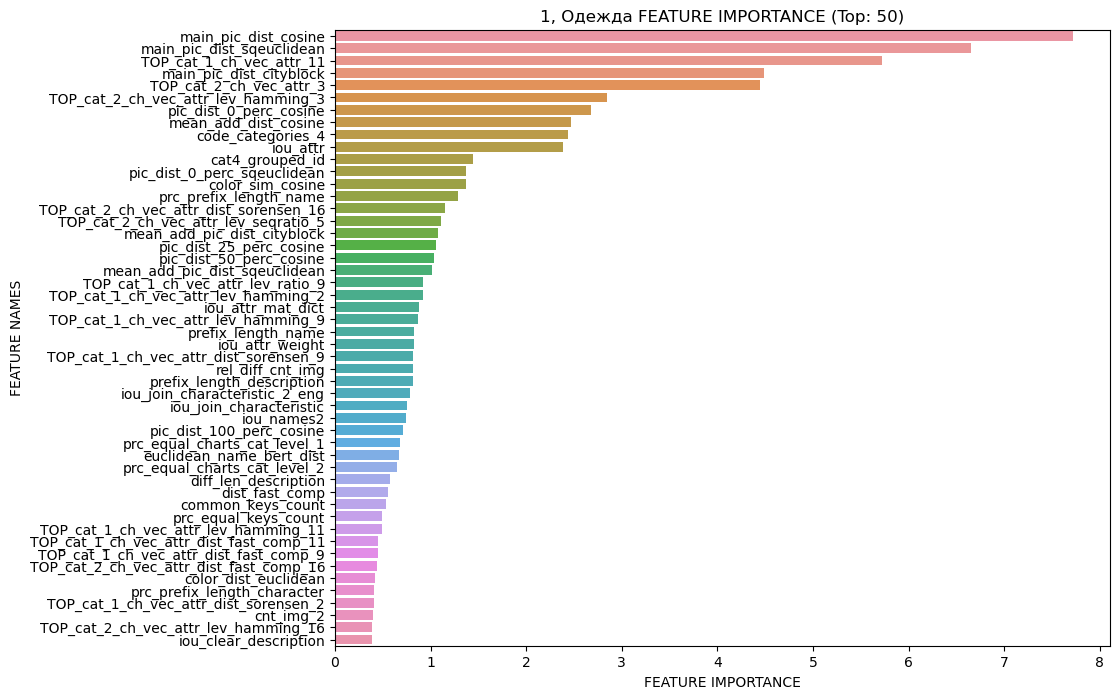

2 Товары для взрослых


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


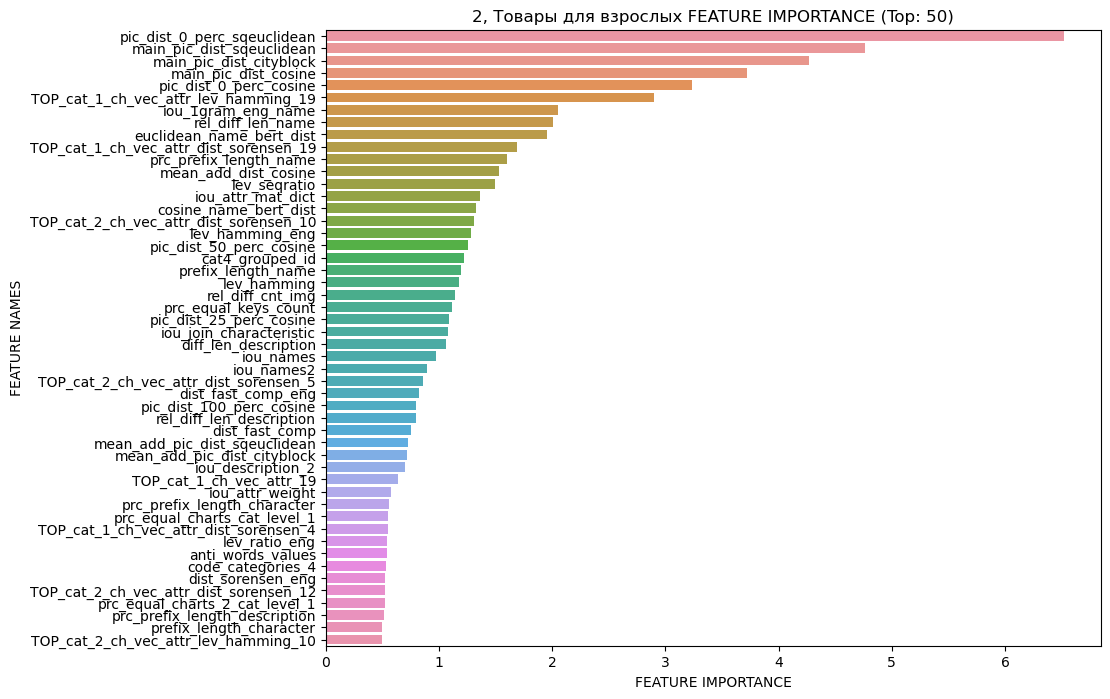

3 Товары для животных


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


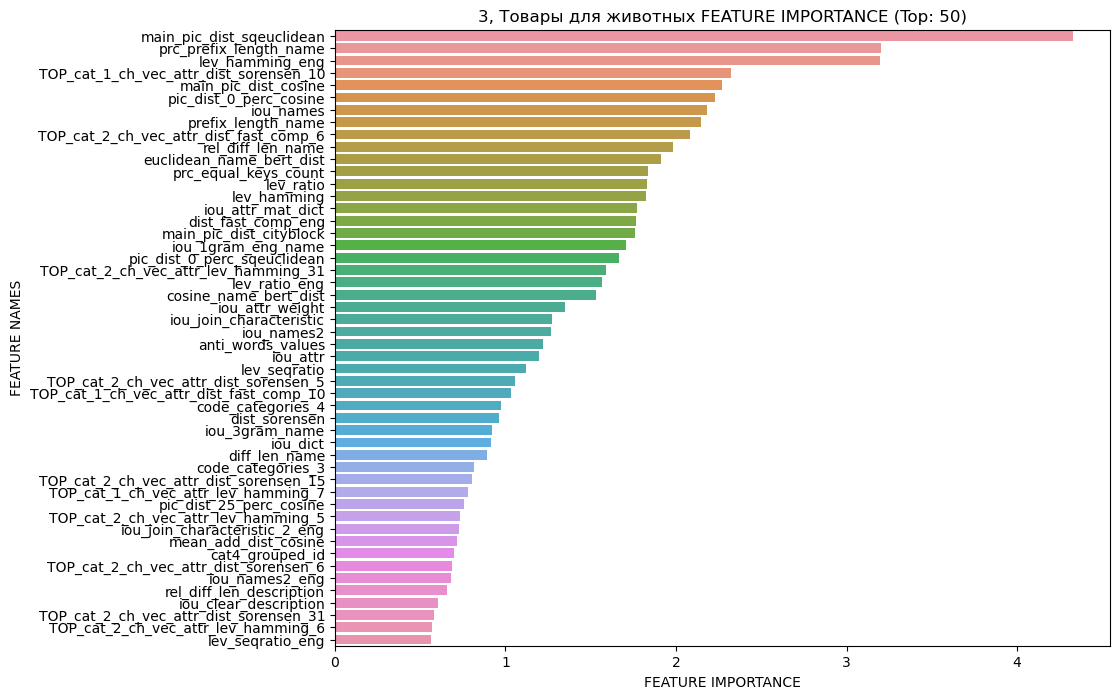

4 Строительство и ремонт


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


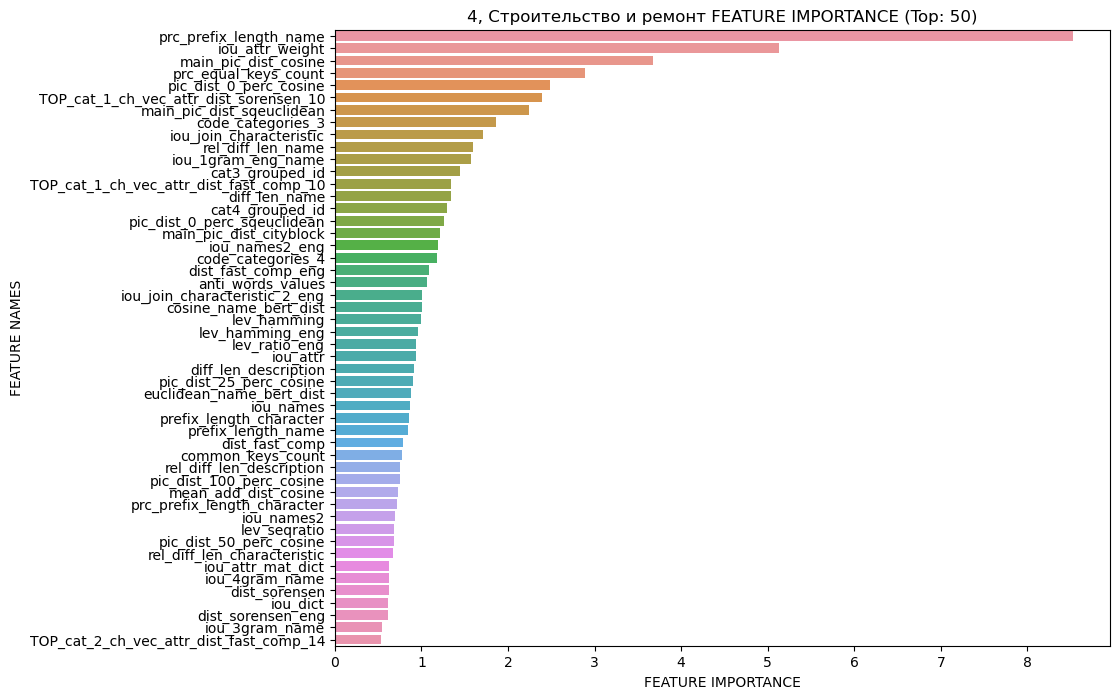

5 Канцелярские товары


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


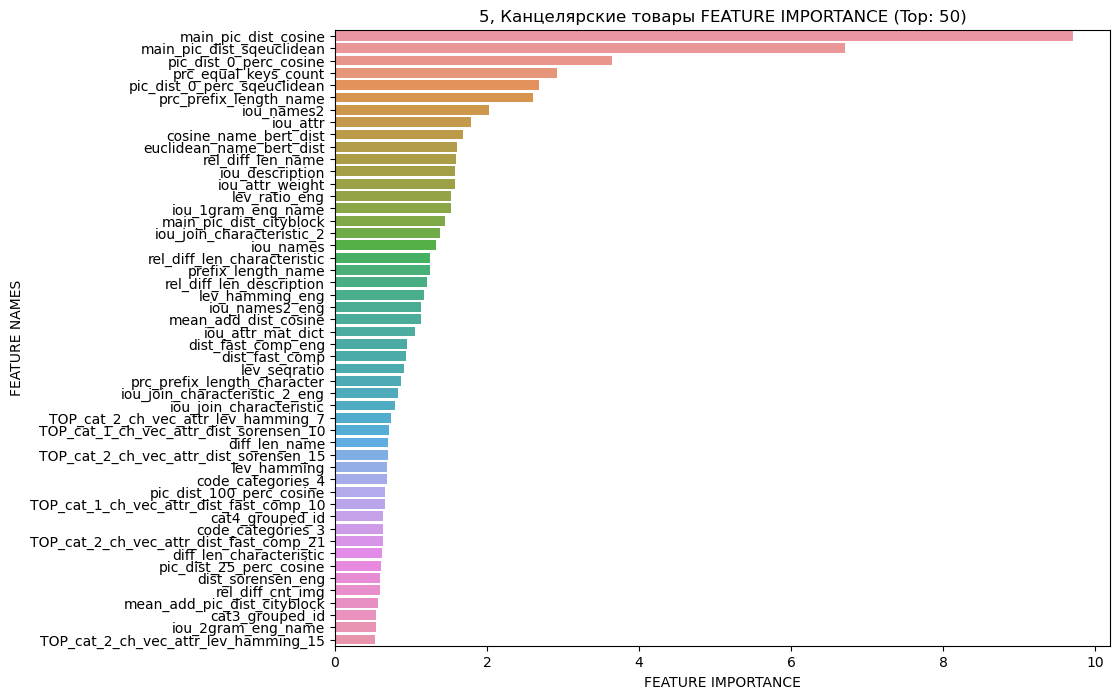

6 Продукты питания


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


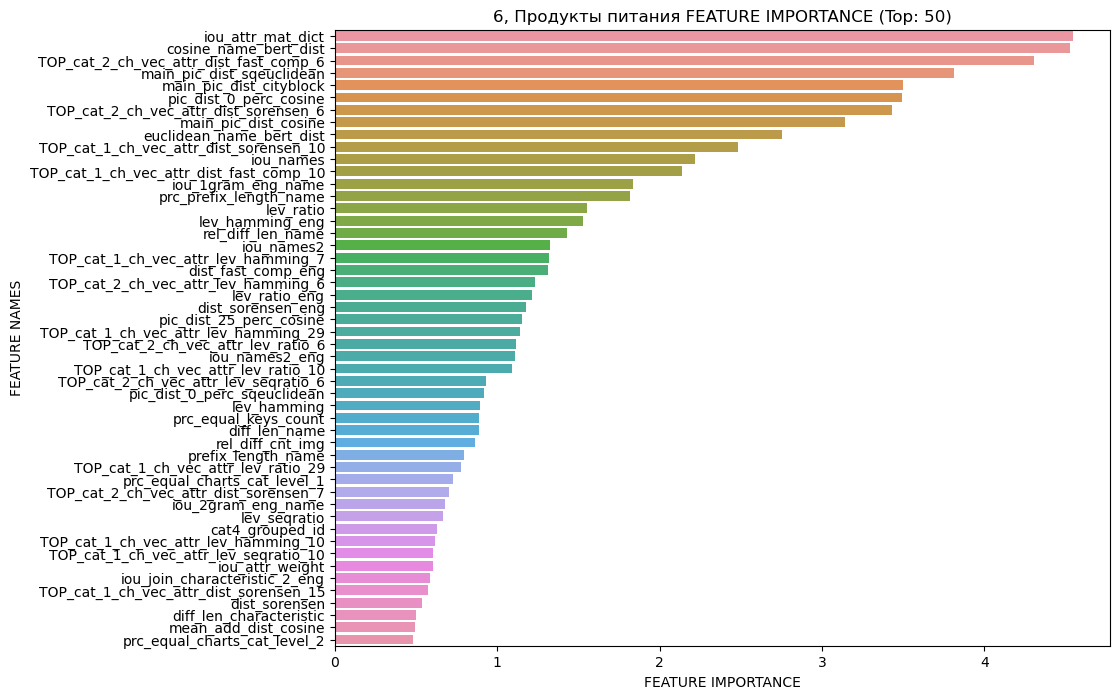

7 Автотовары


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


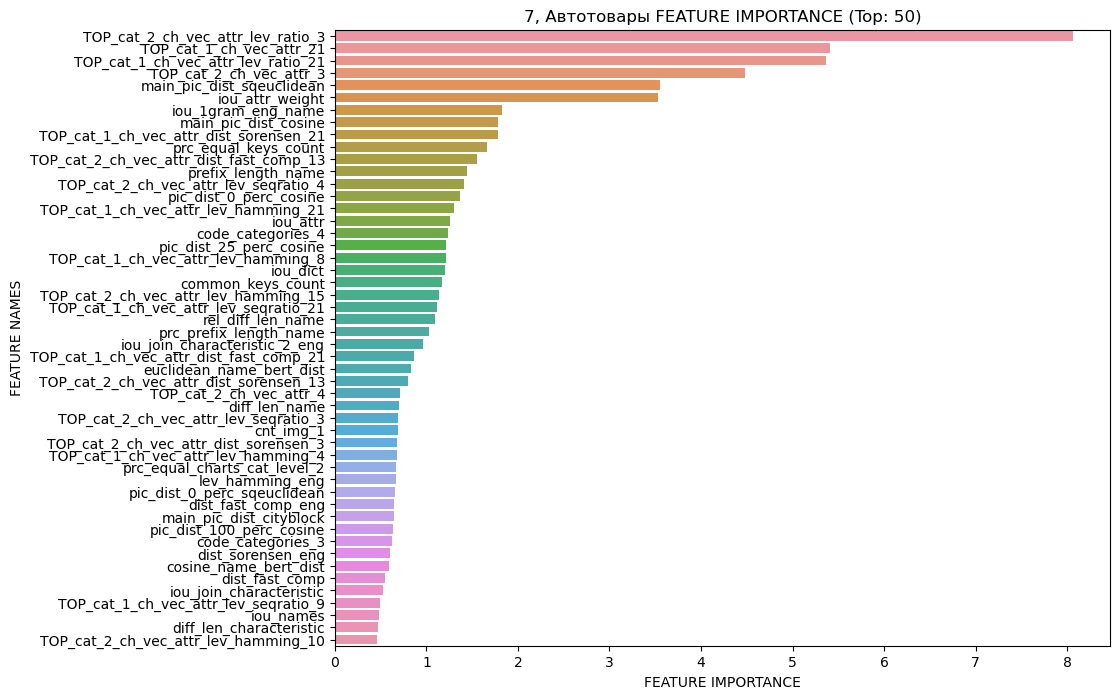

8 Аптека


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


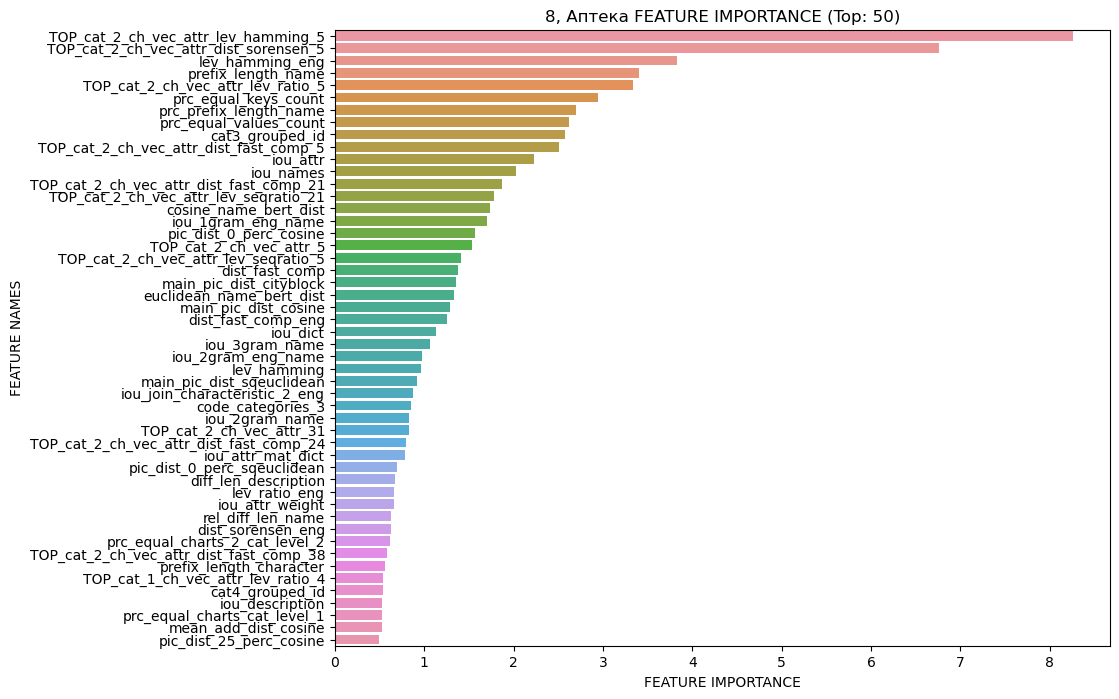

9 Дом и сад


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


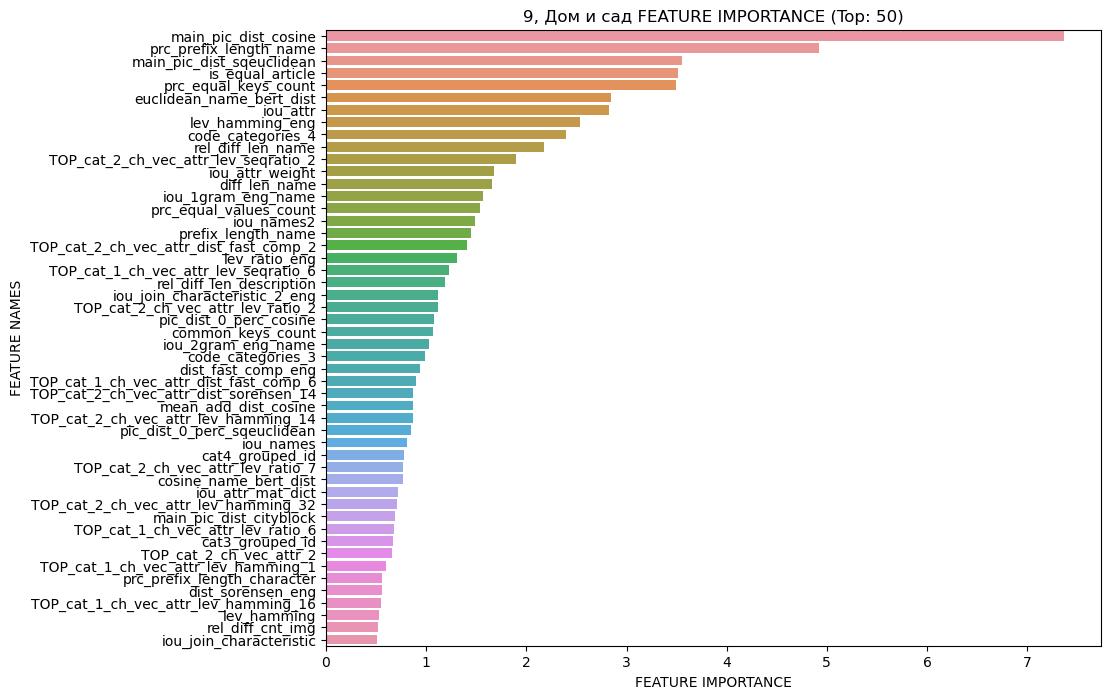

10 Обувь


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


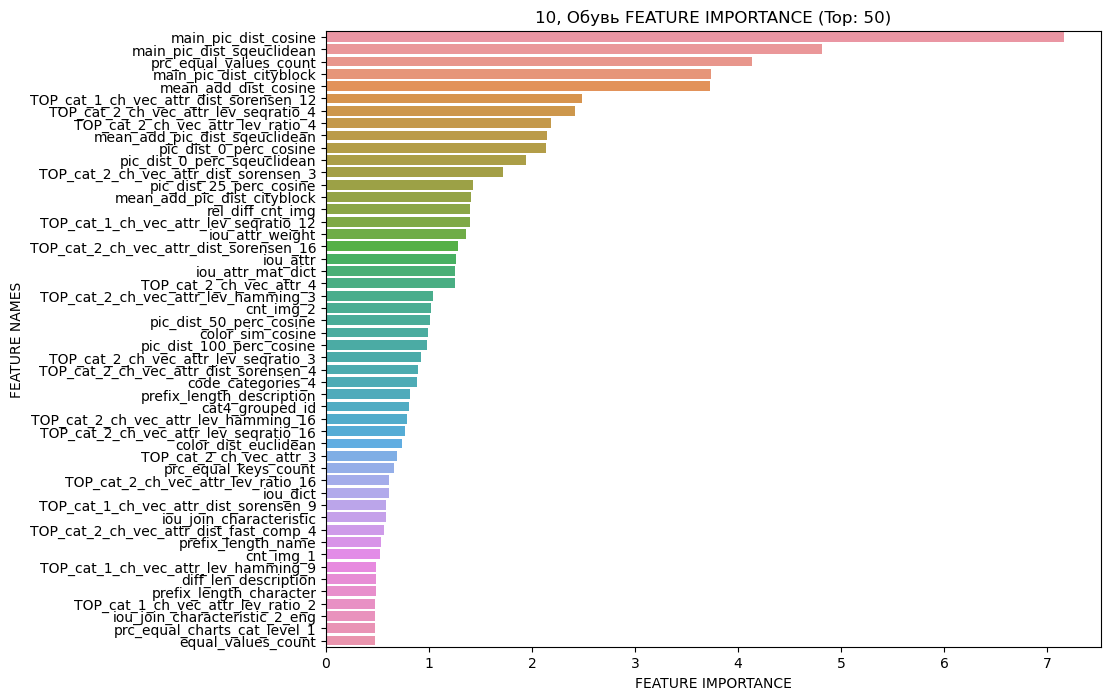

11 Книги


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


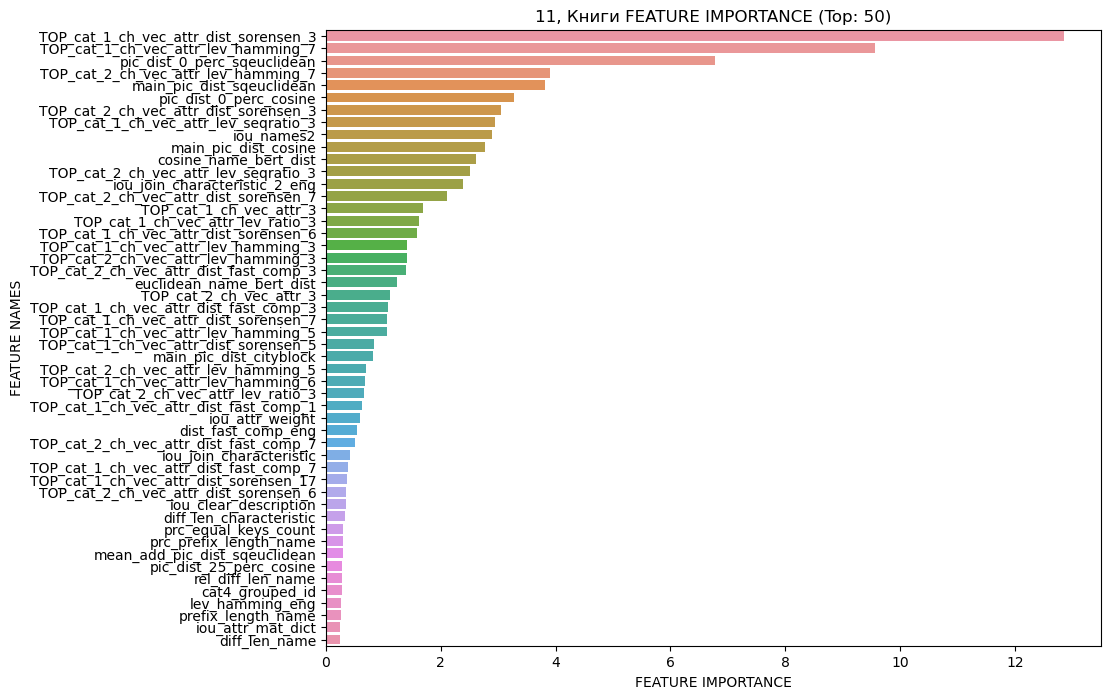

12 Галантерея и аксессуары


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


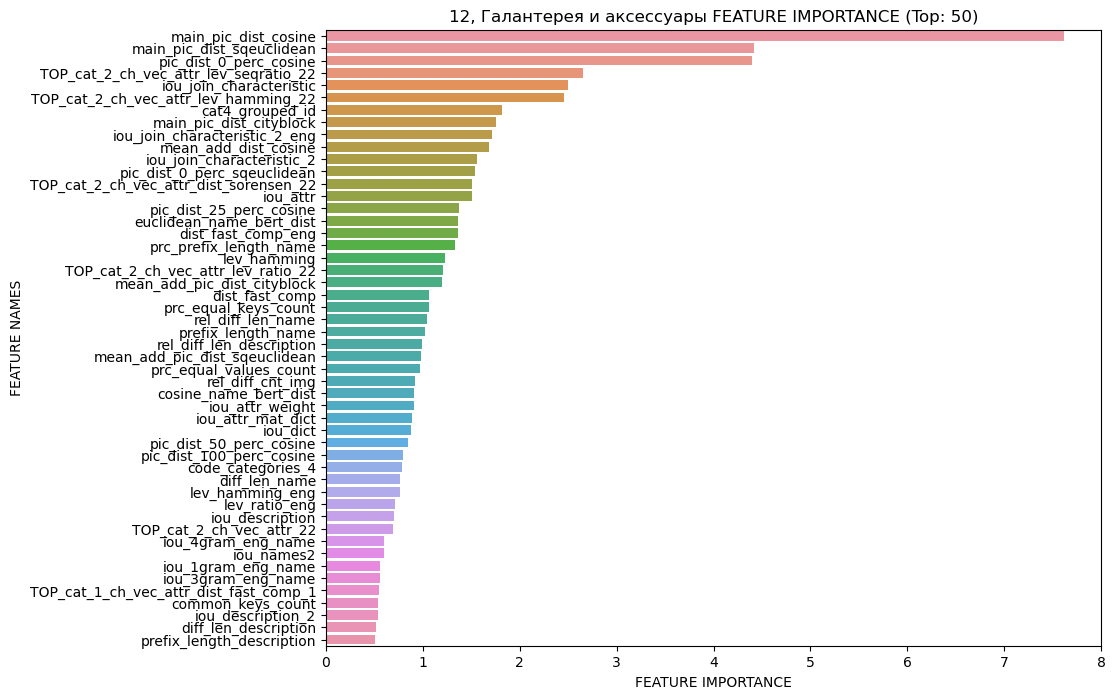

13 Хобби и творчество


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


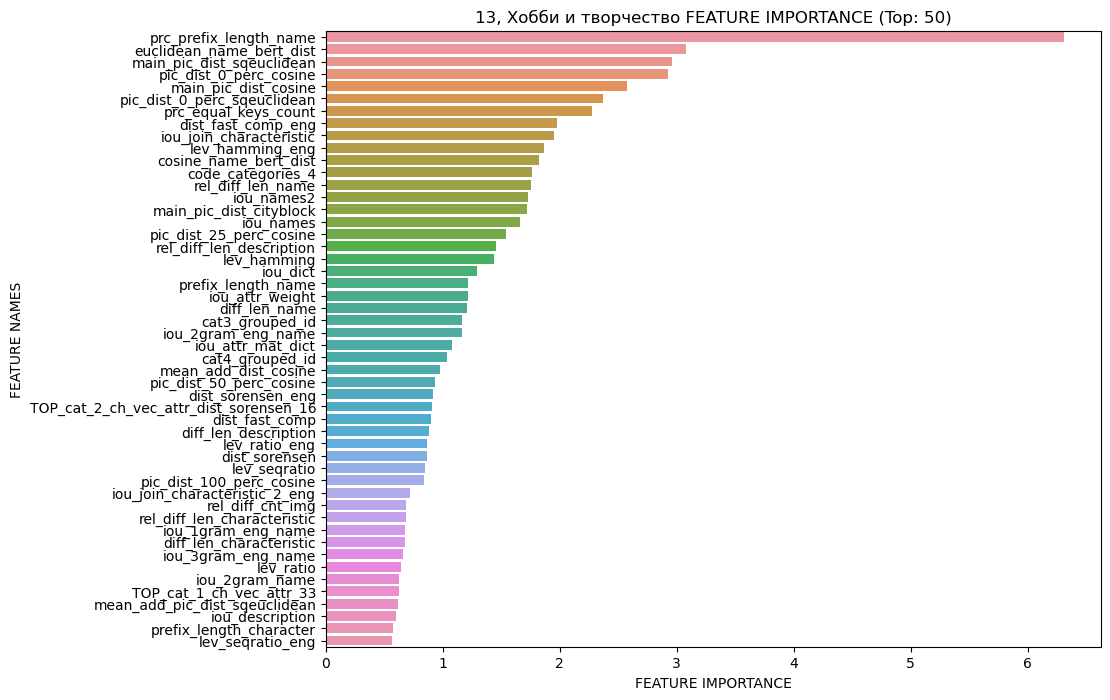

14 Мебель


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


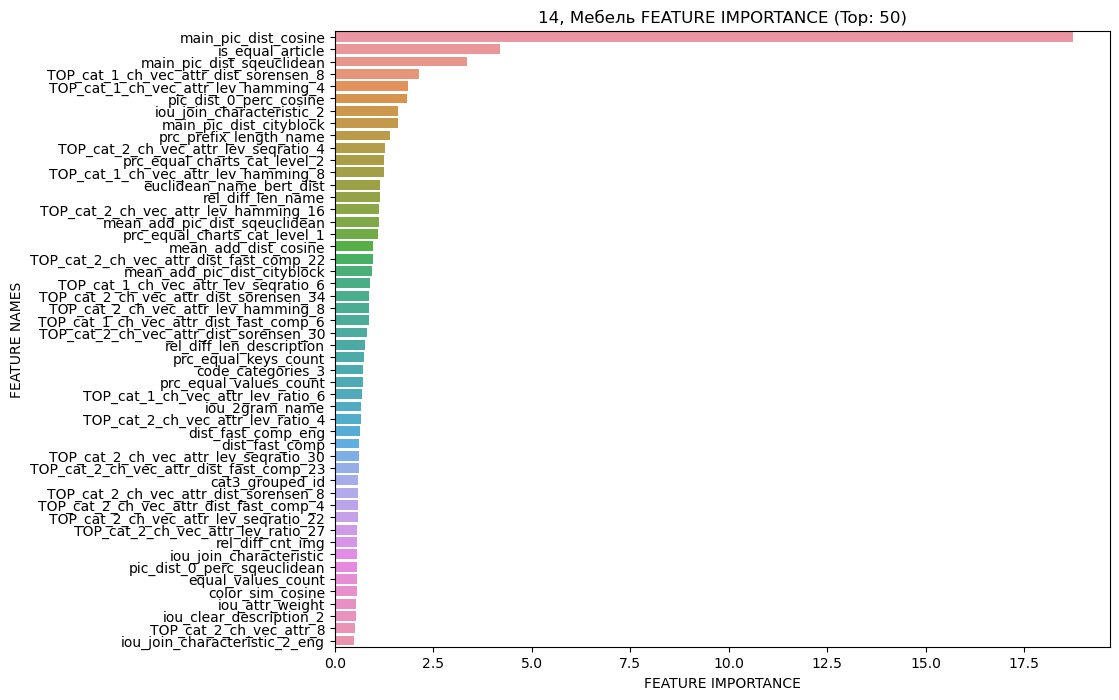

15 Спорт и отдых


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


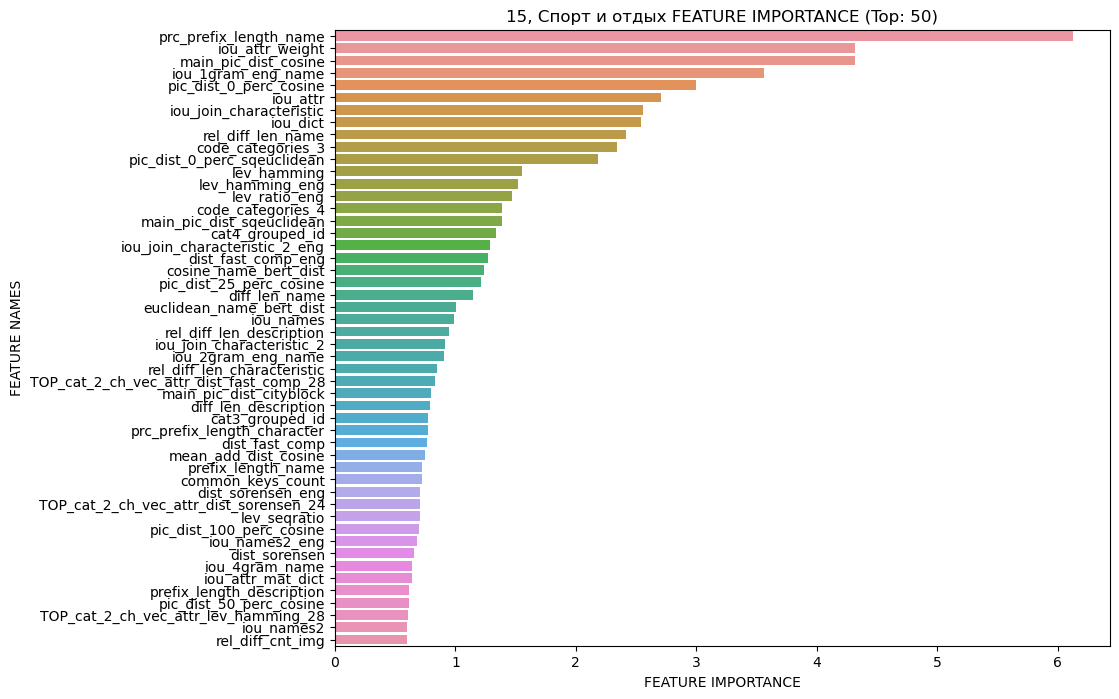

16 Красота и гигиена


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


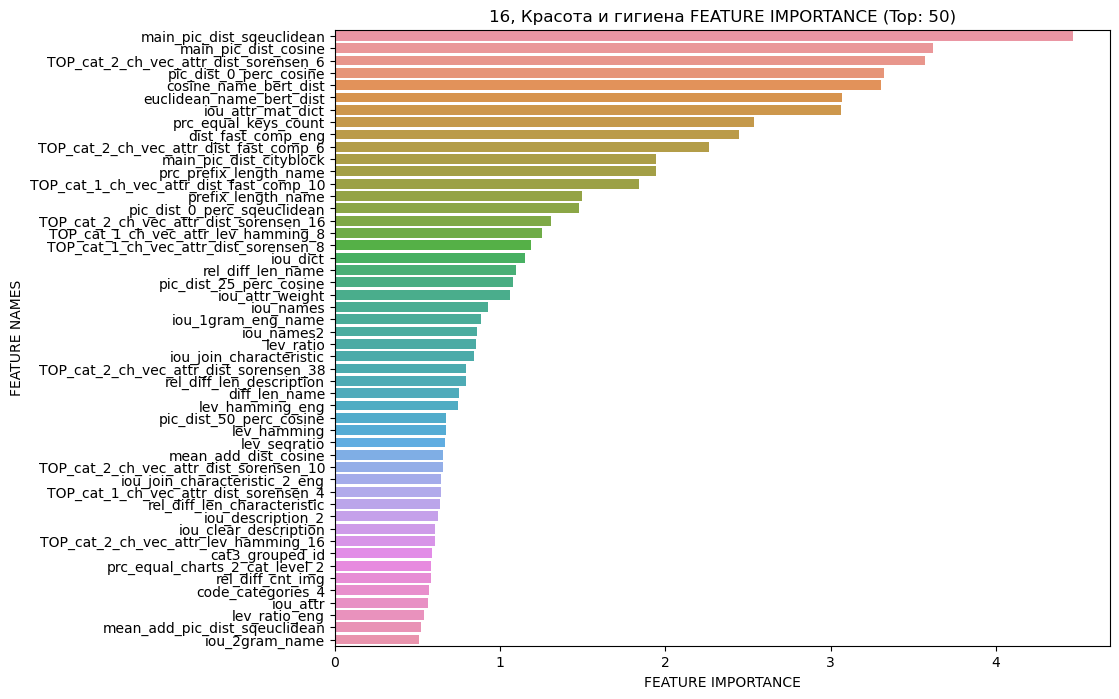

17 Детские товары


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


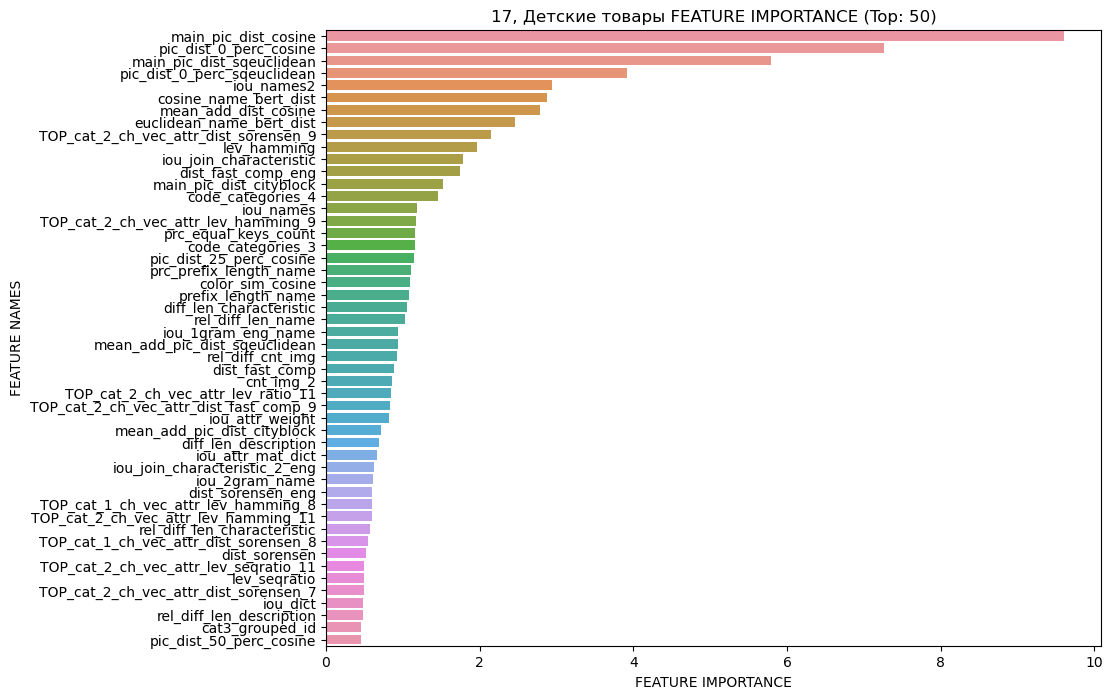

18 Электроника


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


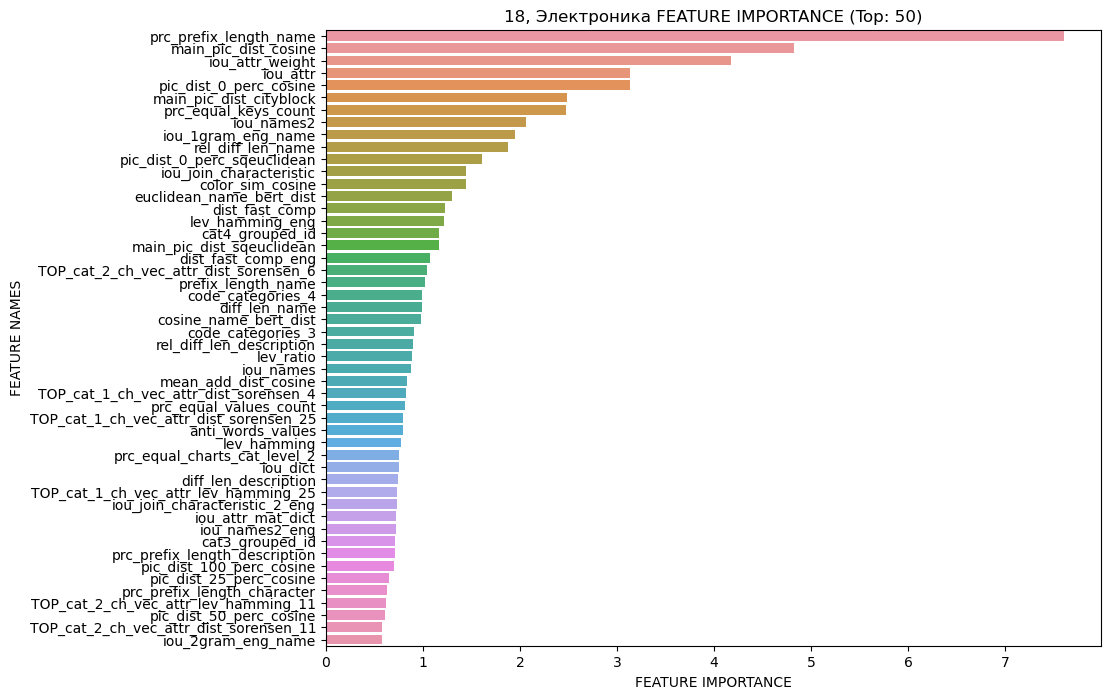

19 Бытовая техника


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


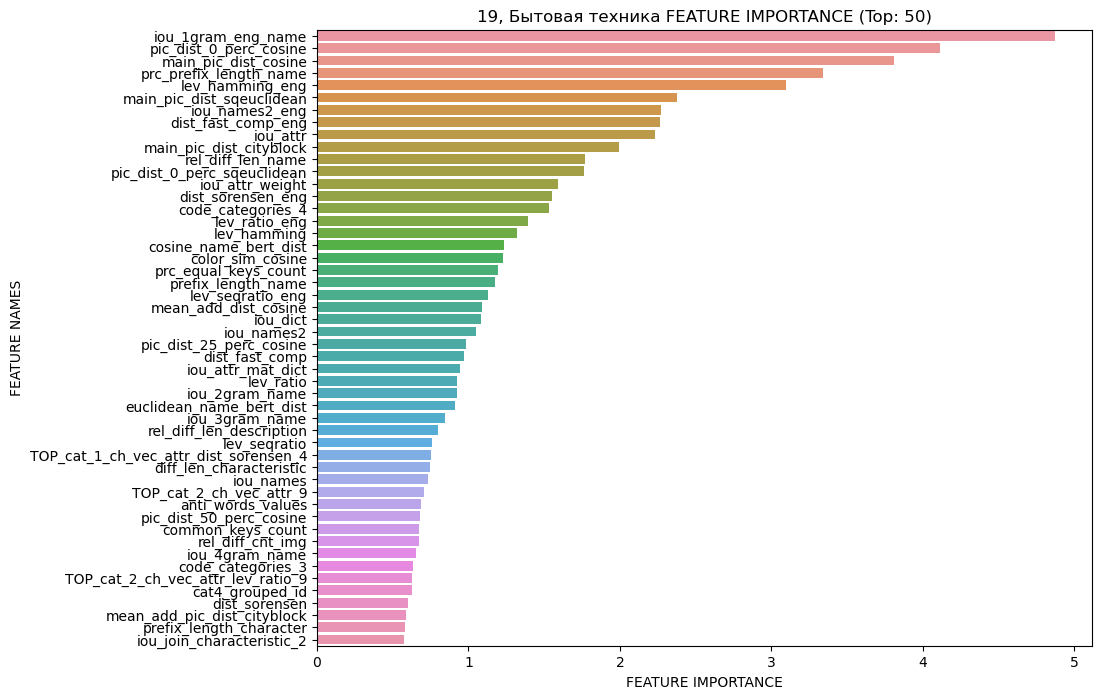

20 Бытовая химия


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


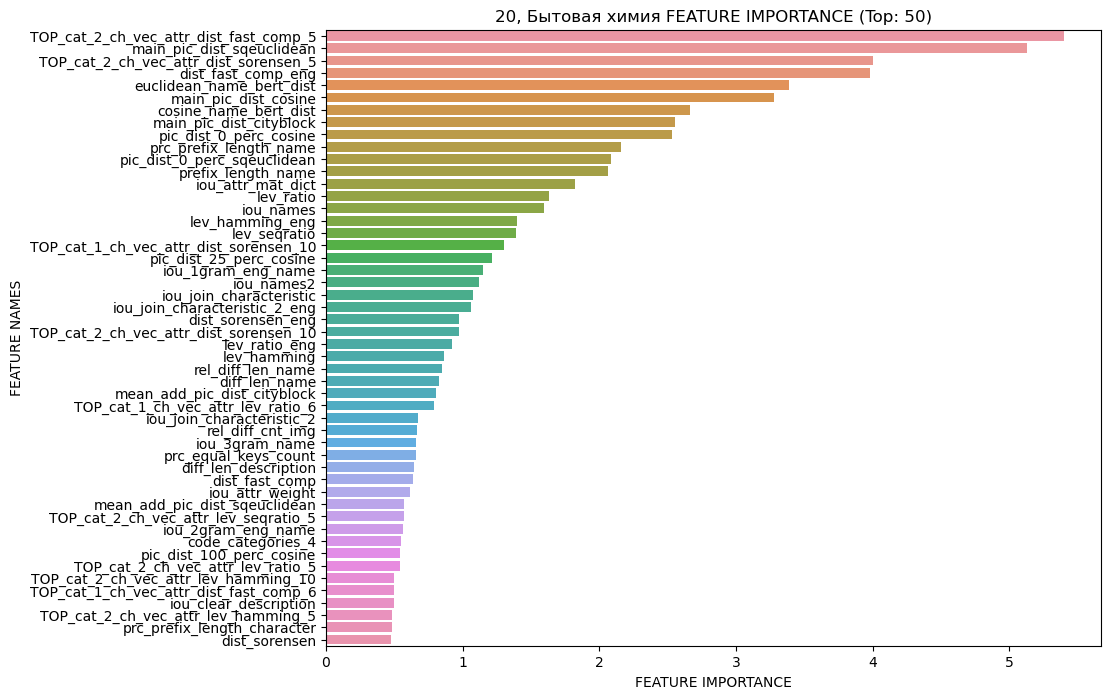

CPU times: total: 19min 20s
Wall time: 14min 58s


In [99]:
%%time
def train_test_split_by_cat_2(full_df, cat_name:str):
    full_df = full_df[full_df['cat_level_2_1'] == cat_name]
    X_train_df, X_val_df = train_test_split(
        full_df, 
        test_size=0.02, 
        random_state=53, 
        stratify=full_df["target"]
    )
    # X_train_df = full_df
    return X_train_df, X_val_df

models_by_cat_level_2 = {}
for i, cat_name in enumerate(train_df["cat_level_2_1"].unique()):
    print(i+1, cat_name)
    # Определяем модель
    model = CatBoostClassifier(iterations=8000,
                    eval_metric =  "AUC", 
                    early_stopping_rounds=500, 
                    ignored_features=['variantid1', 'variantid2'],
                    cat_features=cat_columns,
                    # od_type = "Iter",
                    # od_wait = 200,                               
                    random_state=53,
                    task_type="GPU",
                    devices='0',
                    learning_rate = 0.1
                    )
    
    # Формируем выборку данных под категорию
    X_train_df, X_val_df = train_test_split_by_cat_2(full_df=X_train_val_df, cat_name=cat_name)
    
#     X_train = X_train_df[features_columns_for_model_cat_2 + ['cv_predict']]
    X_train = X_train_df[features_columns_for_model_cat_2]
    y_train = X_train_df[target_column]

#     X_val = X_val_df[features_columns_for_model_cat_2 + ['cv_predict']]
    X_val = X_val_df[features_columns_for_model_cat_2]
    y_val = X_val_df[target_column]
    
    # Обучаем модель
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val), 
              plot=True, 
              verbose=False 
             )
    
#     plot_feature_importance(model.get_feature_importance(), (features_columns_for_model_cat_2 + ['cv_predict']),'CATBOOST ', top_n=50)
    plot_feature_importance(model.get_feature_importance(), (features_columns_for_model_cat_2 ),f'{i+1}, {cat_name}', top_n=50)
    plt.show()
    models_by_cat_level_2[cat_name] = model

In [100]:
import pickle
model_filename_cat_2 = 'cat_2__20_models_08_09_2024__vb9_1_3.pkl'
# Сохраняем модель
with open(model_filename_cat_2, 'wb') as file:
    pickle.dump(models_by_cat_level_2, file)

In [43]:
# import pickle
# # model_filename = 'triple_model_cat_1_08_09_2024__vb9_1_2.pkl'
# model_filename_cat_2 = 'cat_2__20_models_08_09_2024__vb9_1_2.pkl'
# # Загружаем anti_words
# with open(model_filename_cat_2, 'rb') as file:
#     models_by_cat_level_2 = pickle.load(file)

In [101]:
for cat in models_by_cat_level_2.keys():
#     X_test_df.loc[X_test_df['cat_level_1_1'] == cat, 'predict_cat_1'] = models_by_cat[cat].predict_proba(X_test_df[X_test_df['cat_level_1_1'] == cat][features_columns])[:,1]
    X_test_df.loc[X_test_df['cat_level_2_1'] == cat, 'predict_cat_2'] = models_by_cat_level_2[cat].predict_proba(X_test_df[X_test_df['cat_level_2_1'] == cat][features_columns_for_model_cat_2])[:,1]
#     X_test_df.loc[X_test_df['cat_level_2_1'] == cat, 'predict'] = models_by_cat[cat].predict_proba(X_test_df[X_test_df['cat_level_2_1'] == cat][features_columns + ['cv_predict']])[:,1]
#     X_test_df.loc[X_test_df['cat_level_2_1'] == cat, 'predict'] = models_by_cat[cat].predict_proba(X_test_df[X_test_df['cat_level_2_1'] == cat][features_columns])[:,1]
#     X_test_df.loc[X_test_df['cat_level_1_1'] == cat, 'predict'] = models_by_cat[cat].predict(X_test_df[X_test_df['cat_level_1_1'] == cat][features_columns])
# X_test_df['predict'] = X_test_df['predict'].clip(0,1)    
X_test_df.shape    

(11686, 774)

In [102]:
# Считаем среднее предсказание по двум моделям
# X_test_df['predict'] = X_test_df[['predict_cat_1', 'predict_cat_2']].mean(axis=1)
# X_test_df['predict'] = np.mean((X_test_df['predict_cat_1'].values, X_test_df['predict_cat_2'].values), axis=0)

In [91]:
# Модель cat_0 1 модель
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict_cat_0'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)

0.9564208426517121

In [67]:
# Модель cat_0 1 модель
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict_cat_0'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)

0.9539578515373712

In [98]:
# Модель cat_1 3 модели
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict_cat_1'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)

0.9647327867995233

In [194]:
# Модель cat_1 3 модели
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict_cat_1'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)

0.9594172508977383

In [103]:
# Модель cat_2 20 моделей
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict_cat_2'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)

0.9636904188156764

In [195]:
# Модель cat_2 20 моделей
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict_cat_2'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)

0.9618397116068846

In [222]:
# Среднее Модель cat_1 + cat_2
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)

0.9627257711305448

In [233]:
# Считаем среднее предсказание по двум моделям
X_test_df['predict'] = np.mean((X_test_df['predict_cat_1'].values, X_test_df['predict_cat_2'].values * 2), axis=0)

In [234]:
# Среднее Модель cat_1 + cat_2
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)


0.9630090178038582

In [85]:
# Считаем среднее предсказание по двум моделям
X_test_df['predict'] = np.mean((
            X_test_df['predict_cat_0'].values * 0.6,
            X_test_df['predict_cat_1'].values * 0.6, 
            X_test_df['predict_cat_2'].values * 2.1), axis=0)
# Среднее Модель cat_1 + cat_2
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)


0.9634075978573767

In [60]:
# Считаем среднее предсказание по двум моделям
X_test_df['predict'] = np.mean((
            X_test_df['predict_cat_0'].values * 0.2,
            X_test_df['predict_cat_1'].values * 0.8, 
            X_test_df['predict_cat_2'].values * 2.1), axis=0)
# Среднее Модель cat_1 + cat_2
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)


0.9630532105787895

In [272]:
# Считаем среднее предсказание по двум моделям
X_test_df['predict'] = np.mean((
            X_test_df['predict_cat_1'].values * 0.8, 
            X_test_df['predict_cat_2'].values * 2), axis=0)
# Среднее Модель cat_1 + cat_2
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)


0.9630227840855096

In [277]:
# X_test_df['cat_level_3_1'].unique()

In [131]:
# Считаем среднее предсказание по двум моделям
X_test_df['predict'] = np.mean((
            X_test_df['predict_cat_0'].values * 0.7,
            X_test_df['predict_cat_1'].values * 2.1, 
            X_test_df['predict_cat_2'].values * 3), axis=0)
# Среднее Модель cat_1 + cat_2
result_test_df = pd.DataFrame({
        'target_true': X_test_df['target'],
        'target_pred': X_test_df['predict'],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

calculate_macro_prauc_by_category(result_test_df, categories)


0.9666050769602202

# Иерархический стекинг

In [148]:
# X_train = X_train_val_df[features_columns + [target_column]][:10000]
# X_train_df, X_val_df = train_test_split(
#     X_train_val_df, 
#     test_size=0.05, 
#     random_state=53, 
#     stratify=X_train_val_df[['cat_level_1_1', 'target']]
# )
# X_train_df = X_train_df[features_columns + [target_column]][:10000]
# X_val_df = X_val_df[features_columns + [target_column]][:10000]

# X_train.shape, X_val_df.shape

((10000, 264), (10000, 264))

In [188]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

class CalcBasePredict_CV:
    def __init__(self,
                data_df:pd.DataFrame=None,
                path_save_models:str=None,
                target_column:str=None,
                feature_columns:List[str]=[],
                cat_features:List[str]=[],
                ignored_features:List[str]=[],
                verbose:bool=True,
                base_model=None,
                iterations:int=1000,
                params_model:dict={},
                predict_column_prefix:str='cv_base_predict_',
                ):
        # Проверка, что данные есть 
        assert not isinstance(data_df, type(None)), "Необходимо подать data_df"
        assert not isinstance(target_column, type(None)), 'Не указан target_column'
        
        self.data_df = data_df
        self.path_save_models = path_save_models
        self.verbose = verbose
        self.base_model = base_model
        self.iterations = iterations
        
        # Если деление данных было произведено заранее, тогда здесь ничего не делаем
        assert target_column in self.data_df.columns, f"target-поле ({target_column}) отсутствует в данных"
        self.target_column = target_column
        self.ignored_features = ignored_features
        self.features_columns = list(self.data_df.columns)
        # self.features_columns = feature_columns
        self.features_columns.remove(self.target_column)
        self.features_columns = [i for i in self.features_columns if i not in self.ignored_features + [self.target_column]]
        self.cat_features = cat_features
        # self.ignored_features = ignored_features
        self.predict_column_prefix = predict_column_prefix
        print(f'features: {len(list(self.features_columns))} (cat_features:{len(self.cat_features)})') if self.verbose else None
        
        if self.base_model is None:
            self.base_model = CatBoostRegressor(
                                loss_function='RMSE',
                                eval_metric="MAE",     
#                                 loss_function='MultiQuantile:alpha=0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.15, 0.12, 0.1, 0.07, 0.05, 0.02', 
                                early_stopping_rounds=100, 
                                random_state=53, 
                            )
        # Задаем базовым моделям параметры 
        if 'iterations' not in params_model:
            self.base_model.set_params(iterations=self.iterations)
        # self.base_model.set_params(ignored_features=self.ignored_features, cat_features=self.cat_features,)
        self.base_model.set_params(cat_features=self.cat_features,)
        self.base_model.set_params(**params_model)
        self.submit_model = None
        if type(self.base_model) != CatBoostRegressor and type(self.base_model) != CatBoostClassifier:
            # print(f'self.features_columns: {len(self.features_columns)}')
            self.features_columns = [i for i in self.features_columns if i not in self.ignored_features + self.cat_features]
            # print(f'self.features_columns: {len(self.features_columns)}')
            
        
    def predict_cross_validation(self, 
                                 k_folds:int=5, 
                                 val_size:int=0.05, 
                                 #iterations:int=1000, 
                                 type_model='clf',
                                ):
        # self.params_cv_models = {}
        # Кроссвалидация для обучения модели-регресс предсказания таргета time
        skf = StratifiedKFold(n_splits=k_folds, random_state=53, shuffle=True)
        predict_column = f'{self.predict_column_prefix}{self.target_column}'
        print(f'target_col: {self.target_column}, predict_column: {predict_column}') if self.verbose else None
        # Если в данных уже есть рассчитаное поле предикт, то удалем его
        if predict_column in features_columns:
            self.features_columns = self.features_columns.remove(predict_column)
        self.data_df[predict_column] = np.nan
        
        cv_y_train = self.data_df[self.target_column]
        print(f'Начало кросс-валидации, k_folds={k_folds}') if self.verbose else None
        # print(f'1 self.data_df: {self.data_df.shape}')
        for i, (train_index, test_index) in enumerate(skf.split(self.data_df[self.features_columns], cv_y_train)):
            print(f'fold: {i+1}') if self.verbose else None
            print(f'train_index: {len(train_index)}, test_index: {len(test_index)}') if self.verbose else None
            fold_X_train = self.data_df[self.features_columns].iloc[train_index]
            fold_y_train = cv_y_train.iloc[train_index]
            
            # Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
            fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(
                                                                            fold_X_train, 
                                                                            fold_y_train, 
                                                                            test_size=val_size, 
                                                                            random_state=53)
            fold_X_test = self.data_df[self.features_columns].iloc[test_index]
            fold_y_test = cv_y_train.iloc[test_index]
            
            # Обучаем базовые модели
            fold_cv_model = self.base_model#.copy()
            print("# Обучаем базовые модели") if self.verbose else None
            if type(fold_cv_model) == CatBoostRegressor or type(fold_cv_model) == CatBoostClassifier:
                fold_cv_model.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=self.verbose, verbose=False) 
            elif type(fold_cv_model) == xgboost.XGBRegressor or type(fold_cv_model) == xgboost.XGBClassifier:
                fold_cv_model.fit(fold_X_train, fold_y_train, eval_set=[(fold_X_val, fold_y_val)], verbose=self.verbose) 
            else:
                # subselect_features = [i for i in fold_X_train.columns if i not in self.ignored_features + self.cat_features ]
                # fold_cv_model.fit(fold_X_train[subselect_features], fold_y_train, eval_set=(fold_X_val[subselect_features], fold_y_val), verbose=self.verbose) 
                print(fold_X_train.shape, fold_y_train.shape,fold_X_val.shape, fold_y_val.shape) 
                fold_cv_model.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), verbose=self.verbose) 
                
            print("# Завершили обучение фолда") if self.verbose else None
            # Делаем прогноз для фолдов
            if type_model == 'clf':
                self.data_df[predict_column].iloc[test_index] = pd.DataFrame(fold_cv_model.predict_proba(fold_X_test)[:,1]).apply(lambda x: x.values, axis=1)
            elif type_model == 'reg':
                self.data_df[predict_column].iloc[test_index] = pd.DataFrame(fold_cv_model.predict(fold_X_test)).apply(lambda x: x.values, axis=1)
            else:
                raise 'Неопределн типа модели. type_model может быть reg / clf'
            # Выводим график важности признаков
            if self.verbose and (type(fold_cv_model) == CatBoostRegressor or type(fold_cv_model) == CatBoostClassifier):
                plot_feature_importance(fold_cv_model.get_feature_importance(), fold_X_train.columns, model_name='', top_n=20,)
                plt.show()
        # Разворачиваем данные
        length_predictions = len(self.data_df[predict_column].iloc[test_index][:1].item())
        if length_predictions == 1:
            self.data_df[predict_column] = self.data_df[predict_column].apply(lambda x: x[0])    
            pred_columns = [predict_column]
        else:
            pred_columns = [f'{predict_column}__{i+1}' for i in range(length_predictions)]
            self.data_df[pred_columns] = self.data_df[predict_column].apply(lambda x: pd.Series(x))
            self.data_df = self.data_df.drop(columns=[predict_column])
        return self.data_df, pred_columns
    
    def fit_submit_model(self, submit_X_train_df:pd.DataFrame, submit_X_val_df:pd.DataFrame):
        self.submit_model = self.base_model#.copy()
        
        submit_X_train = submit_X_train_df[self.features_columns]
        submit_y_train = submit_X_train_df[self.target_column]
        
        submit_X_val = submit_X_val_df[self.features_columns]
        submit_y_val = submit_X_val_df[self.target_column]
        if type(self.submit_model) == CatBoostRegressor or type(self.submit_model) == CatBoostClassifier:
            self.submit_model.fit(submit_X_train, submit_y_train, eval_set=(submit_X_val, submit_y_val), plot=self.verbose, verbose=False) 
        elif type(self.submit_model) == xgboost.XGBRegressor or type(self.submit_model) == xgboost.XGBClassifier:
            self.submit_model.fit(submit_X_train, submit_y_train, eval_set=[(submit_X_val, submit_y_val)], verbose=self.verbose) 
        else:
            # subselect_features = [i for i in submit_X_train.columns if i not in self.ignored_features + self.cat_features ]
            # self.submit_model.fit(submit_X_train[subselect_features], submit_y_train, eval_set=(submit_X_val[subselect_features], submit_y_val), verbose=self.verbose) 
            self.submit_model.fit(submit_X_train, submit_y_train, eval_set=(submit_X_val, submit_y_val), verbose=self.verbose) 
        self.submit_features = self.features_columns
        # Выводим график важности признаков
        if self.verbose and (type(self.submit_model) == CatBoostRegressor or  type(self.submit_model) == CatBoostClassifier ):
            plot_feature_importance(self.submit_model.get_feature_importance(), submit_X_train.columns, model_name='', top_n=20,)
            plt.show()        
        
    def calc_submit(self, ):
        # self.base_model.copy()
        # Усредняем параметры обучения кросс моделей
        # pd.DataFrame(self.params_cv_models).T.convert_dtypes()
        # self.params_cv_models
        # Реализация разбиения данных по умолчанию
        # train_test_split  self.data_df
        return
    
    def save_model(self, model_name:str='base_model', itterattions:int=1000):
        print(f'save_model: {model_name}')
        assert not isinstance(self.submit_model, type(None)), "Требуется обучить модель перед сохранением"
        file_model = f'{datetime.now().strftime("%d_%m_%Y__%H_%M__")}__{model_name}.pkl'
        # Сохраняем модель
        with open(self.path_save_models + file_model, 'wb') as file:
            pickle.dump(self.submit_model, file)       
        print(f'save model: {file_model} ') if self.verbose else None
        # model_features = numeric_columns + categorical_columns
        # Сохраняем массив признаков для сохранения верного порядка на котором обучалась модель
        file_model_features = f'{datetime.now().strftime("%d_%m_%Y__%H_%M__")}__{model_name}_features.pkl'
        print(file_model_features)
        # # Сохраняем признаки
        with open(self.path_save_models + file_model_features, 'wb') as file:
            # pickle.dump(self.submit_features, file)
            if type(self.submit_model) == CatBoostRegressor or type(self.submit_model) == CatBoostClassifier:
                pickle.dump(self.submit_model.feature_names_, file)
            elif type(self.submit_model) == xgboost.XGBRegressor or type(self.submit_model) == xgboost.XGBClassifier:
                pickle.dump(self.submit_model.get_booster().feature_names, file)
            else:
                pickle.dump(self.submit_model.booster_.feature_name(), file)
        print(f'save model_features: {file_model_features} ') if self.verbose else None
        
        return file_model, file_model_features


CPU times: total: 0 ns
Wall time: 0 ns


In [193]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from datetime import datetime, timedelta
import xgboost
import lightgbm
from sklearn import linear_model

class StackedEnsemble:
# class CalcBasePredict_CV:
    def __init__(self,
                train_df:pd.DataFrame=None,
                val_df:pd.DataFrame=None,
                path_save_models:str='',
                ignored_features:List[str]=[],
                cat_features:List[str]=[],
                base_model=None,
                target_column:str=None,
                verbose:bool=True,
                is_save_model:bool = False,
                ):
        self.train_df = train_df
        self.val_df = val_df
        self.path_save_models = path_save_models
        self.base_model = base_model
        self.verbose = verbose
        self.is_save_model = is_save_model
        
        print(f'train: {self.train_df.shape}, val: {self.val_df.shape}') if self.verbose else None
        
        self.target_column = target_column
        self.ignored_features = ignored_features
        self.features_columns = list(self.train_df.columns)
        self.features_columns = [i for i in self.features_columns if i not in self.ignored_features + [self.target_column]]
        
        self.cat_features = cat_features
        self.base_predict_columns = []
        self.boost_predict_columns = []
        self.submit_models = []
        self.submit_models_files = []
        print(f'features: {len(list(self.features_columns))} (cat_features:{len(self.cat_features)})') if self.verbose else None
        
    def join_train_val_test(self, 
                            cv_data_df:pd.DataFrame=None,
                            cv_train_df:pd.DataFrame=None,
                            cv_val_df:pd.DataFrame=None,
                            
                            reverse:bool=False):
        """
            Объединяем данные трейн, тест, вал в общий набор данных и сохраняем индексы, для обратного восстановления
            reverse - Если reverse=False, то объединяем данные, если reverse=True, тогда восстанавливаем по сохраненым индексам
        """
        # Объединяем данные для кросс-валидации
        if not reverse:
            assert not isinstance(cv_train_df, type(None)) and not isinstance(cv_val_df, type(None)), "Не указаны данные train/val для объединеия данных для CV"
            
            cv_data_df = pd.concat([cv_train_df, cv_val_df])
            self.index_train = len(cv_train_df)
            self.index_val = self.index_train + len(cv_val_df)
            
            print(f'Объединили данные для CV: Было: train:{len(cv_train_df)}, val:{len(cv_val_df)}, стало {len(cv_data_df)}') if self.verbose else None              
            return cv_data_df
        # Обратно делим данные после кросс-валидации
        else:
            assert not isinstance(cv_data_df, type(None)), "Не указан cv_data_df для обратного разделения данных для CV"
            # assert 'index_train' in locals(), 'Объединение делалось не здесь, восстановить деление не получится'
            cv_train_df = cv_data_df[:self.index_train]
            # cv_val_df = cv_data_df[self.index_train:self.index_val]
            cv_val_df = cv_data_df[self.index_train:]
            return cv_train_df, cv_val_df

        
    def gen_base_predicts_level_1(self, iterations:int=1000):
        # Объединяем данные трайн/вал/тест для проведения предсказаний по кросс-валидации
        cv_data_df = self.join_train_val_test(
                    cv_train_df=self.train_df, 
                    cv_val_df=self.val_df, 
                    )
        # 2 Базовая модель
        # Формируем предсказания по квантилям
        quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
        # важно чтобы квантили были отсортированы, потому квантильные предсказания также будут сортироваться
        quantiles = sorted(quantiles)
        qntl_base_model = CatBoostRegressor(
                            loss_function=f"MultiQuantile:alpha={', '.join([str(i) for i in quantiles])}", 
                            eval_metric="MAE",     
                            early_stopping_rounds=100, 
                            random_state=53,                     
                        )
        base_model_cv_1 = CalcBasePredict_CV(
                        # data_df=train_df[model_features + [target_column]].fillna(0),
                        # data_df=cv_data_df[self.features_columns + [self.target_column]],
                        data_df=cv_data_df,
                        # data_df=cv_data_df[self.features_columns + [self.target_column]],
                        target_column=self.target_column,
                        cat_features=self.cat_features,
                        ignored_features=self.ignored_features,
                        verbose=self.verbose,
                        iterations= iterations,
                        base_model=qntl_base_model,
                        predict_column_prefix='cv_l1_base_qntl_predict_',
                        path_save_models=self.path_save_models
        )

        cv_data_df, pred_columns = base_model_cv_1.predict_cross_validation(type_model='reg')
        qntl_columns = [f'cv_l1_predict_{self.target_column}_qntl_{str(v).replace(".","")}' for i, v in enumerate(quantiles)]
        rename_cols = {pred_columns[i]:qntl_columns[i] for i in range(len(qntl_columns))}
        cv_data_df = cv_data_df.rename(columns=rename_cols)
        # Сортируем значения квантилей согласно реальным значениям прогноза
        # Модель может ошибается в определении квантиля, таким образом, что например значение 30 квантиля меньше чем 10 квантиля 
        # Как вариант надо сделать сортировку полученных прогнозов и перераспределение по квантилям уже после прогноза.
        cv_data_df[qntl_columns] = np.sort(cv_data_df[qntl_columns].values)        
        # Формируем общий список фичей с предсказаниями
        self.base_predict_columns += qntl_columns
        
        submit_X_train_df=cv_data_df[:self.index_train]
        submit_X_val_df=cv_data_df[self.index_train:]
        base_model_cv_1.fit_submit_model(
                                    submit_X_train_df=submit_X_train_df,
                                    submit_X_val_df=submit_X_val_df)
        
        self.submit_models.append(base_model_cv_1.submit_model)
        if self.is_save_model:
            files_model = base_model_cv_1.save_model(model_name='level_1_base_submit_model_1_')
            self.submit_models_files.append(files_model)
        
        # 1 Базовая модель
        # Формируем предсказания по базовой модели
        clf_base_model = CatBoostClassifier(
                                    eval_metric =  "AUC", 
                                    early_stopping_rounds=500, 
                                    random_state=53,
                        )      
        base_model_cv_2 = CalcBasePredict_CV(
                                    data_df=cv_data_df,
                                    # data_df=cv_data_df[self.features_columns + [self.target_column]],
                                    target_column=self.target_column,
                                    cat_features=self.cat_features,
                                    ignored_features=self.ignored_features,
                                    verbose=self.verbose,
                                    iterations= iterations,
                                    base_model=clf_base_model,
                                    predict_column_prefix='cv_l1_base_predict_', 
                                    path_save_models=self.path_save_models
                        )

        cv_data_df, pred_columns = base_model_cv_2.predict_cross_validation(type_model='clf')
        # print(cv_data_df.shape)
        # print(cv_data_df[pred_columns].shape)
        # Формируем общий список фичей с предсказаниями
        self.base_predict_columns += pred_columns
        # End 1 Базовая модель
        submit_X_train_df=cv_data_df[:self.index_train]
        submit_X_val_df=cv_data_df[self.index_train:]
        # Оубчение сабмит модели для инференса 
        base_model_cv_2.fit_submit_model(
                                    submit_X_train_df=submit_X_train_df,
                                    submit_X_val_df=submit_X_val_df)
        self.submit_models.append(base_model_cv_2.submit_model)
        if self.is_save_model:
            files_model = base_model_cv_2.save_model(model_name='level_1_base_submit_model_2_')
            self.submit_models_files.append(files_model)
        
        self.based_models = [base_model_cv_1, base_model_cv_2]
        # Обратно разворачиваем исходные данные с разбивкой трейн, вал, тест 
        self.train_df, self.val_df = self.join_train_val_test(cv_data_df=cv_data_df, reverse=True)
        return cv_data_df, self.base_predict_columns

        
    def gen_boost_predicts_level_2(self, iterations:int=1000):
        # Объединяем данные трайн/вал/тест для проведения предсказаний по кросс-валидации
        cv_data_df = self.join_train_val_test(
                    cv_train_df=self.train_df, 
                    cv_val_df=self.val_df, 
                    )
        # 1 Буст модель для ансамбля # xgboost 
        xgb_model = xgboost.XGBClassifier(n_estimators = iterations,
                                         early_stopping_rounds=200, 
                                         eval_metric='auc',
                                         random_state=53, 
                                         device="cpu", verbose=self.verbose)
        
        ensmbl_model_cv_l2_1 = CalcBasePredict_CV(
                            data_df=cv_data_df,
                            # data_df=cv_data_df[self.features_columns + [self.target_column]],
                            target_column=self.target_column,
                            cat_features=self.cat_features,
                            ignored_features=self.ignored_features,
                            verbose=self.verbose,
                            iterations= iterations,
                            base_model=xgb_model,
                            predict_column_prefix='cv_l2_xgb_predict_', 
                            path_save_models=self.path_save_models
                            
                )
        cv_data_df, pred_columns = ensmbl_model_cv_l2_1.predict_cross_validation(type_model='clf')
        # Формируем общий список фичей с предсказаниями
        self.boost_predict_columns += pred_columns
        
        submit_X_train_df=cv_data_df[:self.index_train]
        submit_X_val_df=cv_data_df[self.index_train:]
        # Обучение сабмит модели для инференса 
        ensmbl_model_cv_l2_1.fit_submit_model(
                                    submit_X_train_df=submit_X_train_df,
                                    submit_X_val_df=submit_X_val_df)
        self.submit_models.append(ensmbl_model_cv_l2_1.submit_model)
        if self.is_save_model:
            files_model = ensmbl_model_cv_l2_1.save_model(model_name='level_2_ensmbl_submit_model_1_')
            self.submit_models_files.append(files_model)
        # End 1 Буст модель для ансамбля
        # 2 Буст модель для ансамбля # lightgbm
        lgbm_verbose = 10 if self.verbose else 0
        lgbm_model = lightgbm.LGBMClassifier(n_estimators = iterations,
                                 early_stopping_rounds=200, 
                                 # metric = 'mean_absolute_error',
                                 eval_metric=['auc'],
                                 random_state=53, 
                                 verbose=lgbm_verbose,
                                 )
        
        ensmbl_model_cv_l2_2 = CalcBasePredict_CV(
                            data_df=cv_data_df,
                            # data_df=cv_data_df[self.features_columns + [self.target_column]],
                            target_column=self.target_column,
                            cat_features=self.cat_features,
                            ignored_features=self.ignored_features,
                            verbose=self.verbose,
                            iterations= iterations,
                            base_model=lgbm_model,
                            predict_column_prefix='cv_l2_lgbm_predict_', 
                            path_save_models=self.path_save_models
                            
                )
        
        cv_data_df, pred_columns = ensmbl_model_cv_l2_2.predict_cross_validation(type_model='clf')
        # Формируем общий список фичей с предсказаниями
        self.boost_predict_columns += pred_columns
        
        submit_X_train_df=cv_data_df[:self.index_train]
        submit_X_val_df=cv_data_df[self.index_train:]
        # Обучение сабмит модели для инференса 
        ensmbl_model_cv_l2_2.fit_submit_model(
                                    submit_X_train_df=submit_X_train_df,
                                    submit_X_val_df=submit_X_val_df)
        self.submit_models.append(ensmbl_model_cv_l2_2.submit_model)
        if self.is_save_model:
            files_model = ensmbl_model_cv_l2_2.save_model(model_name='level_2_ensmbl_submit_model_2_')
            self.submit_models_files.append(files_model)
        # End 2 Буст модель для ансамбля
        # 3 модель для ансамбля # LinearRegression
        # linear_reg = linear_model.LinearRegression()
        
        # 3 Буст модель для ансамбля # CatBoost
#         cat_model = CatBoostRegressor(
#                             loss_function='RMSE',
#                             # loss_function='MultiQuantile:alpha=0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01', 
#                             eval_metric="MAE",     
#                             early_stopping_rounds=100, 
#                             random_state=53, 
#                         )
        cat_model = CatBoostClassifier(
                            eval_metric =  "AUC", 
                            early_stopping_rounds=500, 
                            random_state=53,
                )      
        ensmbl_model_cv_l2_3 = CalcBasePredict_CV(
                                    data_df=cv_data_df,
                                    # data_df=cv_data_df[self.features_columns + [self.target_column]],
                                    target_column=self.target_column,
                                    cat_features=self.cat_features,
                                    ignored_features=self.ignored_features,
                                    verbose=self.verbose,
                                    iterations= iterations,
                                    base_model=cat_model,
                                    predict_column_prefix='cv_l2_cat_predict_', 
                                    path_save_models=self.path_save_models
                        )

        cv_data_df, pred_columns = ensmbl_model_cv_l2_3.predict_cross_validation(type_model='clf')
        # Формируем общий список фичей с предсказаниями
        self.boost_predict_columns += pred_columns
        # End 1 Базовая модель
        submit_X_train_df=cv_data_df[:self.index_train]
        submit_X_val_df=cv_data_df[self.index_train:]
        # Оубчение сабмит модели для инференса 
        ensmbl_model_cv_l2_3.fit_submit_model(
                                    submit_X_train_df=submit_X_train_df,
                                    submit_X_val_df=submit_X_val_df)
        self.submit_models.append(ensmbl_model_cv_l2_3.submit_model)
        if self.is_save_model:
            files_model = ensmbl_model_cv_l2_3.save_model(model_name='level_2_ensmbl_submit_model_3_')
            self.submit_models_files.append(files_model)        
        # End 3 Буст модель для ансамбля
        
        # 4 Буст модель для ансамбля # CatBoost Quantile
        # Формируем предсказания по квантилям
        quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
        # важно чтобы квантили были отсортированы, потому квантильные предсказания также будут сортироваться
        quantiles = sorted(quantiles)
        cat_qntl_model = CatBoostRegressor(
                            loss_function=f"MultiQuantile:alpha={', '.join([str(i) for i in quantiles])}", 
                            eval_metric="MAE",     
                            # loss_function='MultiQuantile:alpha=0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.15, 0.12, 0.1, 0.07, 0.05, 0.02', eval_metric="MAE",     
                            early_stopping_rounds=200, 
                            random_state=53,                     
                        )
        ensmbl_model_cv_l2_4 = CalcBasePredict_CV(
                        # data_df=train_df[model_features + [target_column]].fillna(0),
                        # data_df=cv_data_df[self.features_columns + [self.target_column]],
                        data_df=cv_data_df,
                        # data_df=cv_data_df[self.features_columns + [self.target_column]],
                        target_column=self.target_column,
                        cat_features=self.cat_features,
                        ignored_features=self.ignored_features,
                        verbose=self.verbose,
                        iterations= iterations,
                        base_model=cat_qntl_model,
                        predict_column_prefix='cv_l2_cat_qntl_predict_',
                        path_save_models=self.path_save_models
        )

        cv_data_df, pred_columns = ensmbl_model_cv_l2_4.predict_cross_validation(type_model='reg')
        qntl_columns = [f'cv_l2_cat_qntl_predict_{self.target_column}_qntl_{str(v).replace(".","")}' for i, v in enumerate(quantiles)]
        rename_cols = {pred_columns[i]:qntl_columns[i] for i in range(len(qntl_columns))}
        cv_data_df = cv_data_df.rename(columns=rename_cols)
        # Сортируем значения квантилей согласно реальным значениям прогноза
        # Модель может ошибается в определении квантиля, таким образом, что например значение 20 квантиля меньше чем 2 квантиля 
        # Как вариант надо сделать сортировку полученных прогнозов и перераспределение по квантилям уже после прогноза.
        cv_data_df[qntl_columns] = np.sort(cv_data_df[qntl_columns].values)        
        # Формируем общий список фичей с предсказаниями
        self.boost_predict_columns += qntl_columns
        # return self.data_df, pred_columns
        # Оубчение сабмит модели для инференса 
        submit_X_train_df=cv_data_df[:self.index_train]
        submit_X_val_df=cv_data_df[self.index_train:]
        ensmbl_model_cv_l2_4.fit_submit_model(
                                    submit_X_train_df=submit_X_train_df,
                                    submit_X_val_df=submit_X_val_df)

        self.submit_models.append(ensmbl_model_cv_l2_4.submit_model)
        if self.is_save_model:
            files_model = ensmbl_model_cv_l2_4.save_model(model_name='level_2_ensmbl_submit_model_4_')
            self.submit_models_files.append(files_model)
        # End 4 Буст модель для ансамбля # CatBoost Quantile
        
        self.ensmbl_models = [ensmbl_model_cv_l2_1, ensmbl_model_cv_l2_2, ensmbl_model_cv_l2_3, ensmbl_model_cv_l2_4]
        # Обратно разворачиваем исходные данные с разбивкой трейн, вал, тест 
        self.train_df, self.val_df = self.join_train_val_test(cv_data_df=cv_data_df, reverse=True)
        return cv_data_df, self.boost_predict_columns


# MODEL_PATH = ''
# ensamble = StackedEnsemble(
#                 train_df = X_train,
#                 val_df = X_val_df, 
#                 ignored_features = ['variantid1', 'variantid2'],
#                 target_column='target',
#                 cat_features=[],
#                 verbose=False,
#                 path_save_models=MODEL_PATH
# )

# cv_data_df, predict_columns = ensamble.gen_base_predicts_level_1(iterations= 500)
# cv_data_df_2, predict_columns_2 = ensamble.gen_boost_predicts_level_2(iterations= 500)


CPU times: total: 0 ns
Wall time: 0 ns


In [219]:
%%time
# Создание фичей на базе предсказания стекинг моделей
X_train_df, X_test_df = train_test_split(
    train_df, 
    test_size=0.05, 
    random_state=53, 
    stratify=train_df[['cat_level_1_1', 'target']]
)
cv_X_train_df = X_train_df[features_columns + [target_column] + ['cat_level_1_1', 'cat_level_2_1']]
cv_X_test_df = X_test_df[features_columns + [target_column] + ['cat_level_1_1', 'cat_level_2_1']]

cv_X_train_df.shape, cv_X_test_df.shape

CPU times: total: 8.55 s
Wall time: 8.53 s


((1110082, 266), (58426, 266))

In [220]:
%%time
result_cv_X_train_df = pd.DataFrame()
cv_models_by_cat = {}
for cat_name in union_features_df["cat_level_1_1"].unique():
    print(f'cat_name: {cat_name}')
    # Определяем модель
    MODEL_PATH = ''
    ensamble = StackedEnsemble(
                    train_df = cv_X_train_df[cv_X_train_df['cat_level_1_1'] == cat_name],
                    val_df = cv_X_test_df[cv_X_test_df['cat_level_1_1'] == cat_name],
                    ignored_features = ['variantid1', 'variantid2', 'cat_level_1_1', 'cat_level_2_1'],
                    target_column='target',
                    cat_features=[],
                    verbose=False,
                    path_save_models=MODEL_PATH
    )
    print(f'cv_X_train_df: {cv_X_train_df.shape}')
    cv_data_df, predict_columns = ensamble.gen_base_predicts_level_1(iterations= 5000)
    print(f'cv_data_df: {cv_data_df.shape}')
    cv_data_df_2, predict_columns_2 = ensamble.gen_boost_predicts_level_2(iterations= 5000)
    print(f'cv_data_df_2: {cv_data_df_2.shape}')
    
    result_cv_X_train_df = pd.concat([result_cv_X_train_df, cv_data_df_2])
    
    cv_models_by_cat[cat_name] = {}
    cv_models_by_cat[cat_name]['cv_models'] = ensamble.submit_models

cat_name: Одежда и обувь
cv_X_train_df: (1110082, 266)


<timed exec>:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:114: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the do

<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain ca

cv_data_df: (211643, 272)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [00:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "cat_features", "iterations", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensur

(160848, 268) (160848,) (8466, 268) (8466,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

(160848, 268) (160848,) (8466, 268) (8466,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(160848, 268) (160848,) (8466, 268) (8466,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(160849, 268) (160849,) (8466, 268) (8466,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(160849, 268) (160849,) (8466, 268) (8466,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _l

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

<timed exec>:114: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cv_data_df_2: (211643, 280)
cat_name: EPG
cv_X_train_df: (1110082, 266)


<timed exec>:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:114: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the do

<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain ca

cv_data_df: (902903, 272)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [04:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "cat_features", "iterations", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensur

(686205, 268) (686205,) (36117, 268) (36117,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

(686205, 268) (686205,) (36117, 268) (36117,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(686205, 268) (686205,) (36117, 268) (36117,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(686206, 268) (686206,) (36117, 268) (36117,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(686206, 268) (686206,) (36117, 268) (36117,)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _l

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

<timed exec>:114: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:114: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain ca

cv_data_df_2: (902903, 280)
cat_name: Книги и цифровые книги
cv_X_train_df: (1110082, 266)


<timed exec>:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:114: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the do

<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain ca

cv_data_df: (53962, 272)


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [05:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "cat_features", "iterations", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensur

(41010, 268) (41010,) (2159, 268) (2159,)
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

(41010, 268) (41010,) (2159, 268) (2159,)
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _l

(41011, 268) (41011,) (2159, 268) (2159,)
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _l

(41011, 268) (41011,) (2159, 268) (2159,)
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _l

(41011, 268) (41011,) (2159, 268) (2159,)
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _l

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200


<timed exec>:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<timed exec>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

<timed exec>:114: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cv_data_df_2: (53962, 280)
CPU times: total: 2d 4h 26min 14s
Wall time: 5h 14min 27s


In [ ]:
# cv_X_train_df: (1110082, 265)
# cv_data_df: (211643, 271)
# cv_data_df_2: (211643, 279)

In [ ]:
result_cv_X_train_df

In [221]:
%%time
res_X_train_val_df, res_X_test_df = train_test_split(
    result_cv_X_train_df, 
    test_size=0.05, 
    random_state=53, 
    stratify=result_cv_X_train_df[['cat_level_1_1', 'target']]
)
res_X_train_val_df.shape, res_X_test_df.shape

CPU times: total: 4.78 s
Wall time: 4.78 s


((1110082, 280), (58426, 280))

In [200]:
# set(res_X_train_val_df.columns) - set(features_columns)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

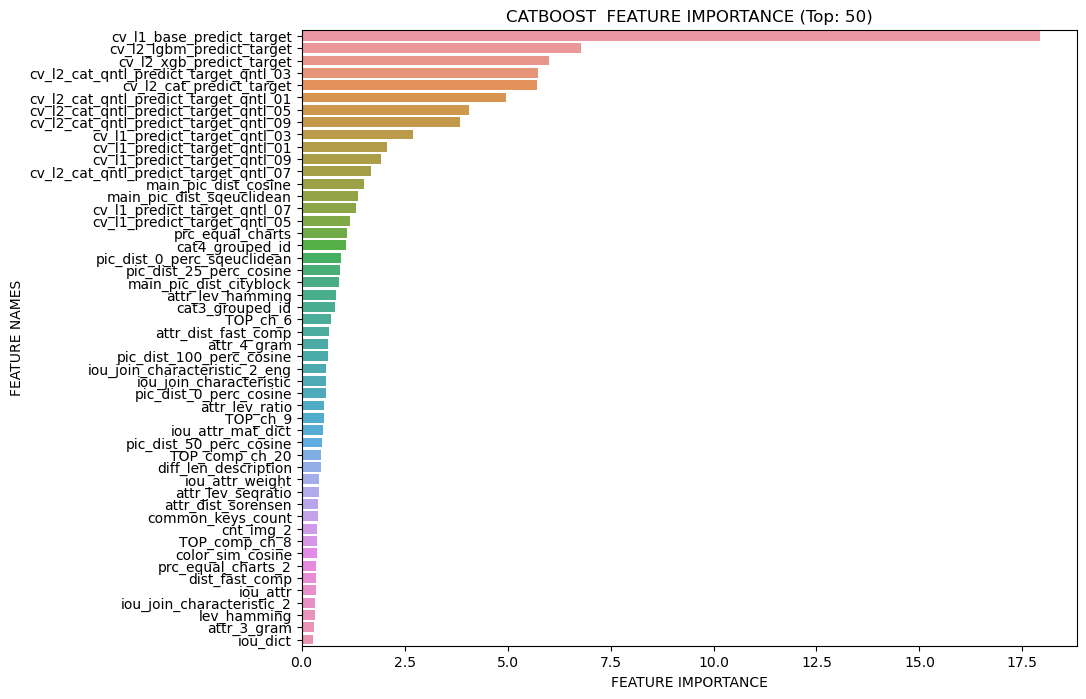

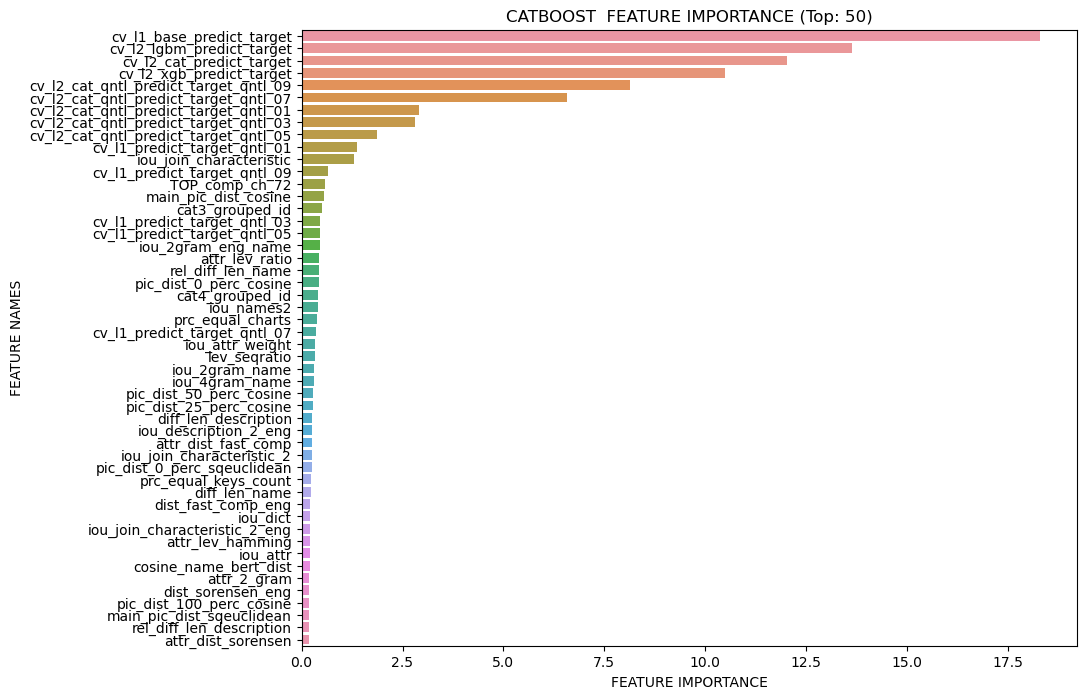

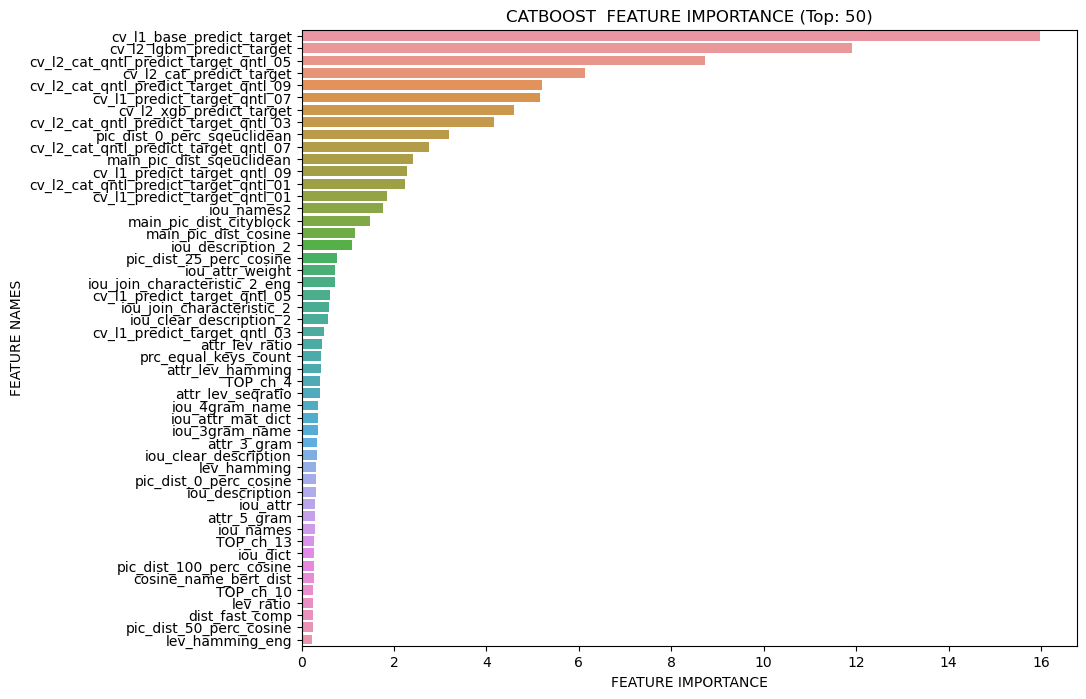

In [222]:
# 500
# 0.97643558 / 0.1828552
# 0.9669444 / 0.2299351
# 0.96431598 / 0.2292166

# 5000
# 0.975923183 / 0.186783585
# 0.965893343 / 0.2334513
# 0.96239855 / 0.2368858

def train_test_split_by_cat(full_df, cat_name:str):
    full_df = full_df[full_df['cat_level_1_1'] == cat_name]
    X_train_df, X_val_df = train_test_split(
        full_df, 
        test_size=0.05, 
        random_state=53, 
        stratify=full_df["target"]
    )
    # X_train_df = full_df
    return X_train_df, X_val_df

models_by_cat = {}
for cat_name in union_features_df["cat_level_1_1"].unique():
    # Определяем модель
    model = CatBoostClassifier(iterations=7000,
                    eval_metric =  "AUC", 
                    early_stopping_rounds=500, 
                    ignored_features=['variantid1', 'variantid2'],
                    # od_type = "Iter",
                    # od_wait = 200,                               
                    random_state=53,
                    )
    
    # Формируем выборку данных под категорию
    X_train_df, X_val_df = train_test_split_by_cat(full_df=res_X_train_val_df, cat_name=cat_name)
    
    X_train = X_train_df[features_columns + ['cv_l1_base_predict_target', 'cv_l1_predict_target_qntl_01', 'cv_l1_predict_target_qntl_03', 'cv_l1_predict_target_qntl_05', 'cv_l1_predict_target_qntl_07', 'cv_l1_predict_target_qntl_09', 'cv_l2_cat_predict_target', 'cv_l2_cat_qntl_predict_target_qntl_01', 'cv_l2_cat_qntl_predict_target_qntl_03', 'cv_l2_cat_qntl_predict_target_qntl_05', 'cv_l2_cat_qntl_predict_target_qntl_07', 'cv_l2_cat_qntl_predict_target_qntl_09', 'cv_l2_lgbm_predict_target', 'cv_l2_xgb_predict_target',]]
    y_train = X_train_df[target_column]

    X_val = X_val_df[features_columns + ['cv_l1_base_predict_target', 'cv_l1_predict_target_qntl_01', 'cv_l1_predict_target_qntl_03', 'cv_l1_predict_target_qntl_05', 'cv_l1_predict_target_qntl_07', 'cv_l1_predict_target_qntl_09', 'cv_l2_cat_predict_target', 'cv_l2_cat_qntl_predict_target_qntl_01', 'cv_l2_cat_qntl_predict_target_qntl_03', 'cv_l2_cat_qntl_predict_target_qntl_05', 'cv_l2_cat_qntl_predict_target_qntl_07', 'cv_l2_cat_qntl_predict_target_qntl_09', 'cv_l2_lgbm_predict_target', 'cv_l2_xgb_predict_target',]]
    y_val = X_val_df[target_column]
    
    # Обучаем модель
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val), 
              plot=True, 
              verbose=False 
             )
    
    plot_feature_importance(model.get_feature_importance(), (features_columns + ['cv_l1_base_predict_target', 'cv_l1_predict_target_qntl_01', 'cv_l1_predict_target_qntl_03', 'cv_l1_predict_target_qntl_05', 'cv_l1_predict_target_qntl_07', 'cv_l1_predict_target_qntl_09', 'cv_l2_cat_predict_target', 'cv_l2_cat_qntl_predict_target_qntl_01', 'cv_l2_cat_qntl_predict_target_qntl_03', 'cv_l2_cat_qntl_predict_target_qntl_05', 'cv_l2_cat_qntl_predict_target_qntl_07', 'cv_l2_cat_qntl_predict_target_qntl_09', 'cv_l2_lgbm_predict_target', 'cv_l2_xgb_predict_target',]),'CATBOOST ', top_n=50)
    
    models_by_cat[cat_name] = model

In [205]:
# models_by_cat[cat].predict_proba(res_X_test_df[X_test_df['cat_level_1_1'] == cat][features_columns + ['cv_l1_base_predict_target', 'cv_l1_predict_target_qntl_01', 'cv_l1_predict_target_qntl_03', 'cv_l1_predict_target_qntl_05', 'cv_l1_predict_target_qntl_07', 'cv_l1_predict_target_qntl_09', 'cv_l2_cat_predict_target', 'cv_l2_cat_qntl_predict_target_qntl_01', 'cv_l2_cat_qntl_predict_target_qntl_03', 'cv_l2_cat_qntl_predict_target_qntl_05', 'cv_l2_cat_qntl_predict_target_qntl_07', 'cv_l2_cat_qntl_predict_target_qntl_09', 'cv_l2_lgbm_predict_target', 'cv_l2_xgb_predict_target',]])[:,1]

In [223]:
for cat in models_by_cat.keys():
    res_X_test_df.loc[res_X_test_df['cat_level_1_1'] == cat, 'predict'] = models_by_cat[cat].predict_proba(res_X_test_df[res_X_test_df['cat_level_1_1'] == cat][features_columns + ['cv_l1_base_predict_target', 'cv_l1_predict_target_qntl_01', 'cv_l1_predict_target_qntl_03', 'cv_l1_predict_target_qntl_05', 'cv_l1_predict_target_qntl_07', 'cv_l1_predict_target_qntl_09', 'cv_l2_cat_predict_target', 'cv_l2_cat_qntl_predict_target_qntl_01', 'cv_l2_cat_qntl_predict_target_qntl_03', 'cv_l2_cat_qntl_predict_target_qntl_05', 'cv_l2_cat_qntl_predict_target_qntl_07', 'cv_l2_cat_qntl_predict_target_qntl_09', 'cv_l2_lgbm_predict_target', 'cv_l2_xgb_predict_target',]])[:,1]
res_X_test_df.shape    

(58426, 281)

In [224]:
tt_res_X_test_df = res_X_test_df.set_index(['variantid1', 'variantid2'])
tt_res_X_test_df.shape

(58426, 279)

In [225]:
tt_res_X_test_df = tt_res_X_test_df.merge(union_features_df.set_index(['variantid1', 'variantid2'])[['cat_level_2_1']], left_index=True, right_index=True, how='left')
tt_res_X_test_df = tt_res_X_test_df.reset_index()
tt_res_X_test_df.shape

(58426, 282)

In [228]:
result_test_df = pd.DataFrame({
        'target_true': tt_res_X_test_df['target'],
        'target_pred': tt_res_X_test_df['predict'],
        'category2': tt_res_X_test_df['cat_level_2_1_x']
    })
categories = result_test_df['category2'].unique()

In [229]:
# Модель 29 + переделан расчет фичей на базе топ 100 схожих характеристик по 5000 иттераций
calculate_macro_prauc_by_category(result_test_df, categories)

0.9522273329537588

In [218]:
# Модель 29 + переделан расчет фичей на базе топ 100 схожих характеристик по 500 иттераций
calculate_macro_prauc_by_category(result_test_df, categories)

0.9517897110146952

In [180]:
cv_data_df_2.shape
self.cat_features
len(predict_columns), len(predict_columns_2)

(6, 8)

In [167]:
# cv_data_df[predict_columns + ['target']]

cv_l1_predict_target_qntl_01  cv_l1_predict_target_qntl_03  \
390270                 -5.389486e-04                 -4.184235e-04   
944178                  2.554412e-03                  2.113706e-01   
879479                  1.580308e-04                  1.468081e-02   
904349                  1.667884e-01                  4.005023e-01   
562675                  5.757133e-07                  2.977163e-05   
...                              ...                           ...   
998123                  9.887305e-01                  9.994771e-01   
291869                 -1.096247e-03                 -1.093738e-03   
872479                 -1.245710e-02                 -1.078392e-03   
724815                  2.896814e-02                  1.920465e-01   
532583                 -1.695457e-02                  1.038093e-07   

        cv_l1_predict_target_qntl_05  cv_l1_predict_target_qntl_07  \
390270                 -3.105811e-04                      0.016021   
944178                  7.838894e-01                      0.950335   
879479                  1.502274e-01                      0.597799   
904349                  6.901635e-01                      0.976368   
562675                  3.664218e-02                      0.346057   
...                              ...                           ...   
998123                  9.999995e-01                      1.000000   
291869                 -1.993384e-04                      0.011700   
872479                  9.160203e-03                      0.156595   
724815                  5.028767e-01                      0.965502   
532583                  6.264906e-07                      0.000052   

        cv_l1_predict_target_qntl_09  cv_l1_base_predict_target  target  
390270                      0.133714                   0.113726     0.0  
944178                      1.083266                   1.100592     1.0  
879479                      0.909355                   0.268282     0.0  
904349                      0.997176                   0.880671     1.0  
562675                      0.976785                   0.155698     1.0  
...                              ...                        ...     ...  
998123                      1.000009                   0.861827     1.0  
291869                      0.430022                   0.048929     0.0  
872479                      0.468301                   0.013786     0.0  
724815                      1.059833                   1.112390     1.0  
532583                      0.442675                  -0.013322     0.0  

[20000 rows x 7 columns]

# Соло Модель

In [141]:
%%time
# X_train_df = 
X_train_df, X_val_df = train_test_split(
    train_df, 
    test_size=0.1, 
    random_state=53, 
    stratify=train_df["target"]
)

X_val_df, X_test_df = train_test_split(
    X_val_df, 
    test_size=0.5, 
    random_state=53, 
    stratify=X_val_df["target"]
)


X_train_df.shape, X_val_df.shape, X_test_df.shape

CPU times: total: 3.67 s
Wall time: 3.7 s


((1051657, 216), (58425, 216), (58426, 216))

In [143]:
X_train = X_train_df[features_columns]
y_train = X_train_df[target_column]

X_val = X_val_df[features_columns]
y_val = X_val_df[target_column]

X_test = X_test_df[features_columns]
y_test = X_test_df[target_column]

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape, 

((1051657, 166), (1051657,), (58426, 166), (58426,), (58425, 166), (58425,))

In [144]:
# X_train_df['name_bert_641']
# X_train_df['name_bert_642']
# X_train_df['main_pic_embeddings_resnet_v11']
# X_train_df['main_pic_embeddings_resnet_v12']

In [145]:
# X_train_df[X_train_df['cat_level_1_1'] != X_train_df['cat_level_1_2']]['target'].value_counts()

In [146]:
# %%time
# # Сохраняем фичи
# train_df[features_columns + [target_column]].to_parquet('train_df.parquet')


In [147]:
#                     'is_equal_article', 'is_equal_ISBN', 'is_equal_article2',
#                     'bm25_name', 'bm25_text_attributes', # 'bm25_name_description',
# train_df[['is_equal_article', 'is_equal_ISBN', 'is_equal_article2','bm25_name', 'bm25_text_attributes']].describe()
# # train_df['is_equal_article2'].isna().sum()
# train_df['is_equal_article'] = np.where(train_df['is_equal_article2'] , 1, 0)
# train_df['is_equal_ISBN'] = np.where(train_df['is_equal_article2'] , 1, 0)
# train_df['is_equal_article2'] = np.where(train_df['is_equal_article2'] , 1, 0)

In [148]:
# # union_features_df['is_equal_article'].value_counts()
# # union_features_df['is_equal_ISBN'].value_counts()
# union_features_df['is_equal_article2'].value_counts()

In [154]:
%%time
# 3000 итер
# 0.9580383171
# 0.96410105
# 5000 итер
# 0.9646163463
# 0.96492289
# исклчение групп 3 и 4
# 0.9599992
# добавление групп 2 и 3 и 4, и перевод в катгории
# 0.9667032
# исклчение групп 2, 3 и 4
# 0.9599992
# 5000 итер
# 0.9646163463
# 5000 итер + исключены мз обучения категории с небольшим кол-вом примеров
# 0.965389033
# 5000 итер + исключены категории из 2 и из 3 в которых мало позиций
# 0.965187915
# 5000 итер + фичи по IoU текстовых описаний
# 0.9657263
# 5000 итер + фичи по IoU текстовых описаний + characteristic_keys_similarity
# 0.9657569
# 5000 итер + фичи по IoU текстовых описаний + фичи схожести характеристик товаров
# 0.9657528
# 5000 итер + фичи по IoU текстовых описаний + фичи схожести характеристик товаров + Длина строк
# 0.9660771
# 5000 итер Модель 14 = + фичи по IoU текстовых описаний + фичи схожести характеристик товаров + Длина строк + Кол-во картинок = Модель 14
# 0.9661548
# 5000 итер + Модель 14 + Доп фичи по изображениям
# 0.96652450
# 5000 итер + Модель 14 + Доп фичи по изображениям + Признак совпадения 2х, 3х, 4х категорий 
# 0.9665483
# 5000 итер + Модель 16 + признаки берт (Дима)
# 0.9771522
# 5000 итер + Модель 16 + bm25_v1
# 0.9664745
# 5000 итер + Модель 16 + bm25_v2
# 0.9667117
# 5000 итер + Модель 16 + embedding_columns
# 0.9666294
# 5000 итер + Модель 16 = Модель 24
# 0.9665483812
# 5000 итер + Модель 24 + Артикулы+ISBN + BM25
# 0.9665582
model_cat = CatBoostClassifier(iterations=5000,
                    eval_metric =  "AUC", 
                    early_stopping_rounds=200, 
                    ignored_features=['variantid1', 'variantid2'],
#                     embedding_features=embedding_columns,
                    # cat_features= cat_columns,
                    random_state=53
                    )

model_cat.fit(X_train, y_train,
              eval_set=(X_val, y_val), 
              plot=True, 
              verbose=False 
             )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 1h 32min 2s
Wall time: 10min 59s


In [155]:
import pickle
# Сохраняем модель
with open('model_31_08_2024__vb5_6.pkl', 'wb') as file:
    pickle.dump(model_cat, file)

In [156]:
predict_test = model_cat.predict_proba(X_test)

0.965339570441372


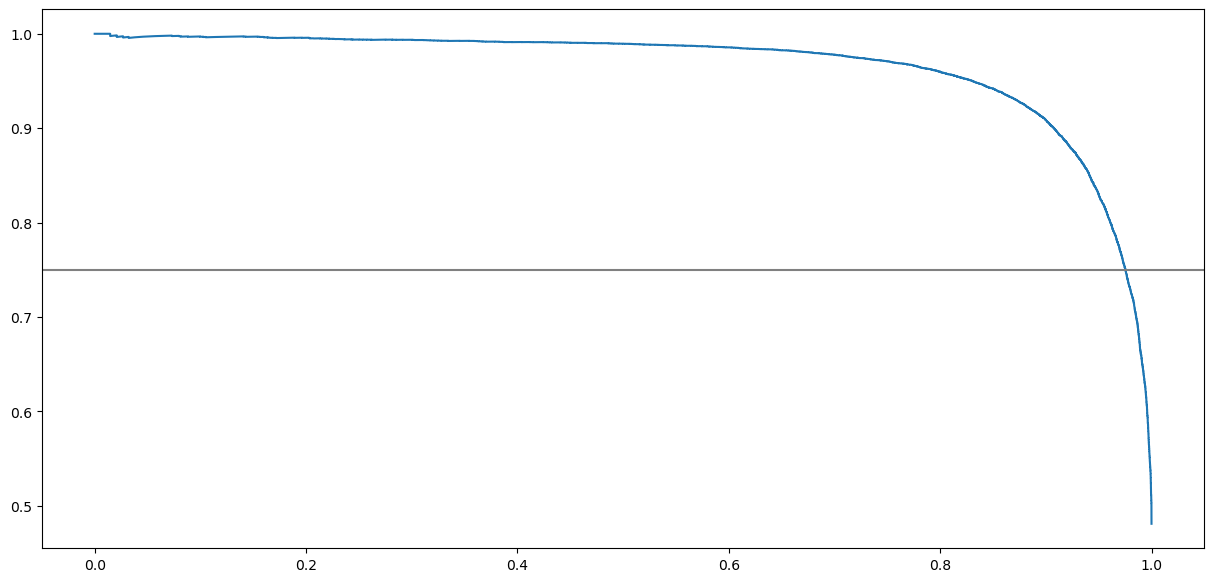

In [157]:
precision, recall, thrs = precision_recall_curve(y_test, predict_test[:,1])
pr_auc = auc(recall, precision)
print(pr_auc)
fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [159]:
result_test_df = pd.DataFrame({
        'target_true': y_test,
        'target_pred': predict_test[:,1],
        'category2': X_test_df['cat_level_2_1']
    })
categories = result_test_df['category2'].unique()

In [160]:
# 5000 итер + Модель 24 + Артикулы+ISBN + BM25
calculate_macro_prauc_by_category(result_test_df, categories)

0.95130981506936

In [61]:
# 5000 итер + Модель 16
calculate_macro_prauc_by_category(result_test_df, categories)

0.9513494652358258

In [732]:
# 5000 итер + Модель 16 + embedding_columns
calculate_macro_prauc_by_category(result_test_df, categories)

0.9497612951903823

In [588]:
# 5000 итер + Модель 16 + bm25_v2
calculate_macro_prauc_by_category(result_test_df, categories)

0.9495048883331751

In [537]:
# 5000 итер + признаки BM25 (Дима)
calculate_macro_prauc_by_category(result_test_df, categories)

0.9504498532382382

In [518]:
# 5000 итер + признаки берт (Дима)
calculate_macro_prauc_by_category(result_test_df, categories)

0.9686129601775569

In [448]:
# 5000 итер + Модель 14 + Доп фичи по изображениям + Признак совпадения 2х, 3х, 4х категорий 
calculate_macro_prauc_by_category(result_test_df, categories)

0.9513494652358258

In [424]:
# 5000 итер + Модель 14 + Доп фичи по изображениям
calculate_macro_prauc_by_category(result_test_df, categories)

0.9515933568907204

In [393]:
# 5000 итер + фичи по IoU текстовых описаний + фичи схожести характеристик товаров + Длина строк + Кол-во картинок = Модель 14
calculate_macro_prauc_by_category(result_test_df, categories)

0.951218196209914

In [369]:
# 5000 итер + фичи по IoU текстовых описаний + фичи схожести характеристик товаров + Длина строк
calculate_macro_prauc_by_category(result_test_df, categories)

0.9507259461878883

In [344]:
# 5000 итер + фичи по IoU текстовых описаний + фичи схожести характеристик товаров
calculate_macro_prauc_by_category(result_test_df, categories)

0.9501179391785897

In [246]:
# 5000 итер + фичи по IoU текстовых описаний
calculate_macro_prauc_by_category(result_test_df, categories)

0.9502174986438433

In [175]:
calculate_macro_prauc_by_category(result_test_df, categories)

0.9495091522371506

In [123]:
calculate_macro_prauc_by_category(result_test_df, categories)

0.947869110524589

In [76]:
calculate_macro_prauc_by_category(result_test_df, categories)

0.8977775448450364

In [62]:
calculate_macro_prauc_by_category(result_test_df, categories)

0.9035176593417208

In [48]:
calculate_macro_prauc_by_category(result_test_df, categories)

0.9066166514579427

In [112]:
# Levenshtein==0.25.1

# distance.__version__
# distance

In [81]:
# calculate_macro_prauc_by_category

In [83]:
# test_labels['category2'].dropna().unique()

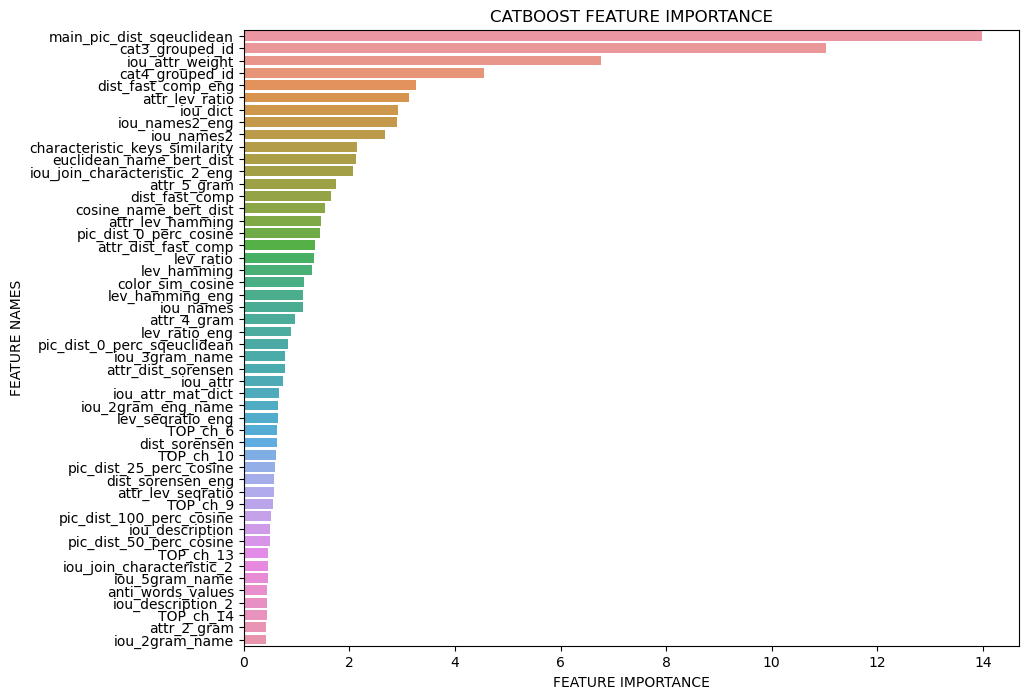

In [289]:
plot_feature_importance(model_cat.get_feature_importance(), (features_columns),'CATBOOST ', top_n=50)

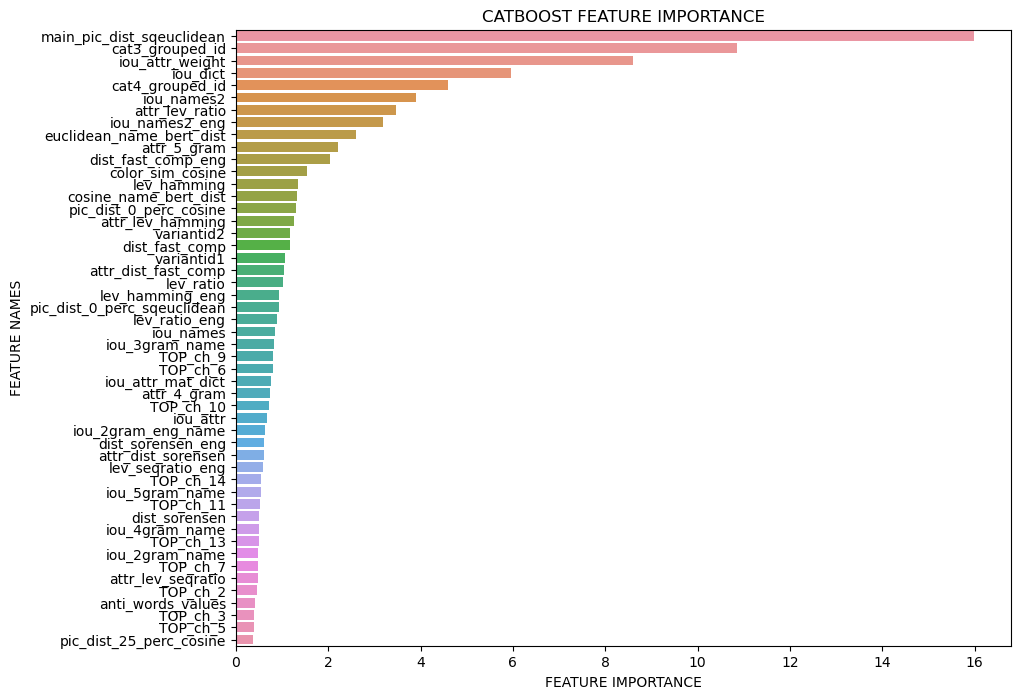

In [211]:
plot_feature_importance(model_cat.get_feature_importance(), (features_columns),'CATBOOST ', top_n=50)